In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

D:\Promotion\neurolib\GUI\current\gui\data\10110
10110


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
i_range = range(0, limit,i_stepsize)
i_range_0 = range(0, limit,i_stepsize)
i_range_1 = range(0, limit,i_stepsize)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5902.406479238383
Gradient descend method:  None
RUN  0 , total integrated cost =  5902.406479238383
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  0 , total integrated cost =  5538.707762167343
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.2666253313
Gradient descend method:  None
RUN  0 , total integrated cost =  13602.2666253313
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  6 0.4250000000000001 0.40000000000000013
set 

In [14]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  1 , total integrated cost =  343.8100171538386
RUN  2 , total integrated cost =  146.35088768770174
RUN  3 , total integrated cost =  131.89189974871442
RUN  4 , total integrated cost =  127.584731447035
RUN  5 , total integrated cost =  122.65912102298162
RUN  6 , total integrated cost =  114.90509986985575
RUN  7 , total integrated cost =  112.53977065290665
RUN  8 , total integrated cost =  112.53121015871753
RUN  9 , total integrated cost =  112.4337802455335
RUN  10 , total integrated cost =  112.17985526389278
RUN  11 , total integrated cost =  112.16318238179402
RUN  12 , total integrated cost =  112.16181214447789
RUN  13 , total integrated cost =  112.16151964372473
RUN  14 , total integrated cost =  112.16107055892212
RUN  15

ERROR:root:Problem in initial value trasfer



RUN  22 , total integrated cost =  111.57950022831767
Improved over  22  iterations in  23.3064087  seconds by  97.98545969530164  percent.
Problem in initial value trasfer:  Vmean_exc -66.5065825809234 -66.51277255847596
weight =  496.3911606373802
set cost params:  1.0 0.0 496.3911606373802
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5441.2999194089
Gradient descend method:  None
RUN  1 , total integrated cost =  5082.190861136069
RUN  2 , total integrated cost =  5080.009102198861
RUN  3 , total integrated cost =  5079.601323966002
RUN  4 , total integrated cost =  5070.20857147312
RUN  5 , total integrated cost =  5059.865471524614
RUN  6 , total integrated cost =  5059.725991501214
RUN  7 , total integrated cost =  5059.721811935729
RUN  8 , total integrated cost =  5059.721570465483
RUN  9 , total integrated cost =  5059.72152669342
RUN  10 , total integrated cost =  5059.721524231475
RUN  11 , total integrated cost =  5059.7215242314705
RUN 

ERROR:root:Problem in initial value trasfer


 12 , total integrated cost =  5059.721524231465
RUN  13 , total integrated cost =  5059.721524231465
Control only changes marginally.
RUN  13 , total integrated cost =  5059.721524231465
Improved over  13  iterations in  0.6661403999999962  seconds by  7.012633025729002  percent.
Problem in initial value trasfer:  Vmean_exc -60.31135330644351 -60.343199897501236
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.2666253313
Gradient descend method:  None
RUN  1 , total integrated cost =  8960.564221406214
RUN  2 , total integrated cost =  8932.844378483718
RUN  3 , total integrated cost =  8931.259191327703
RUN  4 , total integrated cost =  8931.168285689151
RUN  5 , total integrated cost =  8931.154738631414
RUN  6 , total integrated cost =  8931.144094298246
RUN  7 , total integrated cost =  8931.133300910882
RUN  8 , total integrated cost =  8931.123687204898
RUN  9 , total int

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1177 , total integrated cost =  8930.43487001213
Improved over  1177  iterations in  53.0857478  seconds by  34.34597985764289  percent.
Problem in initial value trasfer:  Vmean_exc -56.644231069124544 -56.6445638540385
weight =  15.231359752711377
set cost params:  1.0 0.0 15.231359752711377
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9082.387434315962
Gradient descend method:  None
RUN  1 , total integrated cost =  9082.387434315962
Control only changes marginally.
RUN  1 , total integrated cost =  9082.387434315962
Improved over  1  iterations in  0.12667879999999343  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644231069124544 -56.6445638540385
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9439.076736893423
Gradient descend method:  None
RUN  1 , total integrated cost =  4331.482245

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  89 , total integrated cost =  4289.499176478545
Improved over  89  iterations in  3.955218699999989  seconds by  54.55594550139975  percent.
Problem in initial value trasfer:  Vmean_exc -56.629145484396076 -56.62927716084976
weight =  22.00507879486857
set cost params:  1.0 0.0 22.00507879486857
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4815.121290971736
Gradient descend method:  None
RUN  1 , total integrated cost =  4815.121290971736
Control only changes marginally.
RUN  1 , total integrated cost =  4815.121290971736
Improved over  1  iterations in  0.14331170000001237  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.629145484396076 -56.62927716084976
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17551.147823015366
Gradient descend method:  None
RUN  1 , total integrated cost =  13246

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  28 , total integrated cost =  13209.632927477513
Improved over  28  iterations in  1.262295100000003  seconds by  24.73635878016303  percent.
Problem in initial value trasfer:  Vmean_exc -56.67162787368366 -56.67198759203822
weight =  13.28662796261887
set cost params:  1.0 0.0 13.28662796261887
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13292.695925293092
Gradient descend method:  None
RUN  1 , total integrated cost =  13292.695925293092
Control only changes marginally.
RUN  1 , total integrated cost =  13292.695925293092
Improved over  1  iterations in  0.11494709999999486  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67162787368366 -56.67198759203822
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17571.20016629342
Gradient descend 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer



RUN  34 , total integrated cost =  13508.21027981236
Improved over  34  iterations in  1.4644426000000124  seconds by  23.123007239283723  percent.
Problem in initial value trasfer:  Vmean_exc -56.67164382976491 -56.67200219958329
weight =  13.00779289211472
set cost params:  1.0 0.0 13.00779289211472
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13581.850211687875
Gradient descend method:  None
RUN  1 , total integrated cost =  13581.850211687875
Control only changes marginally.
RUN  1 , total integrated cost =  13581.850211687875
Improved over  1  iterations in  0.10806179999998733  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67164382976491 -56.67200219958329
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8796.175560697715
Gradient descend method:  None
RUN  1 , total integrated cost =  4337.698527316733
RUN  2 , total int

ERROR:root:Problem in initial value trasfer


RUN  120 , total integrated cost =  4272.520879073683
Control only changes marginally.
RUN  121 , total integrated cost =  4272.520879073683
Improved over  121  iterations in  5.298000399999992  seconds by  51.427516997685004  percent.
Problem in initial value trasfer:  Vmean_exc -56.629166425546146 -56.62928639161836
weight =  20.587788356472107
set cost params:  1.0 0.0 20.587788356472107
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4708.881733675784
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4708.881733675784
Control only changes marginally.
RUN  1 , total integrated cost =  4708.881733675784
Improved over  1  iterations in  0.13472809999998958  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.629166425546146 -56.62928639161836
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17340.897955123706
Gradient descend method:  None
RUN  1 , total integrated cost =  13618.58373978211
RUN  2 , total integrated cost =  13569.654468289513
RUN  3 , total integrated cost =  13568.089428857726
RUN  4 , total integrated cost =  13568.077687537036
RUN  5 , total integrated cost =  13568.073813264242
RUN  6 , total integrated cost =  13568.070234245493
RUN  7 , total integrated cost =  13568.069533140886
RUN  8 , total integrated cost =  13568.06828079182
RUN  9 , total integrated cost =  13568.063229531499
RUN  10 , total inte

ERROR:root:Problem in initial value trasfer


RUN  70 , total integrated cost =  13567.977775966472
Control only changes marginally.
RUN  71 , total integrated cost =  13567.977775966472
Improved over  71  iterations in  3.1465742000000034  seconds by  21.757351833342938  percent.
Problem in initial value trasfer:  Vmean_exc -56.67165605533716 -56.672007755681754
weight =  12.780753507601087
set cost params:  1.0 0.0 12.780753507601087
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13633.78763788031
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  13633.78763788031
Control only changes marginally.
RUN  1 , total integrated cost =  13633.78763788031
Improved over  1  iterations in  0.10336220000002072  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67165605533716 -56.672007755681754
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3671.159244301901
Gradient descend method:  None
RUN  1 , total integrated cost =  149.30955459732002
RUN  2 , total integrated cost =  133.2162548047774
RUN  3 , total integrated cost =  113.47839109925386
RUN  4 , total integrated cost =  104.45334296481558
RUN  5 , total integrated cost =  94.1985314582366
RUN  6 , total integrated cost =  88.72755779921155
RUN  7 , total integrated cost =  82.16104675013871
RUN  8 , total integrated cost =  78.19622683011542
RUN  9 , total integrated cost =  73.5582290301248
RUN  10 , total integrated cost 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  38 , total integrated cost =  54.66742256693521
Improved over  38  iterations in  1.8482115999999849  seconds by  98.51089481743986  percent.
Problem in initial value trasfer:  Vmean_exc -70.09258793105381 -70.12381477983493
weight =  671.5442345588738
set cost params:  1.0 0.0 671.5442345588738
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3570.2617846472685
Gradient descend method:  None
RUN  1 , total integrated cost =  3122.250183800917
RUN  2 , total integrated cost =  3119.542291336488
RUN  3 , total integrated cost =  3112.196917161529
RUN  4 , total integrated cost =  3111.8513704155625
RUN  5 , total integrated cost =  3111.8474333916893
RUN  6 , total integrated cost =  3111.847408669362
RUN  7 , total integrated cost =  3111.8474077571805
RUN  8 , total integrated cost =  3111.847407757178
RUN  9 , total integrated cost =  3111.8474077571723
RUN  10 , total integrated cost =  3111.8474077571627

ERROR:root:Problem in initial value trasfer



RUN  11 , total integrated cost =  3111.8474077571627
Control only changes marginally.
RUN  11 , total integrated cost =  3111.8474077571627
Improved over  11  iterations in  0.6421438000000137  seconds by  12.839797318543006  percent.
Problem in initial value trasfer:  Vmean_exc -60.758201139439805 -60.801454666864956
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21565.177588309605
Gradient descend method:  None
RUN  1 , total integrated cost =  18036.952549076108
RUN  2 , total integrated cost =  17982.400084546964
RUN  3 , total integrated cost =  17981.210519835306
RUN  4 , total integrated cost =  17981.149153462164
RUN  5 , total integrated cost =  17981.145904404755
RUN  6 , total integrated cost =  17981.14432365694
RUN  7 , total integrated cost =  17981.14327909147
RUN  8 , total integrated cost =  17981.14168315382
RUN 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  37 , total integrated cost =  17981.107363022853
Improved over  37  iterations in  1.7989695000000268  seconds by  16.619711155217487  percent.
Problem in initial value trasfer:  Vmean_exc -56.689290963357486 -56.68955699764926
weight =  11.993242214134815
set cost params:  1.0 0.0 11.993242214134815
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18024.001873614463
Gradient descend method:  None
RUN  1 , total integrated cost =  18024.001873614463
Control only changes marginally.
RUN  1 , total integrated cost =  18024.001873614463
Improved over  1  iterations in  0.13824979999998277  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689290963357486 -56.68955699764926
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.9816241341314
Gradient descend method:  None
RUN  1 , total integrated cost =

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  33.81121289503134
RUN  13 , total integrated cost =  33.81121289503134
Control only changes marginally.
RUN  13 , total integrated cost =  33.81121289503134
Improved over  13  iterations in  0.701483699999983  seconds by  98.86576916069208  percent.
Problem in initial value trasfer:  Vmean_exc -70.52520489029581 -70.5602196740954
weight =  881.6547437646627
set cost params:  1.0 0.0 881.6547437646627
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2871.163373281141
Gradient descend method:  None
RUN  1 , total integrated cost =  2384.783246374491
RUN  2 , total integrated cost =  2373.6567228550653
RUN  3 , total integrated cost =  2363.365770304047
RUN  4 , total integrated cost =  2363.236837944906
RUN  5 , total integrated cost =  2363.2367932798543
RUN  6 , total integrated cost =  2363.236792825361
RUN  7 , total integrated cost =  2363.2367928253484
RUN  8 , total integrated cost =  2363.2367928253448


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  2363.2367928253434
RUN  10 , total integrated cost =  2363.2367928253434
Control only changes marginally.
RUN  10 , total integrated cost =  2363.2367928253434
Improved over  10  iterations in  0.6364219000000162  seconds by  17.690619251503733  percent.
Problem in initial value trasfer:  Vmean_exc -60.54746671472449 -60.58930550763647
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12479.684613466703
Gradient descend method:  None
RUN  1 , total integrated cost =  9287.89929840231
RUN  2 , total integrated cost =  9226.867764939865
RUN  3 , total integrated cost =  9222.180899435687
RUN  4 , total integrated cost =  9222.115140217922
RUN  5 , total integrated cost =  9222.106244259478
RUN  6 , total integrated cost =  9222.098669971849
RUN  7 , total integrated cost =  9222.090557282852
RUN  8 , total integrated cost =  9222.085093938997
RUN  9 , t

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  47 , total integrated cost =  9222.010599391197
Improved over  47  iterations in  2.1473392000000047  seconds by  26.103816842936737  percent.
Problem in initial value trasfer:  Vmean_exc -56.64432951132283 -56.644665305182876
weight =  13.532498666061569
set cost params:  1.0 0.0 13.532498666061569
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9308.97328517657
Gradient descend method:  None
RUN  1 , total integrated cost =  9308.97328517657
Control only changes marginally.
RUN  1 , total integrated cost =  9308.97328517657
Improved over  1  iterations in  0.1356163999999751  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64432951132283 -56.644665305182876
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21313.092781962267
Gradient descend method:  None
RUN  1 , total integrated cost =  18049.

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  34 , total integrated cost =  17987.69715813702
Improved over  34  iterations in  1.5155454000000077  seconds by  15.602595352278499  percent.
Problem in initial value trasfer:  Vmean_exc -56.689274728976294 -56.689527949125406
weight =  11.848705587263543
set cost params:  1.0 0.0 11.848705587263543
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18026.22044731937
Gradient descend method:  None
RUN  1 , total integrated cost =  18026.22044731937
Control only changes marginally.
RUN  1 , total integrated cost =  18026.22044731937
Improved over  1  iterations in  0.11894159999999943  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689274728976294 -56.689527949125406
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16568.218379642258
Gradient desce

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  26 , total integrated cost =  13555.900693318132
Improved over  26  iterations in  1.1518212000000005  seconds by  18.181301195458815  percent.
Problem in initial value trasfer:  Vmean_exc -56.671747418820196 -56.67208551577838
weight =  12.222144993883685
set cost params:  1.0 0.0 12.222144993883685
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.932755857466
Gradient descend method:  None
RUN  1 , total integrated cost =  13602.932755857466
Control only changes marginally.
RUN  1 , total integrated cost =  13602.932755857466
Improved over  1  iterations in  0.11642810000000736  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671747418820196 -56.67208551577838
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25759.690310553517
Gradient descend method:  None
RUN  1 , total integrated cost =

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  128 , total integrated cost =  22574.905555652807
Improved over  128  iterations in  5.582638399999979  seconds by  12.363443490607224  percent.
Problem in initial value trasfer:  Vmean_exc -56.69930333195428 -56.69946920481445
weight =  11.41076326855473
set cost params:  1.0 0.0 11.41076326855473
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22602.365858706267
Gradient descend method:  None
RUN  1 , total integrated cost =  22602.365858706267
Control only changes marginally.
RUN  1 , total integrated cost =  22602.365858706267
Improved over  1  iterations in  0.14309420000000728  seconds by  0.0  percent.


ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.69930333195428 -56.69946920481445
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.667733280556
Gradient descend method:  None
RUN  1 , total integrated cost =  4327.374982280886
RUN  2 , total integrated cost =  4222.835253535116
RUN  3 , total integrated cost =  4218.9290518856105
RUN  4 , total integrated cost =  4218.824065483332
RUN  5 , total integrated cost =  4218.784466365163
RUN  6 , total integrated cost =  4218.748894205986
RUN  7 , total integrated cost =  4218.714954855518
RUN  8 , total integrated cost =  4218.679425330933
RUN  9 , total integrated cost =  4218.644845237761
RUN  10 , total integrated cost =  4218.6136829191155
RUN  11 , total integrated cost =  4218.576642507086
RUN  12 , total integrated cost =  4218.534227672615
RUN  13 , total integrated cost =  4218.494380199751
RUN  14 , total integrated cost =

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  150 , total integrated cost =  4217.582984611059
Control only changes marginally.
RUN  150 , total integrated cost =  4217.582984611059
Improved over  150  iterations in  6.504214700000006  seconds by  45.52100232253387  percent.
Problem in initial value trasfer:  Vmean_exc -56.62931671875469 -56.629345776005394
weight =  18.355697473002973
set cost params:  1.0 0.0 18.355697473002973
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4520.237831449688
Gradient descend method:  None
RUN  1 , total integrated cost =  4520.237831449688
Control only changes marginally.
RUN  1 , total integrated cost =  4520.237831449688
Improved over  1  iterations in  0.12954750000000104  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62931671875469 -56.629345776005394
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 10.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16344.628194217961
Gradient des

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  13548.077535727596
Control only changes marginally.
RUN  50 , total integrated cost =  13548.077535727596
Improved over  50  iterations in  2.245050099999986  seconds by  17.109906846823634  percent.
Problem in initial value trasfer:  Vmean_exc -56.671758754196716 -56.672087615768916
weight =  12.064167887374122
set cost params:  1.0 0.0 12.064167887374122
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13590.195663221019
Gradient descend method:  None
RUN  1 , total integrated cost =  13590.195663221019
Control only changes marginally.
RUN  1 , total integrated cost =  13590.195663221019
Improved over  1  iterations in  0.13467630000002373  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671758754196716 -56.672087615768916


--------- 0


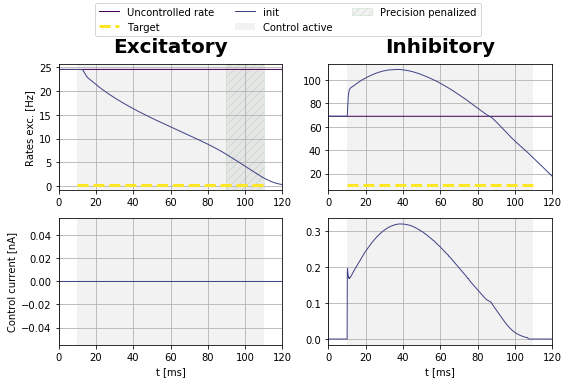

--------- 2


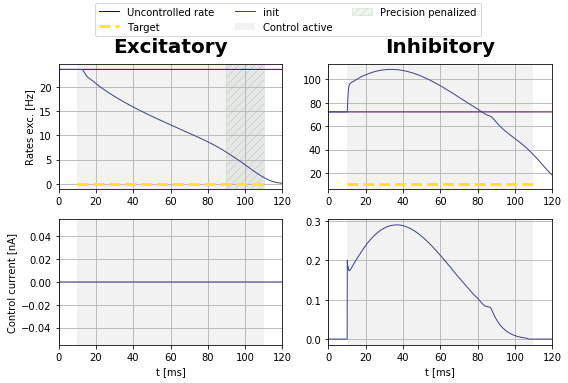

--------- 4


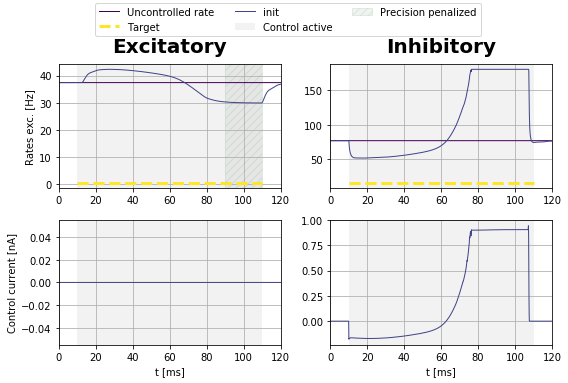

--------- 6


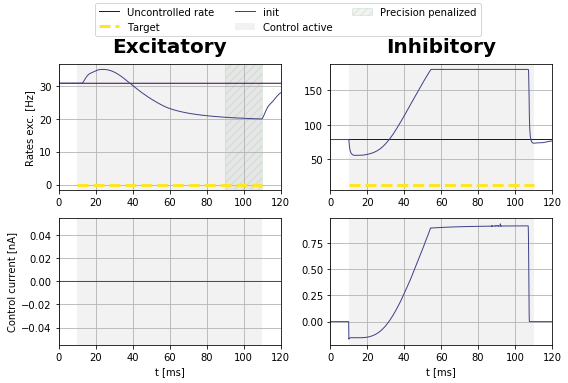

--------- 8


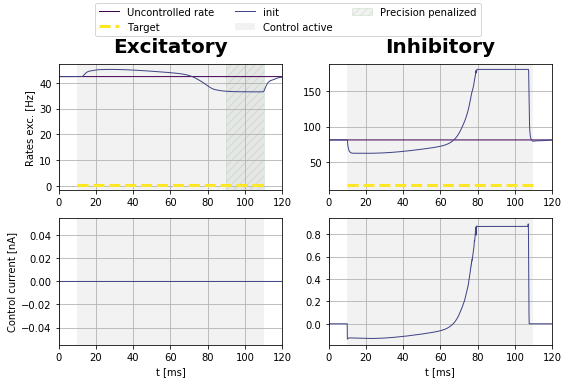

--------- 10


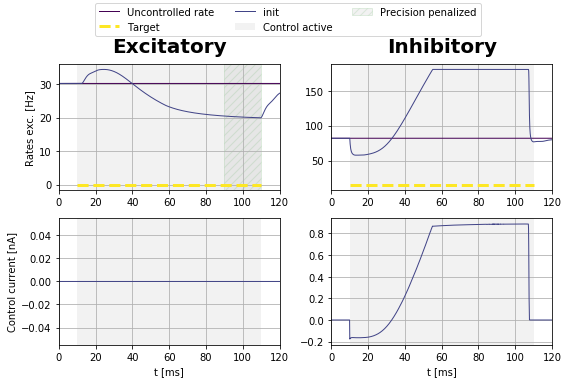

--------- 12


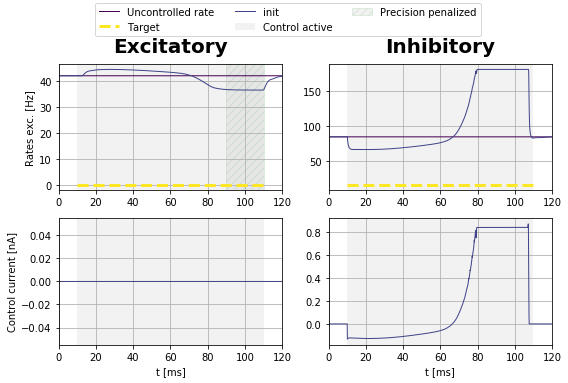

--------- 14


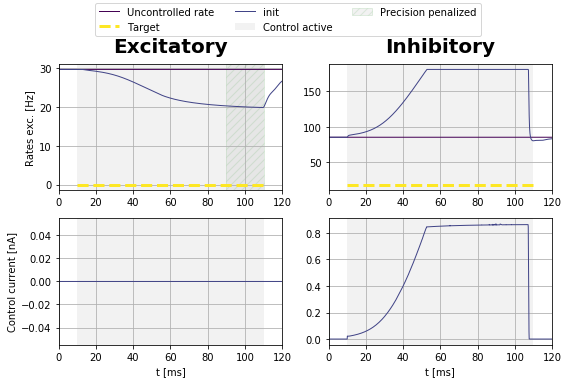

--------- 16


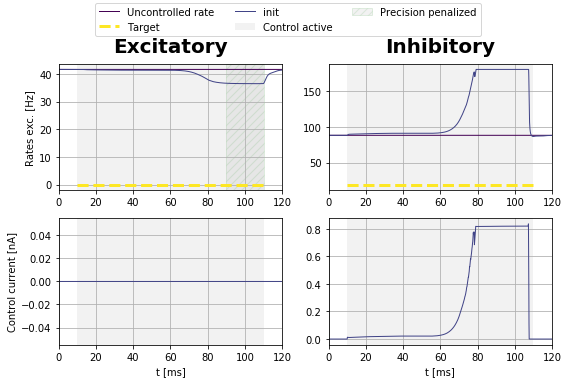

--------- 18


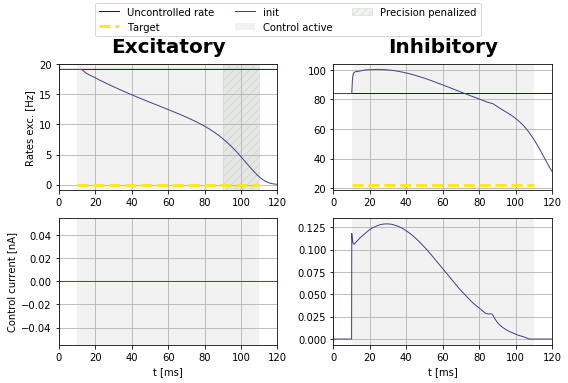

--------- 20


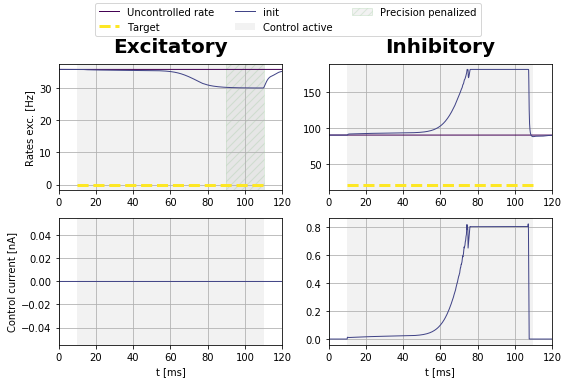

--------- 22


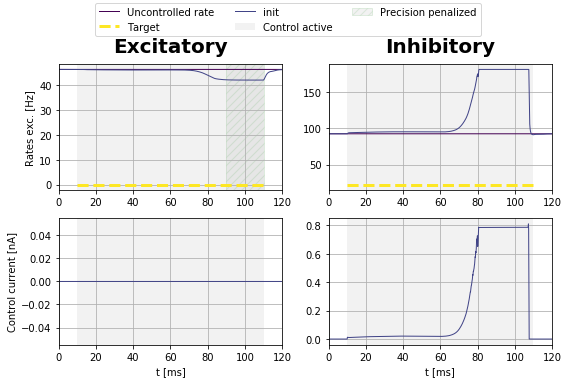

--------- 24


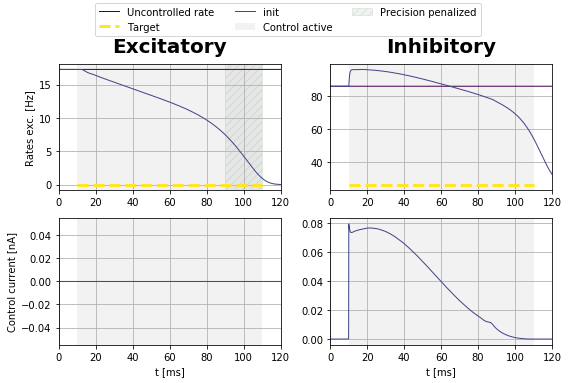

--------- 26


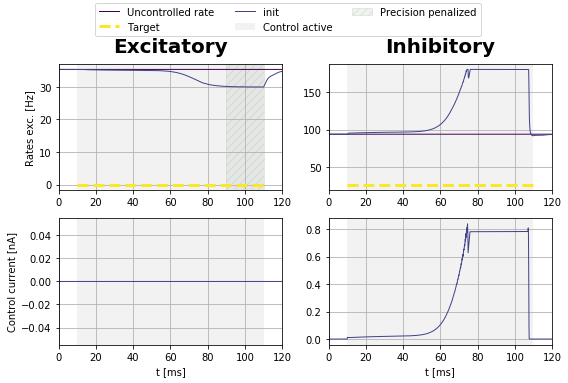

--------- 28


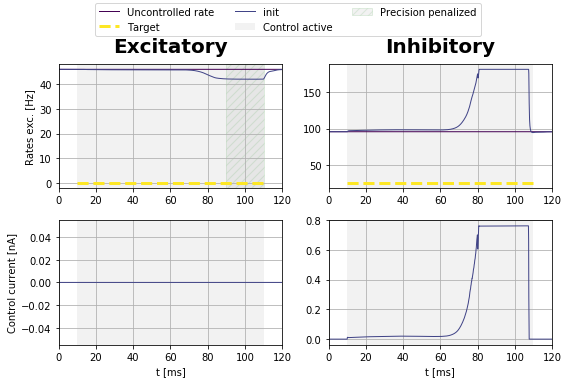

--------- 30


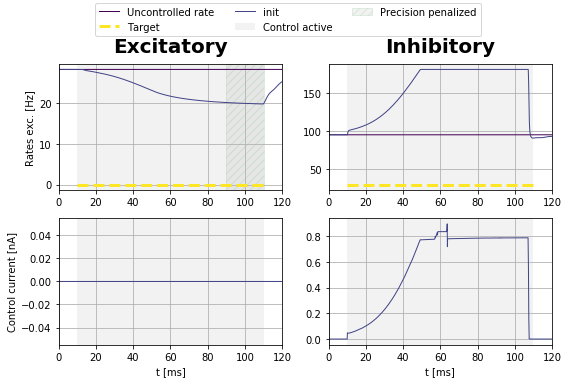

--------- 32


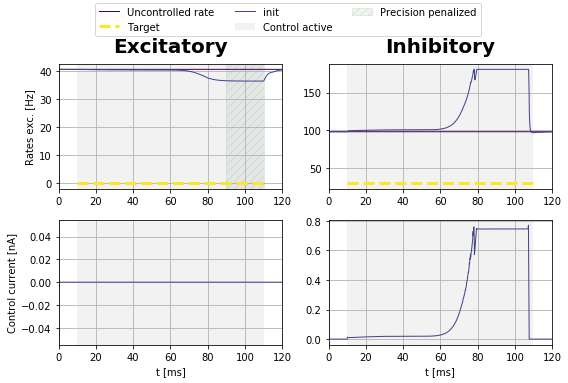

--------- 34


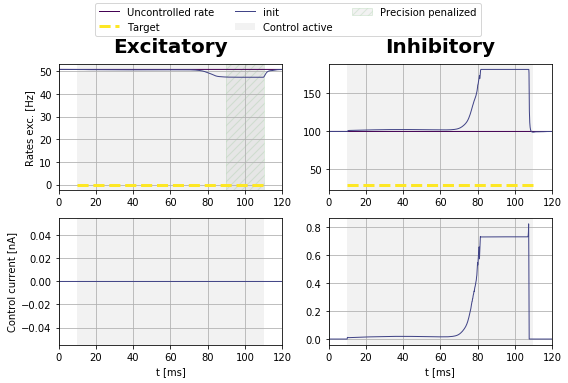

--------- 36


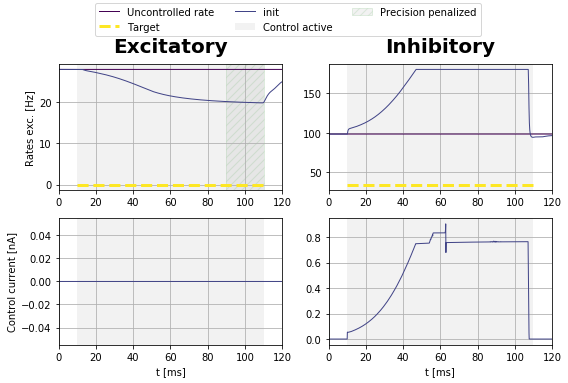

--------- 38


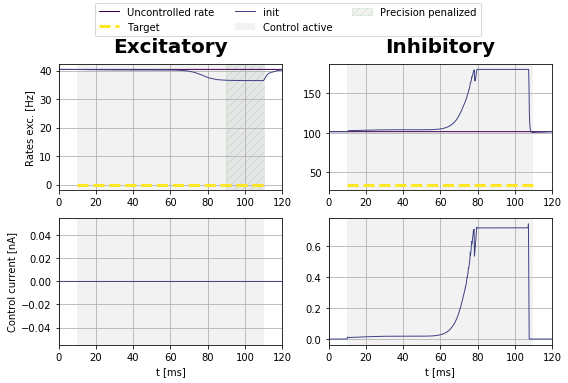

In [24]:
#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [23]:
found_solution = []
no_solution = []
factor_iteration = 1.
already_tried = [ [] for _ in range(len(exc)) ]
factor_ = 1.1

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])

        if np.abs(np.mean(bestState_init[i][0,0,-10:]) - target[i][0,0,-1]) < 0.2 * np.abs(
            np.mean(bestState_init[i][0,0,-10:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - target[i][0,1,-1]) < 0.2 * np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - bestState_init[i][0,1,0]) and np.amax(
            bestState_init[i][0,0,:]) > target[i][0,0,-1] - 1. and np.amax(
            bestState_init[i][0,1,:]) > target[i][0,1,-1] - 1.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue

        if len(found_solution) == 0:
            continue
            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_)

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if i != 0 and closest_ != -1:
            control0 = factor_ * bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(500 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
found solution for  0
-------  2 0.4000000000000001 0.3750000000000001
found solution for  2
-------  4 0.4500000000000001 0.3750000000000001
[0, 2] []
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13163.625925617784
Gradient descend method:  None
RUN  1 , total integrated cost =  8977.322700043567
RUN  2 , total integrated cost =  8944.374931292828
RUN  3 , total integrated cost =  8943.739990919663
RUN  4 , total integrated cost =  8943.721283390847
RUN  5 , total integrated cost =  8943.699912310614
RUN  6 , total integrated cost =  8943.67747619216
RUN  7 , total integrated cost =  8943.656758174848
RUN  8 , total integrated cost =  8943.635173428616
RUN  9 , t

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  60 , total integrated cost =  8943.185684923577
Control only changes marginally.
RUN  60 , total integrated cost =  8943.185684923577
Improved over  60  iterations in  1.5789875000009488  seconds by  32.06138084249865  percent.
Problem in initial value trasfer:  Vmean_exc -56.64478561756705 -56.645280981373205
weight =  15.209643525865737
set cost params:  1.0 0.0 15.209643525865737
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9082.494289351162
Gradient descend method:  None
RUN  1 , total integrated cost =  9082.49428935116
RUN  2 , total integrated cost =  9082.49428935116
Control only changes marginally.
RUN  2 , total integrated cost =  9082.49428935116
Improved over  2  iterations in  0.15097630000309437  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.644785617567045 -56.645280981373205
-------  6 0.4250000000000001 0.40000000000000013
[0, 2] []
closest index  2
set cost params:  1.0 0.0 10.0
precision v

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4378.675213737635
RUN  100 , total integrated cost =  4378.675213737635
Improved over  100  iterations in  2.744657700000971  seconds by  50.73659018857038  percent.
Problem in initial value trasfer:  Vmean_exc -56.627579676376 -56.627557362783826
weight =  21.556923672437062
set cost params:  1.0 0.0 21.556923672437062
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4786.48900322977
Gradient descend method:  None
RUN  1 , total integrated cost =  4786.489003229768
RUN  2 , total integrated cost =  4786.489003229768
Control only changes marginally.
RUN  2 , total integrated cost =  4786.489003229768
Improved over  2  iterations in  0.12668230000053882  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.627579676376 -56.62755736278383
-------  8 0.47500000000000014 0.40000000000000013
[0, 2] []
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  47 , total integrated cost =  13212.036854157719
Improved over  47  iterations in  1.2521133000009286  seconds by  23.17757786656152  percent.
Problem in initial value trasfer:  Vmean_exc -56.671821251314654 -56.67224399233896
weight =  13.284210464105817
set cost params:  1.0 0.0 13.284210464105817
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13292.080514287523
Gradient descend method:  None
RUN  1 , total integrated cost =  13292.080514287523
Control only changes marginally.
RUN  1 , total integrated cost =  13292.080514287523
Improved over  1  iterations in  0.07048490000306629  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671821251314654 -56.67224399233896
-------  10 0.4250000000000001 0.42500000000000016
[0, 2] []
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8593.256327008192
Gradient descen

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4379.466386516947
RUN  100 , total integrated cost =  4379.466386516947
Improved over  100  iterations in  2.8948315999987244  seconds by  49.036008937002215  percent.
Problem in initial value trasfer:  Vmean_exc -56.6275489023258 -56.62752108716921
weight =  20.804946735662412
set cost params:  1.0 0.0 20.804946735662412
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4748.343032625837
Gradient descend method:  None
RUN  1 , total integrated cost =  4748.343025787146
RUN  2 , total integrated cost =  4748.34302276373
RUN  3 , total integrated cost =  4748.343019832442
RUN  4 , total integrated cost =  4748.343018797663
RUN  5

ERROR:root:Problem in initial value trasfer


 , total integrated cost =  4748.3430187270815
RUN  6 , total integrated cost =  4748.343018727078
RUN  7 , total integrated cost =  4748.343018727077
RUN  8 , total integrated cost =  4748.343018727077
Control only changes marginally.
RUN  8 , total integrated cost =  4748.343018727077
Improved over  8  iterations in  0.31547199999840814  seconds by  2.9270758261645824e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.62754888661506 -56.62752107136778
-------  12 0.47500000000000014 0.42500000000000016
[0, 2] []
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17250.99181964037
Gradient descend method:  None
RUN  1 , total integrated cost =  13553.882824932045
RUN  2 , total integrated cost =  13512.496021539582
RUN  3 , total integrated cost =  13510.291660578052
RUN  4 , total integrated cost =  13510.21272273823
RUN  5 , total integrated cost =  13510.205329611708
RUN  6 , tota

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  22 , total integrated cost =  13510.175916379967
Improved over  22  iterations in  0.6805471000006946  seconds by  21.684642496911152  percent.
Problem in initial value trasfer:  Vmean_exc -56.67178180192856 -56.67218424002759
weight =  13.005900348780653
set cost params:  1.0 0.0 13.005900348780653
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13581.510892803584
Gradient descend method:  None
RUN  1 , total integrated cost =  13581.510892803584
Control only changes marginally.
RUN  1 , total integrated cost =  13581.510892803584
Improved over  1  iterations in  0.09381030000076862  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67178180192856 -56.67218424002759
-------  14 0.4250000000000001 0.4500000000000002
[0, 2] []
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8307.340224118641
Gradient descend 

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4357.374606368172
RUN  100 , total integrated cost =  4357.374606368172
Improved over  100  iterations in  2.993174300001556  seconds by  47.54789753623624  percent.
Problem in initial value trasfer:  Vmean_exc -56.627672223976475 -56.62764238356165
weight =  20.186870203544974
set cost params:  1.0 0.0 20.186870203544974
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4699.358800586221
Gradient descend method:  None
RUN  1 , total integrated cost =  4699.358800586219
RUN  2 , total integrated cost =  4699.358800586219
Control only changes marginally.
RUN  2 , total integrated cost =  4699.358800586219
Improved over  2  iterations in  0.155144600001222  seconds by  2.842170943040401e-14  percent.


ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.627672223976475 -56.62764238356165
-------  16 0.47500000000000014 0.4500000000000002
[0, 2] []
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17052.56129612695
Gradient descend method:  None
RUN  1 , total integrated cost =  13619.640284041196
RUN  2 , total integrated cost =  13571.646083677166
RUN  3 , total integrated cost =  13569.889572661132
RUN  4 , total integrated cost =  13569.839447886281
RUN  5 , total integrated cost =  13569.808628143497
RUN  6 , total integrated cost =  13569.790002750617
RUN  7 , total integrated cost =  13569.778024371251
RUN  8 , total integrated cost =  13569.767039950932
RUN  9 , total integrated cost =  13569.755942760687
RUN  10 , total integrated cost =  13569.745545822714
RUN  11 , total integrated cost =  13569.736770791615
RUN  12 , total integrated cost =  13569.727213760676
RUN  13 , total integrate

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  39 , total integrated cost =  13569.677316292884
Improved over  39  iterations in  1.2324708999985887  seconds by  20.42440381448806  percent.
Problem in initial value trasfer:  Vmean_exc -56.67216857891733 -56.672596773356574
weight =  12.779152776391212
set cost params:  1.0 0.0 12.779152776391212
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13633.505074064775
Gradient descend method:  None
RUN  1 , total integrated cost =  13633.505074064773
RUN  2 , total integrated cost =  13633.505074064773
Control only changes marginally.
RUN  2 , total integrated cost =  13633.505074064773
Improved over  2  iterations in  0.14315039999928558  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.67216857891733 -56.672596773356574
-------  18 0.4000000000000001 0.4750000000000002
found solution for  18
-------  20 0.4500000000000001 0.4750000000000002
[0, 2, 18] []
closest index  18
set cost 

ERROR:root:Problem in initial value trasfer


RUN  40 , total integrated cost =  9241.293472502082
Control only changes marginally.
RUN  43 , total integrated cost =  9241.293472502079
Improved over  43  iterations in  1.3108573000026809  seconds by  26.764772754205865  percent.
Problem in initial value trasfer:  Vmean_exc -56.644778430912346 -56.64521090417392
weight =  13.7839107568374
set cost params:  1.0 0.0 13.7839107568374
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9332.71183394444
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  9332.71183394444
Control only changes marginally.
RUN  1 , total integrated cost =  9332.71183394444
Improved over  1  iterations in  0.07733159999770578  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644778430912346 -56.64521090417392
-------  22 0.5000000000000002 0.4750000000000002
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21464.9357702445
Gradient descend method:  None
RUN  1 , total integrated cost =  18041.910600552306
RUN  2 , total integrated cost =  17983.915739905453
RUN  3 , total integrated cost =  17983.395457634924
RUN  4 , total integrated cost =  17983.380219392177
RUN  5 , total integrated cost =  17983.372788353874
RUN  6 , total integrated cost =  17983.366278023706
RUN  7 , total integrated cost =  17983.36136209837
RUN  8 , total integrated cost =  17983.358444606856
RUN  9 , total integrated c

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  40 , total integrated cost =  17983.32795131602
Control only changes marginally.
RUN  41 , total integrated cost =  17983.32795131602
Improved over  41  iterations in  1.3465483999971184  seconds by  16.219977810298488  percent.
Problem in initial value trasfer:  Vmean_exc -56.68935008154978 -56.689636681846125
weight =  11.991761283946037
set cost params:  1.0 0.0 11.991761283946037
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18025.478157114732
Gradient descend method:  None
RUN  1 , total integrated cost =  18025.478157114732
Control only changes marginally.
RUN  1 , total integrated cost =  18025.478157114732
Improved over  1  iterations in  0.08457700000144541  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68935008154978 -56.689636681846125
-------  24 0.4000000000000001 0.5000000000000002
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , t

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  33.804273855134426
RUN  11 , total integrated cost =  33.804273855134426
Control only changes marginally.
RUN  11 , total integrated cost =  33.804273855134426
Improved over  11  iterations in  0.5253038000009838  seconds by  28.187390485367857  percent.
Problem in initial value trasfer:  Vmean_exc -70.63534866491283 -70.6697624407513
weight =  881.8357219885555
set cost params:  1.0 0.0 881.8357219885555
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2885.839214367209
Gradient descend method:  None
RUN  1 , total integrated cost =  2378.165083244561
RUN  2 , total integrated cost =  2376.7938917708
RUN  3 , total integrated cost =  2371.4314935104985
RUN  4 , total integrated cost =  2363.6094799649304
RUN  5 , total integrated cost =  2363.531647774283
RUN  6 , total integrated cost =  2363.5316477742695
RUN 

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  2363.5316477742667
RUN  8 , total integrated cost =  2363.5316477742667
Control only changes marginally.
RUN  8 , total integrated cost =  2363.5316477742667
Improved over  8  iterations in  0.4012852000014391  seconds by  18.098983616017946  percent.
Problem in initial value trasfer:  Vmean_exc -60.54623911650556 -60.588072473859626
-------  26 0.4500000000000001 0.5000000000000002
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12371.079438928708
Gradient descend method:  None
RUN  1 , total integrated cost =  9306.40184442696
RUN  2 , total integrated cost =  9230.933377102629
RUN  3 , total integrated cost =  9230.91937246257
RUN  4 , total integrated cost =  9230.907626850543
RUN  5 , total integrated cost =  9230.895382555263
RUN  6 , total integrated cost =  9230.886600730926
RUN  7 , total integrated cost =  9230.875456246009
RUN  8 , total 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  9230.754972827765
Control only changes marginally.
RUN  50 , total integrated cost =  9230.754972827765
Improved over  50  iterations in  1.576594699999987  seconds by  25.384401430800963  percent.
Problem in initial value trasfer:  Vmean_exc -56.644840499123546 -56.64527161369262
weight =  13.519679213891706
set cost params:  1.0 0.0 13.519679213891706
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9313.485763985112
Gradient descend method:  None
RUN  1 , total integrated cost =  9313.485763985112
Control only changes marginally.
RUN  1 , total integrated cost =  9313.485763985112
Improved over  1  iterations in  0.09246530000018538  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644840499123546 -56.64527161369262
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  97 , total integrated cost =  17989.62734709815
Improved over  97  iterations in  3.0464928000001237  seconds by  15.239917271764199  percent.
Problem in initial value trasfer:  Vmean_exc -56.68931950703175 -56.689588230089946
weight =  11.847434285735893
set cost params:  1.0 0.0 11.847434285735893
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18027.540483822802
Gradient descend method:  None
RUN  1 , total integrated cost =  18027.540483822802
Control only changes marginally.
RUN  1 , total integrated cost =  18027.540483822802
Improved over  1  iterations in  0.07921930000156863  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68931950703175 -56.689588230089946
-------  30 0.4250000000000001 0.5250000000000002
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7826.716597954079
Gradient de

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4318.336131207773
RUN  100 , total integrated cost =  4318.336131207773
Improved over  100  iterations in  2.707177500000398  seconds by  44.82569954894501  percent.
Problem in initial value trasfer:  Vmean_exc -56.62770834773618 -56.62767028466749
weight =  18.475442715373493
set cost params:  1.0 0.0 18.475442715373493
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4579.588522510926
Gradient descend method:  None
RUN  1 , total integrated cost =  4579.588522137522
RUN  2 , total integrated cost =  4579.588522099198
RUN  3 , total integrated cost =  4579.588522099195


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  4579.588522099195
Control only changes marginally.
RUN  4 , total integrated cost =  4579.588522099195
Improved over  4  iterations in  0.21037430000069435  seconds by  8.990568289846124e-09  percent.
Problem in initial value trasfer:  Vmean_exc -56.6277083462879 -56.62767028320297
-------  32 0.47500000000000014 0.5250000000000002
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16484.11811307801
Gradient descend method:  None
RUN  1 , total integrated cost =  13630.514944247025
RUN  2 , total integrated cost =  13558.892528928513
RUN  3 , total integrated cost =  13558.629941435822
RUN  4 , total integrated cost =  13558.62619502272
RUN  5 , total integrated cost =  13558.6217267558
RUN  6 , total integrated cost =  13558.618165208803
RUN  7 , total integrated cost =  13558.616494242504
RUN  8 , total integrated cost =  13558.61497787871
RUN  9

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  28 , total integrated cost =  13558.572022923205
Improved over  28  iterations in  0.8475494999984221  seconds by  17.747665177391355  percent.
Problem in initial value trasfer:  Vmean_exc -56.67178917401378 -56.67214261346463
weight =  12.21973696907809
set cost params:  1.0 0.0 12.21973696907809
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13605.070641501434
Gradient descend method:  None
RUN  1 , total integrated cost =  13605.070641501434
Control only changes marginally.
RUN  1 , total integrated cost =  13605.070641501434
Improved over  1  iterations in  0.0861055999994278  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67178917401378 -56.67214261346463
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25682.29236130848
Gradient descen

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  22576.0233378467
RUN  100 , total integrated cost =  22576.0233378467
Improved over  100  iterations in  2.854211199999554  seconds by  12.094983499765448  percent.
Problem in initial value trasfer:  Vmean_exc -56.69923578482461 -56.69939378079925
weight =  11.410198299790771
set cost params:  1.0 0.0 11.410198299790771
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22603.10642314883
Gradient descend method:  None
RUN  1 , total integrated cost =  22603.106423148824
RUN  2 , total integrated cost =  22603.106423148824
Control only changes marginally.
RUN  2 , total integrated cost =  22603.106423148824
Improved over  2  iterations in  0.14074320000145235  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.69923578482461 -56.69939378079925
-------  36 0.4250000000000001 0.5500000000000003
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate a

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4298.536006263312
RUN  100 , total integrated cost =  4298.536006263312
Improved over  100  iterations in  2.6659613999981957  seconds by  43.420411994408525  percent.
Problem in initial value trasfer:  Vmean_exc -56.627782866781985 -56.62774215189838
weight =  18.010010203474682
set cost params:  1.0 0.0 18.010010203474682
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4539.433588412832
Gradient descend method:  None
RUN  1 , total integrated cost =  4539.362174582306
RUN  2 , total integrated cost =  4539.314605866021
RUN  3 , total integrated cost =  4539.3005997732025
RUN  4 , total integrated cost =  4539.298507007014
RUN  5 , total integrated cost =  4539.296546729052
RUN  6 , total integrated cost =  4539.29053413878
RUN  7 , total integrated cost =  4539.287086899206
RUN  8 , total integrated cost =  4539.285779273159
RUN  9 , total integrated cost =  4539.281185547265
RUN  10 , total integrated cost =  4539.279859704

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  109 , total integrated cost =  4538.630468750673
Improved over  109  iterations in  3.0568676000002597  seconds by  0.017692067666970956  percent.
Problem in initial value trasfer:  Vmean_exc -56.627786565001955 -56.62774545204224
-------  38 0.47500000000000014 0.5500000000000003
[0, 2, 18] []
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16269.619478507753
Gradient descend method:  None
RUN  1 , total integrated cost =  13628.043572760978
RUN  2 , total integrated cost =  13550.312941489512
RUN  3 , total integrated cost =  13550.192302113835
RUN  4 , total integrated cost =  13550.190493108503
RUN  5 , total integrated cost =  13550.186446021853
RUN  6 , total integrated cost =  13550.183010492863
RUN  7 , total integrated cost =  13550.182013655418
RUN  8 , total integrated cost =  13550.180304310778
RUN  9 , total integrated cost =  13550.176296099

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer



RUN  55 , total integrated cost =  13550.1161387204
Improved over  55  iterations in  1.5743476999996346  seconds by  16.715224000043946  percent.
Problem in initial value trasfer:  Vmean_exc -56.671783787446536 -56.67212059423433
weight =  12.062352843981941
set cost params:  1.0 0.0 12.062352843981941
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13591.88326600792
Gradient descend method:  None
RUN  1 , total integrated cost =  13591.88326600792
Control only changes marginally.
RUN  1 , total integrated cost =  13591.88326600792
Improved over  1  iterations in  0.09066639999946347  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671783787446536 -56.67212059423433
------------------------------------------------------------
-------------------- 1
------------------------------------------------------------
found solution:  [0, 2, 18]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  8941.12435314841
RUN  100 , total integrated cost =  8941.12435314841
Improved over  100  iterations in  3.131486099999165  seconds by  30.72026719629484  percent.
Problem in initial value trasfer:  Vmean_exc -56.64478667801224 -56.64528350719877
weight =  15.21315003357668
set cost params:  1.0 0.0 15.21315003357668
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9080.992138140247
Gradient descend method:  None
RUN  1 , total integrated cost =  9080.992138140247
Control only changes marginally.
RUN  1 , total integrated cost =  9080.992138140247
Improved over  1  iterations in  0.08716480000293814  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64478667801224 -56.64528350719877
-------  6 0.4250000000000001 0.40000000000000013
[0, 2, 18] [2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8606.184438244167

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4358.3296215431255
RUN  100 , total integrated cost =  4358.3296215431255
Improved over  100  iterations in  3.043302500002028  seconds by  49.358166179014496  percent.
Problem in initial value trasfer:  Vmean_exc -56.627803979098736 -56.62778628199688
weight =  21.65755589076209
set cost params:  1.0 0.0 21.65755589076209
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4780.639471848588
Gradient descend method:  None
RUN  1 , total integrated cost =  4780.639471848588
Control only changes marginally.
RUN  1 , total integrated cost =  4780.639471848588
Improved over  1  iterations in  0.10237500000221189  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.627803979098736 -56.62778628199688
-------  8 0.47500000000000014 0.40000000000000013
[0, 2, 18] [2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16969.709

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  13211.638786454127
Control only changes marginally.
RUN  33 , total integrated cost =  13211.63878645412
Improved over  33  iterations in  1.0820423000004666  seconds by  22.14575956867077  percent.
Problem in initial value trasfer:  Vmean_exc -56.67185693204135 -56.67228549882577
weight =  13.284610718399707
set cost params:  1.0 0.0 13.284610718399707
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13291.741490182687
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  13291.741490182683
RUN  2 , total integrated cost =  13291.741490182683
Control only changes marginally.
RUN  2 , total integrated cost =  13291.741490182683
Improved over  2  iterations in  0.188264699998399  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.67185693204135 -56.67228549882577
-------  10 0.4250000000000001 0.42500000000000016
[0, 2, 18] [2]
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8917.184951457812
Gradient descend method:  None
RUN  1 , total integrated cost =  4708.447178149625
RUN  2 , total integrated cost =  4559.100454895925
RUN  3 , total integrated cost =  4557.018585449389
RUN  4 , total integrated cost =  4555.203692031543
RUN  5 , total integrated cost =  4553.693581610802
RUN  6 , total integrated cost =  4551.826171465653
RUN  7 , total integrated cost =  4550.069419358143
RUN  8 , to

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4372.432524099549
RUN  100 , total integrated cost =  4372.432524099549
Improved over  100  iterations in  2.9507229999981064  seconds by  50.966223669222785  percent.
Problem in initial value trasfer:  Vmean_exc -56.627656960010725 -56.62763332763424
weight =  20.838415321428656
set cost params:  1.0 0.0 20.838415321428656
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4748.882637126552
Gradient descend method:  None
RUN  1 , total integrated cost =  4748.882637126552
Control only changes marginally.
RUN  1 , total integrated cost =  4748.882637126552
Improved over  1  iterations in  0.08450969999830704  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.627656960010725 -56.62763332763424
-------  12 0.47500000000000014 0.42500000000000016
[0, 2, 18] [2]
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17439.

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  13514.046046933328
RUN  100 , total integrated cost =  13514.046046933328
Improved over  100  iterations in  3.497291799998493  seconds by  22.509161391784644  percent.
Problem in initial value trasfer:  Vmean_exc -56.671944619295694 -56.67237741060079
weight =  13.002175740166846
set cost params:  1.0 0.0 13.002175740166846
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13584.494249999145
Gradient descend method:  None
RUN  1 , total integrated cost =  13584.494249999143


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  13584.494249999143
Control only changes marginally.
RUN  2 , total integrated cost =  13584.494249999143
Improved over  2  iterations in  0.19791610000174842  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.671944619295694 -56.67237741060079
-------  14 0.4250000000000001 0.4500000000000002
[0, 2, 18] [2]
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8614.862292803717
Gradient descend method:  None
RUN  1 , total integrated cost =  4682.603333452973
RUN  2 , total integrated cost =  4515.000376229416
RUN  3 , total integrated cost =  4513.549937284385
RUN  4 , total integrated cost =  4512.473071179368
RUN  5 , total integrated cost =  4511.183965154469
RUN  6 , total integrated cost =  4509.818229652458
RUN  7 , total integrated cost =  4508.347520948806
RUN  8 , total integrated cost =  4504.179430040458
RUN  

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4373.32690103883
RUN  100 , total integrated cost =  4373.32690103883
Improved over  100  iterations in  3.262510000000475  seconds by  49.235092188391484  percent.
Problem in initial value trasfer:  Vmean_exc -56.62754003127536 -56.62751009510021
weight =  20.1132358950992
set cost params:  1.0 0.0 20.1132358950992
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4709.763191258385
Gradient descend method:  None
RUN  1 , total integrated cost =  4709.763191258385
Control only changes marginally.
RUN  1 , total integrated cost =  4709.763191258385
Improved over  1  iterations in  0.10510729999805335  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62754003127536 -56.62751009510021
-------  16 0.47500000000000014 0.4500000000000002
[0, 2, 18] [2]
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17222.8775292259

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  13572.780214288794
RUN  100 , total integrated cost =  13572.780214288794
Improved over  100  iterations in  3.5300317000001087  seconds by  21.193307034455756  percent.
Problem in initial value trasfer:  Vmean_exc -56.67190562662314 -56.67231731575787
weight =  12.77623131100879
set cost params:  1.0 0.0 12.77623131100879
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13636.205452219032
Gradient descend method:  None
RUN  1 , total integrated cost =  13636.205452219032
Control only changes marginally.
RUN  1 , total integrated cost =  13636.205452219032
Improved over  1  iterations in  0.1168550000002142  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67190562662314 -56.67231731575787
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
[0, 2, 18] [18]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True Tr

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  9235.60188621612
Control only changes marginally.
RUN  30 , total integrated cost =  9235.60188621612
Improved over  30  iterations in  1.200427399999171  seconds by  25.730124629440738  percent.
Problem in initial value trasfer:  Vmean_exc -56.644629193682746 -56.64504498534825
weight =  13.792405310673418
set cost params:  1.0 0.0 13.792405310673418
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9327.79211638783
Gradient descend method:  None
RUN  1 , total integrated cost =  9327.79211638783
Control only changes marginally.
RUN  1 , total integrated cost =  9327.79211638783
Improved over  1  iterations in  0.09208220000073197  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644629193682746 -56.64504498534825
-------  22 0.5000000000000002 0.4750000000000002
[0, 2, 18] [18]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total int

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  26 , total integrated cost =  17981.618456395143
Improved over  26  iterations in  1.0559020999971835  seconds by  15.670943007564915  percent.
Problem in initial value trasfer:  Vmean_exc -56.68933096967781 -56.6896046734192
weight =  11.9929013289902
set cost params:  1.0 0.0 11.9929013289902
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18024.062209101012
Gradient descend method:  None
RUN  1 , total integrated cost =  18024.062209101012
Control only changes marginally.
RUN  1 , total integrated cost =  18024.062209101012
Improved over  1  iterations in  0.1396722999998019  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68933096967781 -56.6896046734192
-------  24 0.4000000000000001 0.5000000000000002
found solution for  24
-------  26 0.4500000000000001 0.5000000000000002
[0, 2, 18, 24] [18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True Tr

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  77 , total integrated cost =  9233.03518319827
Improved over  77  iterations in  2.550709499999357  seconds by  25.82828703787945  percent.
Problem in initial value trasfer:  Vmean_exc -56.64471915368816 -56.64513872107465
weight =  13.516340364625158
set cost params:  1.0 0.0 13.516340364625158
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9315.969367624213
Gradient descend method:  None
RUN  1 , total integrated cost =  9315.969367624213
Control only changes marginally.
RUN  1 , total integrated cost =  9315.969367624213
Improved over  1  iterations in  0.0939515999998548  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64471915368816 -56.64513872107465
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 18, 24] [18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21291.9729141637
Gradient descen

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  17990.935855751388
Control only changes marginally.
RUN  33 , total integrated cost =  17990.935855750024
Improved over  33  iterations in  1.0820382999991125  seconds by  15.503669254706693  percent.
Problem in initial value trasfer:  Vmean_exc -56.689342385951555 -56.68961865847658
weight =  11.846572603476023
set cost params:  1.0 0.0 11.846572603476023
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18029.036171094416
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  18029.036171094416
Control only changes marginally.
RUN  1 , total integrated cost =  18029.036171094416
Improved over  1  iterations in  0.09284470000056899  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689342385951555 -56.68961865847658
-------  30 0.4250000000000001 0.5250000000000002
[0, 2, 18, 24] [18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7925.03821195537
Gradient descend method:  None
RUN  1 , total integrated cost =  4635.61219163554
RUN  2 , total integrated cost =  4431.171106971233
RUN  3 , total integrated cost =  4424.3766872067135
RUN  4 , total integrated cost =  4423.541577234227
RUN  5 , total integrated cost =  4422.910075446202
RUN  6 , total integrated cost =  4422.1216261021555
RUN  7 , total integrated cost =  4421.181418955693
RUN  8 , total integrated cost =  4420.321353999819
RUN  9 , total inte

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4322.910199209995
RUN  100 , total integrated cost =  4322.910199209995
Improved over  100  iterations in  3.0702784999994037  seconds by  45.45250024550494  percent.
Problem in initial value trasfer:  Vmean_exc -56.62767333760946 -56.627635381283376
weight =  18.455893863452694
set cost params:  1.0 0.0 18.455893863452694
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4583.200796644125
Gradient descend method:  None
RUN  1 , total integrated cost =  4583.200796644124
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  4583.200796644123
RUN  3 , total integrated cost =  4583.200796644123
Control only changes marginally.
RUN  3 , total integrated cost =  4583.200796644123
Improved over  3  iterations in  0.25583340000230237  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62767333760945 -56.627635381283376
-------  32 0.47500000000000014 0.5250000000000002
[0, 2, 18, 24] [18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16547.665415228515
Gradient descend method:  None
RUN  1 , total integrated cost =  13633.808387062425
RUN  2 , total integrated cost =  13560.702698940793
RUN  3 , total integrated cost =  13560.257601089155
RUN  4 , total integrated cost =  13560.250857599029
RUN  5 , total integrated cost =  13560.246282700167
RUN  6 , total integrated cost =  13560.242079377322
RUN  7 , total integrated cost =  13560.23992173467

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  25 , total integrated cost =  13560.20082643199
Improved over  25  iterations in  0.923466099997313  seconds by  18.053692251036296  percent.
Problem in initial value trasfer:  Vmean_exc -56.67182292232602 -56.67217767187817
weight =  12.218269177361254
set cost params:  1.0 0.0 12.218269177361254
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13606.90184598576
Gradient descend method:  None
RUN  1 , total integrated cost =  13606.90184598576
Control only changes marginally.
RUN  1 , total integrated cost =  13606.90184598576
Improved over  1  iterations in  0.09771639999962645  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67182292232602 -56.67217767187817
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 18, 24] [18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25743.327375495694
Gradient d

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


  iterations in  0.8250375999996322  seconds by  12.293690894925845  percent.
Problem in initial value trasfer:  Vmean_exc -56.69928129941772 -56.699449729679365
weight =  11.408935442698391
set cost params:  1.0 0.0 11.408935442698391
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22605.46849729728
Gradient descend method:  None
RUN  1 , total integrated cost =  22605.46849729728
Control only changes marginally.
RUN  1 , total integrated cost =  22605.46849729728
Improved over  1  iterations in  0.10781599999972968  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69928129941772 -56.699449729679365
-------  36 0.4250000000000001 0.5500000000000003
[0, 2, 18, 24] [18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7690.859505341797
Gradient descend method:  None
RUN  1 , total integrated cost =  4612.574920228387
RUN  2 , total integrated co

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4299.688517778674
RUN  100 , total integrated cost =  4299.688517778674
Improved over  100  iterations in  3.1420115000000806  seconds by  44.09352407501055  percent.
Problem in initial value trasfer:  Vmean_exc -56.627781485926526 -56.62774094919121
weight =  18.005182703978967
set cost params:  1.0 0.0 18.005182703978967
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4541.124010080019
Gradient descend method:  None
RUN  1 , total integrated cost =  4541.124010080016
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  4541.124010080016
Control only changes marginally.
RUN  2 , total integrated cost =  4541.124010080016
Improved over  2  iterations in  0.16845489999832353  seconds by  5.684341886080802e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.627781485926526 -56.62774094919121
-------  38 0.47500000000000014 0.5500000000000003
[0, 2, 18, 24] [18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16327.347137633122
Gradient descend method:  None
RUN  1 , total integrated cost =  13631.262625688012
RUN  2 , total integrated cost =  13551.77573875166
RUN  3 , total integrated cost =  13551.609647493862
RUN  4 , total integrated cost =  13551.607829911007
RUN  5 , total integrated cost =  13551.603345757567
RUN  6 , total integrated cost =  13551.59984592472
RUN  7 , total integrated cost =  13551.598422089584
RUN  8 , total integrated cost =  13551.597174267721

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  29 , total integrated cost =  13551.57396707638
Improved over  29  iterations in  1.1164987999982259  seconds by  17.000760424569066  percent.
Problem in initial value trasfer:  Vmean_exc -56.671826570311694 -56.672168555821145
weight =  12.061055220542883
set cost params:  1.0 0.0 12.061055220542883
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13593.528452771643
Gradient descend method:  None
RUN  1 , total integrated cost =  13593.528452771641
RUN  2 , total integrated cost =  13593.528452771641
Control only changes marginally.
RUN  2 , total integrated cost =  13593.528452771641
Improved over  2  iterations in  0.16258020000168472  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.671826570311694 -56.672168555821145
------------------------------------------------------------
-------------------- 2
------------------------------------------------------------
found solution:  

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  8953.950443109581
RUN  100 , total integrated cost =  8953.950443109581
Improved over  100  iterations in  3.5230969000003824  seconds by  33.300179211782506  percent.
Problem in initial value trasfer:  Vmean_exc -56.64492652125408 -56.64544707768462
weight =  15.19135795061138
set cost params:  1.0 0.0 15.19135795061138
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9091.698857989233
Gradient descend method:  None
RUN  1 , total integrated cost =  9091.698857989233
Control only changes marginally.
RUN  1 , total integrated cost =  9091.698857989233
Improved over  1  iterations in  0.09545760000037262  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64492652125408 -56.64544707768462
-------  6 0.4250000000000001 0.40000000000000013
[0, 2, 18, 24] [2, 0]
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9230.

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4383.482149899893
RUN  100 , total integrated cost =  4383.482149899893
Improved over  100  iterations in  3.4453255999978865  seconds by  52.51180693149774  percent.
Problem in initial value trasfer:  Vmean_exc -56.62756920125102 -56.6275510717746
weight =  21.533284302546978
set cost params:  1.0 0.0 21.533284302546978
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4791.798876169033
Gradient descend method:  None
RUN  1 , total integrated cost =  4791.798876169032
RUN  2 , total integrated cost =  4791.798876169032


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  2 , total integrated cost =  4791.798876169032
Improved over  2  iterations in  0.1892111000015575  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62756920125102 -56.6275510717746
-------  8 0.47500000000000014 0.40000000000000013
[0, 2, 18, 24] [2, 0]
closest index  18
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17405.004834968116
Gradient descend method:  None
RUN  1 , total integrated cost =  13257.165520732526
RUN  2 , total integrated cost =  13218.312790578259
RUN  3 , total integrated cost =  13216.843222071233
RUN  4 , total integrated cost =  13216.82884717573
RUN  5 , total integrated cost =  13216.821401671239
RUN  6 , total integrated cost =  13216.814890973606
RUN  7 , total integrated cost =  13216.807705161824
RUN  8 , total integrated cost =  13216.803651266055
RUN  9 , total integrated cost =  13216.7967170

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  13216.648190760927
RUN  100 , total integrated cost =  13216.648190760927
Improved over  100  iterations in  4.304621700001007  seconds by  24.06409354045354  percent.
Problem in initial value trasfer:  Vmean_exc -56.67195049402554 -56.67239828656307
weight =  13.279575554779814
set cost params:  1.0 0.0 13.279575554779814
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13296.099724122096
Gradient descend method:  None
RUN  1 , total integrated cost =  13296.099723507952
RUN  2 , total integrated cost =  13296.099723441617
RUN  3 , total integrated cost =  13296.099723439042
RUN  4 , total integrated cost =  13296.099723439034


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13296.099723439034
Control only changes marginally.
RUN  5 , total integrated cost =  13296.099723439034
Improved over  5  iterations in  0.45976059999884455  seconds by  5.1372950338191e-09  percent.
Problem in initial value trasfer:  Vmean_exc -56.67195049450306 -56.67239828701661
-------  10 0.4250000000000001 0.42500000000000016
[0, 2, 18, 24] [2, 18]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8329.266303853095
Gradient descend method:  None
RUN  1 , total integrated cost =  4570.010884430213
RUN  2 , total integrated cost =  4459.32879072246
RUN  3 , total integrated cost =  4456.773820241998
RUN  4 , total integrated cost =  4455.692939052305
RUN  5 , total integrated cost =  4455.054043946281
RUN  6 , total integrated cost =  4454.305519327279
RUN  7 , total integrated cost =  4453.492921677332
RUN  8 , total integrated cost =  4452.68958012493
RUN

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4367.789942265841
RUN  100 , total integrated cost =  4367.789942265841
Improved over  100  iterations in  4.830229299997882  seconds by  47.5609281426707  percent.
Problem in initial value trasfer:  Vmean_exc -56.62768026724065 -56.62765571435792
weight =  20.86056474933002
set cost params:  1.0 0.0 20.86056474933002
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4743.588593864301
Gradient descend method:  None
RUN  1 , total integrated cost = 

ERROR:root:Problem in initial value trasfer


 4743.588593864301
Control only changes marginally.
RUN  1 , total integrated cost =  4743.588593864301
Improved over  1  iterations in  0.14799219999986235  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62768026724065 -56.62765571435792
-------  12 0.47500000000000014 0.42500000000000016
[0, 2, 18, 24] [2, 18]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17039.22897082813
Gradient descend method:  None
RUN  1 , total integrated cost =  13552.979778236746
RUN  2 , total integrated cost =  13512.086428349505
RUN  3 , total integrated cost =  13509.908854261836
RUN  4 , total integrated cost =  13509.849616700387
RUN  5 , total integrated cost =  13509.844771482089
RUN  6 , total integrated cost =  13509.839960748957
RUN  7 , total integrated cost =  13509.837121981942
RUN  8 , total integrated cost =  13509.834663714011
RUN  9 , total integrated cost =  13509.832

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  13509.712063594035
RUN  100 , total integrated cost =  13509.712063594035
Improved over  100  iterations in  4.830208499999571  seconds by  20.714064663822384  percent.
Problem in initial value trasfer:  Vmean_exc -56.671785136351616 -56.67218860661979
weight =  13.006346903309865
set cost params:  1.0 0.0 13.006346903309865
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13581.096269193811
Gradient descend method:  None
RUN  1 , total integrated cost =  13581.096269193811
Control only changes marginally.
RUN  1 , total integrated cost =  13581.096269193811
Improved over  1  iterations in  0.1149318999996467  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671785136351616 -56.67218860661979
-------  14 0.4250000000000001 0.4500000000000002
[0, 2, 18, 24] [2, 18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4355.3972218361705
RUN  100 , total integrated cost =  4355.3972218361705
Improved over  100  iterations in  4.899653299999045  seconds by  50.12666889841952  percent.
Problem in initial value trasfer:  Vmean_exc -56.62772289632181 -56.62769840222337
weight =  20.196035201100162
set cost params:  1.0 0.0 20.196035201100162
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4703.0210811218685
Gradient descend method:  None
RUN  1 , total integrated cost =  4703.0210811218685
Control only changes marginally.
RUN  1 , total integrated cost =  4703.0210811218685
Improved over  1  iterations in  0.104771600003005  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62772289632181 -56.62769840222337
-------  16 0.47500000000000014 0.4500000000000002
[0, 2, 18, 24] [2, 18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.67195757709292 -56.672375727030904
weight =  12.774149395255916
set cost params:  1.0 0.0 12.774149395255916
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13638.590748428916
Gradient descend method:  None
RUN  1 , total integrated cost =  13638.590748428916
Control only changes marginally.
RUN  1 , total integrated cost =  13638.590748428916
Improved over  1  iterations in  0.12337169999955222  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67195757709292 -56.672375727030904
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
[0, 2, 18, 24] [18, 2]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12702.742319652667
Gradient descend method:  None
RUN  1 , total integrated cost =  9316.547998343742
RUN  2 , total integrated cost =  9245.3184591284

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  45 , total integrated cost =  9244.195167443806
Improved over  45  iterations in  2.305515399999422  seconds by  27.22677564558697  percent.
Problem in initial value trasfer:  Vmean_exc -56.64472928722253 -56.645164769454375
weight =  13.779584073616649
set cost params:  1.0 0.0 13.779584073616649
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9336.007044831076
Gradient descend method:  None
RUN  1 , total integrated cost =  9336.007044831076
Control only changes marginally.
RUN  1 , total integrated cost =  9336.007044831076
Improved over  1  iterations in  0.13558899999770802  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64472928722253 -56.645164769454375
-------  22 0.5000000000000002 0.4750000000000002
[0, 2, 18, 24] [18, 2]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21540.06105970466
Gradien

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  37 , total integrated cost =  17984.780569057915
Improved over  37  iterations in  1.6637586999968335  seconds by  16.505433669812888  percent.
Problem in initial value trasfer:  Vmean_exc -56.68937690943732 -56.689667276872086
weight =  11.990792718044954
set cost params:  1.0 0.0 11.990792718044954
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18027.096776681363
Gradient descend method:  None
RUN  1 , total integrated cost =  18027.09677668136


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  18027.09677668136
Control only changes marginally.
RUN  2 , total integrated cost =  18027.09677668136
Improved over  2  iterations in  0.19254519999958575  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.68937690943732 -56.689667276872086
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
[0, 2, 18, 24] [18, 24]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12203.085654399554
Gradient descend method:  None
RUN  1 , total integrated cost =  9293.788228160058
RUN  2 , total integrated cost =  9226.474765122495
RUN  3 , total integrated cost =  9225.908437875134
RUN  4 , total integrated cost =  9225.893205865046
RUN  5 , total integrated cost =  9225.884569735823
RUN  6 , total integrated cost =  9225.875492219453
RUN  7 , total integrated cost =  9225.869648315242
R

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  33 , total integrated cost =  9225.8070924064
Improved over  33  iterations in  1.2531264999997802  seconds by  24.397751899084327  percent.
Problem in initial value trasfer:  Vmean_exc -56.64465312201814 -56.6450562502465
weight =  13.526929935201563
set cost params:  1.0 0.0 13.526929935201563
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9309.194375800455
Gradient descend method:  None
RUN  1 , total integrated cost =  9309.194375800455
Control only changes marginally.
RUN  1 , total integrated cost =  9309.194375800455
Improved over  1  iterations in  0.12313490000087768  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64465312201814 -56.6450562502465
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 18, 24] [18, 24]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21096.955146180535
Gradient d

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  17988.187315168456
RUN  13 , total integrated cost =  17988.187315168452
RUN  14 , total integrated cost =  17988.187315168452
Control only changes marginally.
RUN  14 , total integrated cost =  17988.187315168452
Improved over  14  iterations in  0.7371944000005897  seconds by  14.735623266350387  percent.
Problem in initial value trasfer:  Vmean_exc -56.68941282251207 -56.68969240884112
weight =  11.848382723916881
set cost params:  1.0 0.0 11.848382723916881
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18026.307893119967
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  18026.307893119967
Control only changes marginally.
RUN  1 , total integrated cost =  18026.307893119967
Improved over  1  iterations in  0.10198460000174236  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68941282251207 -56.68969240884112
-------  30 0.4250000000000001 0.5250000000000002
[0, 2, 18, 24] [18, 24]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7557.475241973
Gradient descend method:  None
RUN  1 , total integrated cost =  4509.681421072525
RUN  2 , total integrated cost =  4354.3872192089975
RUN  3 , total integrated cost =  4346.273084217262
RUN  4 , total integrated cost =  4345.837390550347
RUN  5 , total integrated cost =  4345.4906476182405
RUN  6 , total integrated cost =  4345.103398125786
RUN  7 , total integrated cost =  4344.612967546358
RUN  8 , total integrated cost =  4344.075198063956
RUN  9 , total int

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4299.392937899776
RUN  100 , total integrated cost =  4299.392937899776
Improved over  100  iterations in  5.025697900000523  seconds by  43.11072414737609  percent.
Problem in initial value trasfer:  Vmean_exc -56.627844666575974 -56.62778986202673
weight =  18.556845808289935
set cost params:  1.0 0.0 18.556845808289935
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4568.840805336196
Gradient descend method:  None
RUN  1 , total integrated cost =  4568.840805336193

ERROR:root:Problem in initial value trasfer



RUN  2 , total integrated cost =  4568.840805336193
Control only changes marginally.
RUN  2 , total integrated cost =  4568.840805336193
Improved over  2  iterations in  0.2797860999999102  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.627844666575974 -56.62778986202673
-------  32 0.47500000000000014 0.5250000000000002
[0, 2, 18, 24] [18, 24]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16358.662121680456
Gradient descend method:  None
RUN  1 , total integrated cost =  13624.935344717755
RUN  2 , total integrated cost =  13557.426684892174
RUN  3 , total integrated cost =  13556.556570454732
RUN  4 , total integrated cost =  13556.490468750233
RUN  5 , total integrated cost =  13556.484805473072
RUN  6 , total integrated cost =  13556.48090458382
RUN  7 , total integrated cost =  13556.47753438048
RUN  8 , total integrated cost =  13556.47637

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  26 , total integrated cost =  13556.453103984775
Improved over  26  iterations in  1.4552423999994062  seconds by  17.12981781060114  percent.
Problem in initial value trasfer:  Vmean_exc -56.67178595805346 -56.67212872247894
weight =  12.221646954816084
set cost params:  1.0 0.0 12.221646954816084
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13603.170777596488
Gradient descend method:  None
RUN  1 , total integrated cost =  13603.170777596488
Control only changes marginally.
RUN  1 , total integrated cost =  13603.170777596488
Improved over  1  iterations in  0.14205410000067786  seconds by  0.0  percent.


ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.67178595805346 -56.67212872247894
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 18, 24] [18, 24]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25573.13159358387
Gradient descend method:  None
RUN  1 , total integrated cost =  22643.757047708055
RUN  2 , total integrated cost =  22576.251122881156
RUN  3 , total integrated cost =  22575.17472662539
RUN  4 , total integrated cost =  22575.124483767362
RUN  5 , total integrated cost =  22575.122410438027
RUN  6 , total integrated cost =  22575.122381839712
RUN  7 , total integrated cost =  22575.122369515102
RUN  8 , total integrated cost =  22575.122364103172
RUN  9 , total integrated cost =  22575.12236011857
RUN  10 , total integrated cost =  22575.12235704519
RUN  11 , total integrated cost =  22575.122354704155
RUN  12 , total integrated cost =  22575.12235239578
RUN  13 , total i

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  22575.057718371914
RUN  100 , total integrated cost =  22575.057718371914
Improved over  100  iterations in  4.067165100001148  seconds by  11.723530472756622  percent.
Problem in initial value trasfer:  Vmean_exc -56.69921218560462 -56.6993625012817
weight =  11.410686356557973
set cost params:  1.0 0.0 11.410686356557973
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22602.377676377157
Gradient descend method:  None
RUN  1 , total integrated cost =  22602.377676377157
Control only changes marginally.
RUN  1 , total integrated cost =  22602.377676377157
Improved over  1  iterations in  0.09071310000217636  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69921218560462 -56.6993625012817
-------  36 0.4250000000000001 0.5500000000000003
[0, 2, 18, 24] [18, 24]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4264.827076309302
RUN  100 , total integrated cost =  4264.827076309302
Improved over  100  iterations in  3.9251484999986133  seconds by  41.879478396623426  percent.
Problem in initial value trasfer:  Vmean_exc -56.62805865569396 -56.62799999962532
weight =  18.15236021240993
set cost params:  1.0 0.0 18.15236021240993
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4521.2791936081285
Gradient descend method:  None
RUN  1 , total integrated cost =  4521.273282362019
RUN  2 , total integrated cost =  4521.27309840099
RUN  3 , total integrated cost =  4521.272959446918
RUN  4 , total integrated cost =  4521.27274810451
RUN  5 , total integrated cost =  4521.271978341602
RUN  6 , total integrated cost =  4521.259132749656
RUN  7 , total integrated cost =  4521.243550820297
RUN  8 , total integrated cost =  4521.229864786262
RUN  9 , total integrated cost =  4521.229505884048
RUN  10 , total integrated cost =  4521.229448826595


ERROR:root:Problem in initial value trasfer


RUN  14 , total integrated cost =  4521.2294357678375
RUN  15 , total integrated cost =  4521.229435767835
RUN  16 , total integrated cost =  4521.229435767834
RUN  17 , total integrated cost =  4521.229435767834
Control only changes marginally.
RUN  17 , total integrated cost =  4521.229435767834
Improved over  17  iterations in  0.7724220000018249  seconds by  0.001100525717703249  percent.
Problem in initial value trasfer:  Vmean_exc -56.62805863397398 -56.6279999703394
-------  38 0.47500000000000014 0.5500000000000003
[0, 2, 18, 24] [18, 24]
closest index  2
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16156.194227256292
Gradient descend method:  None
RUN  1 , total integrated cost =  13622.90017529583
RUN  2 , total integrated cost =  13549.715517475715
RUN  3 , total integrated cost =  13548.431662883406
RUN  4 , total integrated cost =  13548.427558822614
RUN  5 , total integrated cost =  13548.4247

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  38 , total integrated cost =  13548.38019070671
Improved over  38  iterations in  1.8496937000018079  seconds by  16.14126445787629  percent.
Problem in initial value trasfer:  Vmean_exc -56.67176409266762 -56.672094081403316
weight =  12.063898387963228
set cost params:  1.0 0.0 12.063898387963228
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13590.38072620123
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13590.38072620123
Control only changes marginally.
RUN  1 , total integrated cost =  13590.38072620123
Improved over  1  iterations in  0.18620449999798439  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67176409266762 -56.672094081403316
------------------------------------------------------------
-------------------- 3
------------------------------------------------------------
found solution:  [0, 2, 18, 24]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
[0, 2, 18, 24] [2, 0, 18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13545.89631807915
Gradient descend method:  None
RUN  1 , total integrated cost =  9002.42632596753
RUN  2 , total integrated cost =  8961.113263898473
RUN  3 , total integrated cost =  896

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  75 , total integrated cost =  8959.090887431545
Improved over  75  iterations in  4.419720799996867  seconds by  33.861217618547585  percent.
Problem in initial value trasfer:  Vmean_exc -56.64492526805179 -56.64544492373262
weight =  15.182641627638287
set cost params:  1.0 0.0 15.182641627638287
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9097.951990895475
Gradient descend method:  None
RUN  1 , total integrated cost =  9097.951990895475
Control only changes marginally.
RUN  1 , total integrated cost =  9097.951990895475
Improved over  1  iterations in  0.1127572000004875  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64492526805179 -56.64544492373262
-------  6 0.4250000000000001 0.40000000000000013
[0, 2, 18, 24] [2, 0, 18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9366.427412931858
Gradie

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4396.275069789859
RUN  100 , total integrated cost =  4396.275069789859
Improved over  100  iterations in  3.416940400002204  seconds by  53.06348006583497  percent.
Problem in initial value trasfer:  Vmean_exc -56.6274541551672 -56.62743498025011
weight =  21.47062362352274
set cost params:  1.0 0.0 21.47062362352274
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4798.6708741746115
Gradient descend method:  None
RUN  1 , total integrated cost =  4798.665721802393
RUN  2 , total integrated cost =  4798.65629520027
RUN  3 , total integrated cost =  4798.64993716413
RUN  4 , total integrated cost =  4798.647584138397
RUN  5 , total integrated cost =  4798.64409223117
RUN  6 , total integrated cost =  4798.642168478253
RUN  7 , total integrated cost =  4798.639159646683
RUN  8 , total integrated cost =  4798.637047348384
RUN  9 , total integrated cost =  4798.635244807588
RUN  10 , total integrated cost =  4798.632664176281
RUN 

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  4798.610993600095
Control only changes marginally.
RUN  31 , total integrated cost =  4798.610993600095
Improved over  31  iterations in  1.1155248999966716  seconds by  0.0012478575023493477  percent.
Problem in initial value trasfer:  Vmean_exc -56.627453872611454 -56.62743466197081
-------  8 0.47500000000000014 0.40000000000000013
[0, 2, 18, 24] [2, 0, 18]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17508.4362225356
Gradient descend method:  None
RUN  1 , total integrated cost =  13261.116408620486
RUN  2 , total integrated cost =  13221.086932858467
RUN  3 , total integrated cost =  13219.459943051832
RUN  4 , total integrated cost =  13219.41375582355
RUN  5 , total integrated cost =  13219.405732285288
RUN  6 , total integrated cost =  13219.398501554782
RUN  7 , total integrated cost =  13219.392457882612
RUN  8 , total integrated cost =  13219.3

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  13219.337659689378
Control only changes marginally.
RUN  31 , total integrated cost =  13219.337659689378
Improved over  31  iterations in  1.0711953999998514  seconds by  24.497325222715233  percent.
Problem in initial value trasfer:  Vmean_exc -56.67202715015878 -56.672489534218315
weight =  13.276873830475843
set cost params:  1.0 0.0 13.276873830475843
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13299.099612741775
Gradient descend method:  None
RUN  1 , total integrated cost =  13299.099612741773


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  13299.099612741773
Control only changes marginally.
RUN  2 , total integrated cost =  13299.099612741773
Improved over  2  iterations in  0.17621910000161733  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.67202715015878 -56.672489534218315
-------  10 0.4250000000000001 0.42500000000000016
[0, 2, 18, 24] [2, 18, 0]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9043.488366246052
Gradient descend method:  None
RUN  1 , total integrated cost =  4736.776249801983
RUN  2 , total integrated cost =  4577.899483614975
RUN  3 , total integrated cost =  4571.295461731448
RUN  4 , total integrated cost =  4568.228601669439
RUN  5 , total integrated cost =  4565.3358813799005
RUN  6 , total integrated cost =  4564.325832247529
RUN  7 , total integrated cost =  4562.046721726358
RUN  8 , total integrated cost =  4557.44816

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4400.499483778989
RUN  100 , total integrated cost =  4400.499483778989
Improved over  100  iterations in  3.273384999996779  seconds by  51.340685081174776  percent.
Problem in initial value trasfer:  Vmean_exc -56.62740681325362 -56.627381749611445
weight =  20.705505190484224
set cost params:  1.0 0.0 20.705505190484224
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4763.3261084280775
Gradient descend method:  None
RUN  1 , total integrated cost =  4763.326108428077
RUN  2 , total integrated cost =  4763.326108428077


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  2 , total integrated cost =  4763.326108428077
Improved over  2  iterations in  0.18911179999849992  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.627406813253614 -56.62738174961145
-------  12 0.47500000000000014 0.42500000000000016
[0, 2, 18, 24] [2, 18, 0]
closest index  24
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17533.773409772966
Gradient descend method:  None
RUN  1 , total integrated cost =  13564.987034054333
RUN  2 , total integrated cost =  13518.98914416514
RUN  3 , total integrated cost =  13516.868964728228
RUN  4 , total integrated cost =  13516.78193295004
RUN  5 , total integrated cost =  13516.772695503332
RUN  6 , total integrated cost =  13516.7680356993
RUN  7 , total integrated cost =  13516.76285289196
RUN  8 , total integrated cost =  13516.760909928269
RUN  9 , total integrated cost =  13516.757

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  25 , total integrated cost =  13516.737298245684
Improved over  25  iterations in  1.0738401000016893  seconds by  22.910277312516598  percent.
Problem in initial value trasfer:  Vmean_exc -56.671942081336226 -56.67237551892005
weight =  12.999586940684242
set cost params:  1.0 0.0 12.999586940684242
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13587.859640591527
Gradient descend method:  None
RUN  1 , total integrated cost =  13587.859640591527
Control only changes marginally.
RUN  1 , total integrated cost =  13587.859640591527
Improved over  1  iterations in  0.117480600001727  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671942081336226 -56.67237551892005
-------  14 0.4250000000000001 0.4500000000000002
[0, 2, 18, 24] [2, 18, 24]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8059.480232942552


ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4347.15412191771
RUN  100 , total integrated cost =  4347.15412191771
Improved over  100  iterations in  3.5760152000002563  seconds by  46.061606998562674  percent.
Problem in initial value trasfer:  Vmean_exc -56.62776975809604 -56.627739491460765
weight =  20.23433104510534
set cost params:  1.0 0.0 20.23433104510534
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4694.6648850078245
Gradient descend method:  None
RUN  1 , total integrated cost =  4694.656531239702
RUN  2 , total integrated cost =  4694.654860292332
RUN  3 , total integrated cost =  4694.654798503
RUN  

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  4694.654774050342
RUN  5 , total integrated cost =  4694.65476525829
RUN  6 , total integrated cost =  4694.6547647416755
RUN  7 , total integrated cost =  4694.654764741674
RUN  8 , total integrated cost =  4694.654764741674
Control only changes marginally.
RUN  8 , total integrated cost =  4694.654764741674
Improved over  8  iterations in  0.3466134000009333  seconds by  0.0002155695113259526  percent.
Problem in initial value trasfer:  Vmean_exc -56.62776974486321 -56.627739476269575
-------  16 0.47500000000000014 0.4500000000000002
[0, 2, 18, 24] [2, 18, 24]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16857.431601463013
Gradient descend method:  None
RUN  1 , total integrated cost =  13618.844505837043
RUN  2 , total integrated cost =  13569.828221127931
RUN  3 , total integrated cost =  13569.210762358965
RUN  4 , total integrated cost =  13569.1862225297

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  13569.062936278897
RUN  100 , total integrated cost =  13569.062936278897
Improved over  100  iterations in  3.2955526999976428  seconds by  19.50693761022721  percent.
Problem in initial value trasfer:  Vmean_exc -56.6718182406852 -56.67220769317667
weight =  12.779731390854009
set cost params:  1.0 0.0 12.779731390854009
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13633.161219648391
Gradient descend method:  None
RUN  1 , total integrated cost =  13633.161219648391
Control only changes marginally.
RUN  1 , total integrated cost =  13633.161219648391
Improved over  1  iterations in  0.0999307999991288  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6718182406852 -56.67220769317667
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
[0, 2, 18, 24] [18, 2, 24]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  9234.766529832305
Control only changes marginally.
RUN  50 , total integrated cost =  9234.766529832305
Improved over  50  iterations in  1.6732665999988967  seconds by  24.59287741249527  percent.
Problem in initial value trasfer:  Vmean_exc -56.644672482397226 -56.645096594560535
weight =  13.793652940896362
set cost params:  1.0 0.0 13.793652940896362
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9327.200016733077
Gradient descend method:  None
RUN  1 , total integrated cost =  9327.200016733077
Control only changes marginally.
RUN  1 , total integrated cost =  9327.200016733077
Improved over  1  iterations in  0.09873280000101659  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644672482397226 -56.645096594560535
-------  22 0.5000000000000002 0.4750000000000002
[0, 2, 18, 24] [18, 2, 24]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  17981.374815144594
RUN  100 , total integrated cost =  17981.374815144594
Improved over  100  iterations in  3.6314597000018694  seconds by  14.958542064437339  percent.
Problem in initial value trasfer:  Vmean_exc -56.68929286443728 -56.68955963393618
weight =  11.993063828549191
set cost params:  1.0 0.0 11.993063828549191
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18023.932876270464
Gradient descend method:  None
RUN  1 , total integrated cost =  18023.93287627046
RUN  2 , total integrated cost =  18023.93287627046
Control only changes marginally.
RUN  2 , total integrated cost =  18023.93287627046
Improved over  2  iterations in  0.1616448999993736  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.68929286443728 -56.68955963393618
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
[0, 2, 18, 24] [18, 24, 2]
closest index  0
se

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  58 , total integrated cost =  9224.982299938534
Improved over  58  iterations in  2.4545849000023736  seconds by  23.305026466279017  percent.
Problem in initial value trasfer:  Vmean_exc -56.644589366331665 -56.644985572630404
weight =  13.528139358652053
set cost params:  1.0 0.0 13.528139358652053
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9308.792766765026
Gradient descend method:  None
RUN  1 , total integrated cost =  9308.792766765026
Control only changes marginally.
RUN  1 , total integrated cost =  9308.792766765026
Improved over  1  iterations in  0.12035050000122283  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644589366331665 -56.644985572630404
-------  28 0.5000000000000002 0.5000000000000002
[0, 2, 18, 24] [18, 24, 2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20931.765904700555

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  17987.991277071673
RUN  100 , total integrated cost =  17987.991277071673
Improved over  100  iterations in  3.7004885999995167  seconds by  14.063670695685602  percent.
Problem in initial value trasfer:  Vmean_exc -56.68938901918719 -56.68966508675943
weight =  11.848511850864039
set cost params:  1.0 0.0 11.848511850864039
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18026.169496483348
Gradient descend method:  None
RUN  1 , total integrated cost =  18026.169496483348
Control only changes marginally.
RUN  1 , total integrated cost =  18026.169496483348
Improved over  1  iterations in  0.09722560000227531  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68938901918719 -56.68966508675943
-------  30 0.4250000000000001 0.5250000000000002
[0, 2, 18, 24] [18, 24, 2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated co

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4289.059084187494
RUN  100 , total integrated cost =  4289.059084187494
Improved over  100  iterations in  3.3940499000018463  seconds by  41.63118232627947  percent.
Problem in initial value trasfer:  Vmean_exc -56.62799177033066 -56.627947934807736
weight =  18.601555784576163
set cost params:  1.0 0.0 18.601555784576163
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4565.16304323306
Gradient descend method:  None
RUN  1 , total integrated cost =  4565.1630432330585
RUN  2 , total integrated cost =  4565.1630432330585


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  2 , total integrated cost =  4565.1630432330585
Improved over  2  iterations in  0.17586099999971339  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62799177033065 -56.627947934807736
-------  32 0.47500000000000014 0.5250000000000002
[0, 2, 18, 24] [18, 24, 2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16204.586649402696
Gradient descend method:  None
RUN  1 , total integrated cost =  13624.469391859107
RUN  2 , total integrated cost =  13557.5163246126
RUN  3 , total integrated cost =  13556.316690668675
RUN  4 , total integrated cost =  13556.31049149904
RUN  5 , total integrated cost =  13556.307954844266
RUN  6 , total integrated cost =  13556.306794084092
RUN  7 , total integrated cost =  13556.30669003512
RUN  8 , total integrated cost =  13556.303110519304
RUN  9 , total integrated cost =  13556.29

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  22 , total integrated cost =  13556.282479347974
Improved over  22  iterations in  0.8150836000022537  seconds by  16.342929488746563  percent.
Problem in initial value trasfer:  Vmean_exc -56.67174678214231 -56.67208491244163
weight =  12.221800781211776
set cost params:  1.0 0.0 12.221800781211776
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13603.087782503982
Gradient descend method:  None
RUN  1 , total integrated cost =  13603.087782503982
Control only changes marginally.
RUN  1 , total integrated cost =  13603.087782503982
Improved over  1  iterations in  0.0885296999986167  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67174678214231 -56.67208491244163
-------  34 0.5250000000000001 0.5250000000000002
[0, 2, 18, 24] [18, 24, 2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25418.648552423674


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  22575.05832398663
RUN  100 , total integrated cost =  22575.05832398663
Improved over  100  iterations in  3.559681199996703  seconds by  11.187023663246293  percent.
Problem in initial value trasfer:  Vmean_exc -56.69919837733205 -56.6993455087108
weight =  11.410686050446714
set cost params:  1.0 0.0 11.410686050446714
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22602.407449101625
Gradient descend method:  None
RUN  1 , total integrated cost =  22602.407449101625
Control only changes marginally.
RUN  1 , total integrated cost =  22602.407449101625
Improved over  1  iterations in  0.09321060000002035  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69919837733205 -56.6993455087108
-------  36 0.4250000000000001 0.5500000000000003
[0, 2, 18, 24] [18, 24, 2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost = 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  4266.983267527851
RUN  100 , total integrated cost =  4266.983267527851
Improved over  100  iterations in  3.337329800000589  seconds by  40.228812723302724  percent.
Problem in initial value trasfer:  Vmean_exc -56.62809844066902 -56.62804372428651
weight =  18.143187465006914
set cost params:  1.0 0.0 18.143187465006914
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4525.871129059126
Gradient descend method:  None
RUN  1 , total integrated cost =  4525.871129059126
Control only changes marginally.
RUN  1 , total integrated cost =  4525.871129059126
Improved over  1  iterations in  0.09991890000310377  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62809844066902 -56.62804372428651
-------  38 0.47500000000000014 0.5500000000000003
[0, 2, 18, 24] [18, 24, 2]
closest index  0
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost = 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  39 , total integrated cost =  13548.243229204365
Improved over  39  iterations in  1.4554551000001084  seconds by  15.392796127960096  percent.
Problem in initial value trasfer:  Vmean_exc -56.67172568277496 -56.67204513913971
weight =  12.06402034397032
set cost params:  1.0 0.0 12.06402034397032
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13590.316841661783
Gradient descend method:  None
RUN  1 , total integrated cost =  13590.316841661783
Control only changes marginally.
RUN  1 , total integrated cost =  13590.316841661783
Improved over  1  iterations in  0.09903959999792278  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67172568277496 -56.67204513913971
------------------------------------------------------------
-------------------- 4
------------------------------------------------------------
found solution:  [0, 2, 18, 24]
no solution:  []
-------  0 0.4000000000000001 0.3500000000000

In [17]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[::i_stepsize])
    full_converge = True
    
    for conv in conv_init[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_init[i] == [True, True]:
            continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            continue
    
        print("no convergence")
            
    counter += 1

ERROR:root:Problem in initial value trasfer


------------------------------------------------
------------------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  14 , total integrated cost =  5513.677661437112
Control only changes marginally.
RUN  14 , total integrated cost =  5513.677661437112
Improved over  14  iterations in  0.7177234000000112  seconds by  0.009386154867002006  percent.
Problem in initial value trasfer:  Vmean_exc -60.005030864283974 -60.03426823017176
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  21.811294708693975
set cost params:  1.0 0.0 21.811294708693975
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9273.51135558629
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9273.51135558629
Control only changes marginally.
RUN  1 , total integrated cost =  9273.51135558629
Improved over  1  iterations in  0.19230769999998643  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644231069124544 -56.6445638540385
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  42.13653069043114
set cost params:  1.0 0.0 42.13653069043114
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5696.542937090917
Gradient descend method:  None
RUN  1 , total integrated cost =  5696.542937090917
Control only changes marginally.
RUN  1 , total integrated cost =  5696.542937090917
Improved over  1  iterations in  0.15987409999999613  seconds by 

ERROR:root:Problem in initial value trasfer


 0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.629145484396076 -56.62927716084976
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  16.54313592606998
set cost params:  1.0 0.0 16.54313592606998
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13374.99769991775
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13374.99769991775
Control only changes marginally.
RUN  1 , total integrated cost =  13374.99769991775
Improved over  1  iterations in  0.15822370000000774  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67162787368366 -56.67198759203822
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  443.1623767463021
set cost params:  1.0 0.0 443.1623767463021
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9088.766701025017
Gradient descend method:  None
RUN  1 , total integrated cost =  9088.766602940477
RUN  2 , total integrated cost =  9088.76660293702
RUN  3 , total integrated cost =  9088.766602936998


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  9088.766602936998
Control only changes marginally.
RUN  4 , total integrated cost =  9088.766602936998
Improved over  4  iterations in  0.33364510000001246  seconds by  1.0792225424438584e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.644567859111156 -56.64461238774014
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  15.828526972882297
set cost params:  1.0 0.0 15.828526972882297
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13650.910374071802
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13650.910374071802
Control only changes marginally.
RUN  1 , total integrated cost =  13650.910374071802
Improved over  1  iterations in  0.14183069999998565  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67164382976491 -56.67200219958329
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  37.45792080419355
set cost params:  1.0 0.0 37.45792080419355
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5404.160593083512
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5404.160593083512
Control only changes marginally.
RUN  1 , total integrated cost =  5404.160593083512
Improved over  1  iterations in  0.13773750000001428  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.629166425546146 -56.62928639161836
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  15.25591862301864
set cost params:  1.0 0.0 15.25591862301864
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13692.365384528593
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13692.365384528593
Control only changes marginally.
RUN  1 , total integrated cost =  13692.365384528593
Improved over  1  iterations in  0.1283884999999998  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67165605533716 -56.672007755681754
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  791.2450884040392
set cost params:  1.0 0.0 791.2450884040392
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3632.1458563836513
Gradient descend method:  None
RUN  1 , total integrated cost =  3628.904650173622
RUN  2 , total integrated cost =  3628.8977600378457
RUN  3 , total integrated cost =  3628.8970689266603
RUN  4 , total integrated cost =  3628.8970436532186
RUN  5 , total integrated cost =  3628.897042272157
RUN  6 , total integrated cost =  3628.8970391862204
RUN  7 , total integrated cost =  3628.897038945868
RUN  8 , total integrated cost =  3628.897038945866
RUN  9 , total i

ERROR:root:Problem in initial value trasfer


 10 , total integrated cost =  3628.897038945858
RUN  11 , total integrated cost =  3628.897038945858
Control only changes marginally.
RUN  11 , total integrated cost =  3628.897038945858
Improved over  11  iterations in  0.8135507000000075  seconds by  0.08944622727865692  percent.
Problem in initial value trasfer:  Vmean_exc -60.04919962278626 -60.085711348047326
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  351.57522994841423
set cost params:  1.0 0.0 351.57522994841423
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12683.96550035728
Gradient descend method:  None
RUN  1 , total integrated cost =  12683.962995964215
RUN  2 , total integrated cost =  12683.9629911714


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12683.9629911714
Control only changes marginally.
RUN  3 , total integrated cost =  12683.9629911714
Improved over  3  iterations in  0.24907100000001492  seconds by  1.9782345518137845e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.666843733075304 -56.666915619758214
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  13.349554556252542
set cost params:  1.0 0.0 13.349554556252542
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18053.189673126202
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  18053.189673126202
Control only changes marginally.
RUN  1 , total integrated cost =  18053.189673126202
Improved over  1  iterations in  0.12192749999999819  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689290963357486 -56.68955699764926
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  1111.1173290684226
set cost params:  1.0 0.0 1111.1173290684226
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2922.1554348199015
Gradient descend method:  None
RUN  1 , total integrated cost =  2913.1974888466684
RUN  2 , total integrated cost =  2913.1905036167736
RUN  3 , total integrated cost =  2913.1892741305455
RUN  4 , total integrated cost =  2913.1892443152087
RUN  5 , total integrated cost =  2913.1892393110647
RUN  6 , total integrated cost =  2913.1892388438496
RUN  7 , total integrated cost =  2913.189238842971
RUN  8 , total integrated cost =  2913.1892388429364
RUN  9 , t

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  2913.189238842927
RUN  11 , total integrated cost =  2913.189238842927
Control only changes marginally.
RUN  11 , total integrated cost =  2913.189238842927
Improved over  11  iterations in  0.5719902999999817  seconds by  0.30683501192766016  percent.
Problem in initial value trasfer:  Vmean_exc -59.48354885718491 -59.514422540121025
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  17.141776779350156
set cost params:  1.0 0.0 17.141776779350156
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9397.826119430538
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9397.826119430538
Control only changes marginally.
RUN  1 , total integrated cost =  9397.826119430538
Improved over  1  iterations in  0.11975809999998432  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64432951132283 -56.644665305182876
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  13.009179698290888
set cost params:  1.0 0.0 13.009179698290888
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18050.402383088775
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  18050.40238308877
RUN  2 , total integrated cost =  18050.40238308877
Control only changes marginally.
RUN  2 , total integrated cost =  18050.40238308877
Improved over  2  iterations in  0.2319781000000205  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.689274728976294 -56.689527949125406
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  311.83374563273554
set cost params:  1.0 0.0 311.83374563273554
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.200554586133
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.200548311114
RUN  2 , total integrated cost =  7952.200548244188
RUN  3 , total integrated cost =  7952.200548243576
RUN  4 , total integrated cost =  7952.20054824354
RUN  5 , total integrated cost =  7952.200548243539
RUN  6 , total integrated cost =  7952.200548243536


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  7952.200548243536
Control only changes marginally.
RUN  7 , total integrated cost =  7952.200548243536
Improved over  7  iterations in  0.41202820000000884  seconds by  7.975900473411457e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63581548792617 -56.63585519891111
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  13.886434488850904
set cost params:  1.0 0.0 13.886434488850904
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13638.157715446647
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13638.157715446647
Control only changes marginally.
RUN  1 , total integrated cost =  13638.157715446647
Improved over  1  iterations in  0.14497590000001992  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671747418820196 -56.67208551577838
converged for 

ERROR:root:Problem in initial value trasfer


 32
-------  34 0.5250000000000001 0.5250000000000002
weight =  12.004732771891955
set cost params:  1.0 0.0 12.004732771891955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22613.927389212276
Gradient descend method:  None
RUN  1 , total integrated cost =  22613.927389212276
Control only changes marginally.
RUN  1 , total integrated cost =  22613.927389212276
Improved over  1  iterations in  0.14276590000000056  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69930333195428 -56.69946920481445
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  30.43721993119826
set cost params:  1.0 0.0 30.43721993119826
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4957.847180157765
Gradient descend method:  None
RUN  1 , total integrated cost =  4957.847180157764


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  4957.847180157764
Control only changes marginally.
RUN  2 , total integrated cost =  4957.847180157764
Improved over  2  iterations in  0.24839699999998288  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62931671875469 -56.629345776005394
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  13.509308289459847
set cost params:  1.0 0.0 13.509308289459847
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13619.682900220123
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13619.682900220123
Control only changes marginally.
RUN  1 , total integrated cost =  13619.682900220123
Improved over  1  iterations in  0.11511469999999235  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671758754196716 -56.672087615768916
converged for  38
------------------------------------------------
------------------------- 1
[[True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [False, False], [True, False], [False, False], [True, False], [True, False], [False, False], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5891.028483795543
Control only changes marginally.
RUN  1 , total integrated cost =  5891.028483795543
Improved over  1  iterations in  0.12639450000000352  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.596512006357614 -59.62005311586395
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  543.8450067755188
set cost params:  1.0 0.0 543.8450067755188
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5528.077330736762
Gradient descend method:  None
RUN  1 , total integrated cost =  5528.077100345658


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  5528.07709717504
RUN  3 , total integrated cost =  5528.077097175016
RUN  4 , total integrated cost =  5528.077097175016
Control only changes marginally.
RUN  4 , total integrated cost =  5528.077097175016
Improved over  4  iterations in  0.30177839999998923  seconds by  4.225008652269935e-06  percent.
Problem in initial value trasfer:  Vmean_exc -59.99925183609642 -60.02846548902386


ERROR:root:Problem in initial value trasfer


no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  30.992525236151646
set cost params:  1.0 0.0 30.992525236151646
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9540.193745645343
Gradient descend method:  None
RUN  1 , total integrated cost =  9540.193745645343
Control only changes marginally.
RUN  1 , total integrated cost =  9540.193745645343
Improved over  1  iterations in  0.12106040000000462  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644231069124544 -56.6445638540385
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  68.81952931904962
set cost params:  1.0 0.0 68.81952931904962
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6864.813000106931
Gradient descend method:  None
RUN  1 , total integrated cost =  6862.84776393488
RUN  2 , total integrated cost =  6826.907159642062
RUN  3 , total integrated cost =  6803.996077759042
RUN  4 , total integrated 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  672 , total integrated cost =  6287.490536223252
Improved over  672  iterations in  27.379076999999995  seconds by  8.409878956275818  percent.
Problem in initial value trasfer:  Vmean_exc -56.624228091465746 -56.62423781602563
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  20.708491515963093
set cost params:  1.0 0.0 20.708491515963093
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13480.268794242864
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13480.268794242864
Control only changes marginally.
RUN  1 , total integrated cost =  13480.268794242864
Improved over  1  iterations in  0.1323697999999922  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67162787368366 -56.67198759203822
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  443.26872096347665
set cost params:  1.0 0.0 443.26872096347665
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9088.850665301929
Gradient descend method:  None
RUN  1 , total integrated cost =  9088.850585236847
RUN  2 , total integrated cost =  9088.850585228589
RUN  3 , total integrated cost =  9088.850585228585
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  9088.850585228585
Control only changes marginally.
RUN  4 , total integrated cost =  9088.850585228585
Improved over  4  iterations in  0.32886389999998755  seconds by  8.810062581687816e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.644571498422195 -56.644615945121096
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  19.374188105897705
set cost params:  1.0 0.0 19.374188105897705
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13737.718958856154
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13737.718958856154
Control only changes marginally.
RUN  1 , total integrated cost =  13737.718958856154
Improved over  1  iterations in  0.1299338999999975  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67164382976491 -56.67200219958329
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  59.96903336923211
set cost params:  1.0 0.0 59.96903336923211
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6331.924540208476
Gradient descend method:  None
RUN  1 , total integrated cost =  6331.916319133627
RUN  2 , total integrated cost =  6331.732957462975
RUN  3 , total integrated cost =  6330.719022643685
RUN  4 , total integrated cost =  6330.177303398961
RUN  5 , total integrated cost =  6329.094151149135
RUN  6 , total integrated cost =  6328.356606264902
RUN  7 , total integrated cost =  6327.607155728218
RUN  8 , total integrated cost =  6326.960356318425
RUN  9 , total integra

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  536 , total integrated cost =  6003.632895153998
Improved over  536  iterations in  23.194127999999978  seconds by  5.184705581530338  percent.
Problem in initial value trasfer:  Vmean_exc -56.625488135865375 -56.62543006054728
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  18.321082999462018
set cost params:  1.0 0.0 18.321082999462018
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13764.906170256478
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13764.906170256478
Control only changes marginally.
RUN  1 , total integrated cost =  13764.906170256478
Improved over  1  iterations in  0.12372949999999605  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67165605533716 -56.672007755681754
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  799.4599440624421
set cost params:  1.0 0.0 799.4599440624421
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3664.0873989177685
Gradient descend method:  None
RUN  1 , total integrated cost =  3664.0762874858565
RUN  2 , total integrated cost =  3664.07583668587
RUN  3 , total integrated cost =  3664.075796293172
RUN  4 , total integrated cost =  3664.075789609396
RUN  5 , total integrated cost =  3664.075788067671
RUN  6 , total integrated cost =  3664.075787907622
RUN  7 , total integrated cost =  3664.075787899118
RUN  8 , total integrated cost =  3664.0757878984437
RUN  9 , total int

ERROR:root:Problem in initial value trasfer


 11 , total integrated cost =  3664.0757878983914
RUN  12 , total integrated cost =  3664.0757878983895
RUN  13 , total integrated cost =  3664.0757878983895
Control only changes marginally.
RUN  13 , total integrated cost =  3664.0757878983895
Improved over  13  iterations in  0.6631580000000099  seconds by  0.0003168870748737618  percent.
Problem in initial value trasfer:  Vmean_exc -60.0030301614778 -60.03932425190362
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  352.07626041095887
set cost params:  1.0 0.0 352.07626041095887
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12684.688351156676
Gradient descend method:  None
RUN  1 , total integrated cost =  12684.686282270464
RUN  2 , total integrated cost =  12684.686265063745
RUN  3 , total integrated cost =  12684.68626504439
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  12684.68626504437
RUN  5 , total integrated cost =  12684.686265044369
RUN  6 , total integrated cost =  12684.686265044364
RUN  7 , total integrated cost =  12684.686265044364
Control only changes marginally.
RUN  7 , total integrated cost =  12684.686265044364
Improved over  7  iterations in  0.3582785000000115  seconds by  1.6445909068352194e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66685788794493 -56.666929340029505
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  14.946518036032003
set cost params:  1.0 0.0 14.946518036032003
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18087.556277652257
Gradient descend method:  None
RUN  1 , total integrated cost =  18087.556277652257
Control only changes marginally.
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  18087.556277652257
Improved over  1  iterations in  0.16056670000000395  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689290963357486 -56.68955699764926
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  1135.9739720463633
set cost params:  1.0 0.0 1135.9739720463633
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2971.626033041487
Gradient descend method:  None
RUN  1 , total integrated cost =  2971.5572910081814
RUN  2 , total integrated cost =  2971.55250037836
RUN  3 , total integrated cost =  2971.5524128364877
RUN  4 , total integrated cost =  2971.552395497967
RUN  5 , total integrated cost =  2971.5523948378177
RUN  6 , total integrated cost =  2971.5523937615053
RUN  7 , total integrated cost =  2971.5523937613275
RUN  8 , total integrated cost =  2971.552393761257
RUN  9 , total integrated cost =  2971.5523937612384
RUN  10 , total integrated cost =  2971.55239376123

ERROR:root:Problem in initial value trasfer


 12 , total integrated cost =  2971.55239376123
Improved over  12  iterations in  0.6717987000000107  seconds by  0.0024780803317128175  percent.
Problem in initial value trasfer:  Vmean_exc -59.386095227196286 -59.41644366740738
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  21.763133218483052
set cost params:  1.0 0.0 21.763133218483052
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9511.594192941684
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9511.594192941684
Control only changes marginally.
RUN  1 , total integrated cost =  9511.594192941684
Improved over  1  iterations in  0.1318014000000005  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64432951132283 -56.644665305182876
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight = 

ERROR:root:Problem in initial value trasfer


 14.360646707059615
set cost params:  1.0 0.0 14.360646707059615
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18078.564224951475
Gradient descend method:  None
RUN  1 , total integrated cost =  18078.564224951475
Control only changes marginally.
RUN  1 , total integrated cost =  18078.564224951475
Improved over  1  iterations in  0.11285159999999905  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689274728976294 -56.689527949125406
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  311.85787066722844
set cost params:  1.0 0.0 311.85787066722844
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.228424817615
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.228415477477
RUN  2 , total integrated cost =  7952.228415477476


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7952.228415477476
Control only changes marginally.
RUN  3 , total integrated cost =  7952.228415477476
Improved over  3  iterations in  0.26181850000000395  seconds by  1.1745309791422187e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.63581725166694 -56.63585692787211
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  15.869835642485299
set cost params:  1.0 0.0 15.869835642485299
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13680.136725527032
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  13680.13672552703
RUN  2 , total integrated cost =  13680.13672552703
Control only changes marginally.
RUN  2 , total integrated cost =  13680.13672552703
Improved over  2  iterations in  0.2273390999999947  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.671747418820196 -56.67208551577838


ERROR:root:Problem in initial value trasfer


converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  12.6746790215842
set cost params:  1.0 0.0 12.6746790215842
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22626.967796101322
Gradient descend method:  None
RUN  1 , total integrated cost =  22626.967796101322
Control only changes marginally.
RUN  1 , total integrated cost =  22626.967796101322
Improved over  1  iterations in  0.14441809999999577  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69930333195428 -56.69946920481445
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  46.527653610457435
set cost params:  1.0 0.0 46.527653610457435
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5540.664803282303
Gradient descend method:  None
RUN  1 , total integrated cost =  5540.6648032822995


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  5540.6648032822995
Control only changes marginally.
RUN  2 , total integrated cost =  5540.6648032822995
Improved over  2  iterations in  0.2260612999999978  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.62931671875468 -56.6293457760054
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  15.212170486635866
set cost params:  1.0 0.0 15.212170486635866
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13654.42879834357
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13654.42879834357
Control only changes marginally.
RUN  1 , total integrated cost =  13654.42879834357
Improved over  1  iterations in  0.13932630000002177  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.671758754196716 -56.672087615768916
converged for  38
------------------------------------------------
------------------------- 2
[[True, True], [False, False], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [False, False], [False, False], [True, True], [False, False], [True, True], [True, False], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5528.528401053198
Control only changes marginally.
RUN  1 , total integrated cost =  5528.528401053198
Improved over  1  iterations in  0.1332230000000152  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.99925183609642 -60.02846548902386
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  443.3712245742213
set cost params:  1.0 0.0 443.3712245742213
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9088.9314563721
Gradient descend method:  None
RUN  1 , total integrated cost =  9088.931377024019


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  9088.931377024017
RUN  3 , total integrated cost =  9088.931377024013
RUN  4 , total integrated cost =  9088.931377024013
Control only changes marginally.
RUN  4 , total integrated cost =  9088.931377024013
Improved over  4  iterations in  0.2923108999999897  seconds by  8.730188625349911e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64457549883655 -56.644619855458515
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  800.0054742282819
set cost params:  1.0 0.0 800.0054742282819
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.410311554622
Gradient descend method:  None
RUN  1 , total integrated cost =  3666.410310220234
RUN  2 , total integrated cost =  3666.4103102202325


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  3666.4103102202325
Control only changes marginally.
RUN  3 , total integrated cost =  3666.4103102202325
Improved over  3  iterations in  0.2647427999999934  seconds by  3.639497947460768e-08  percent.
Problem in initial value trasfer:  Vmean_exc -60.002894950475024 -60.03918839854076
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  352.55926908887875
set cost params:  1.0 0.0 352.55926908887875
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12685.381044802052
Gradient descend method:  None
RUN  1 , total integrated cost =  12685.379147002712
RUN  2 , total integrated cost =  12685.379143606868
RUN  3 , total integrated cost =  12685.379143606866
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  12685.379143606864
RUN  5 , total integrated cost =  12685.379143606864
Control only changes marginally.
RUN  5 , total integrated cost =  12685.379143606864
Improved over  5  iterations in  0.3538652000000013  seconds by  1.4987292701107435e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.666868997068406 -56.6669401076837
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  1138.5786065473512
set cost params:  1.0 0.0 1138.5786065473512
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2977.652211363606
Gradient descend method:  None
RUN  1 , total integrated cost =  2977.651917566843
RUN  2 , total integrated cost =  2977.6519119977092
RUN  3 , total integrated cost =  2977.651911760918
RUN  4 , total integrated cost =  2977.6519117609064
RUN  5 , total integrated cost =  2977.6519117609005


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2977.6519117609005
Control only changes marginally.
RUN  6 , total integrated cost =  2977.6519117609005
Improved over  6  iterations in  0.39703170000001364  seconds by  1.006170916184601e-05  percent.
Problem in initial value trasfer:  Vmean_exc -59.381321365305006 -59.41164243402173
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
weight =  15.929983590959864
set cost params:  1.0 0.0 15.929983590959864
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18111.266034812128
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  18111.266034812128
Control only changes marginally.
RUN  1 , total integrated cost =  18111.266034812128
Improved over  1  iterations in  0.10617529999998965  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689274728976294 -56.689527949125406
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  311.88097849111546
set cost params:  1.0 0.0 311.88097849111546
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.255092312026
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.255086176642
RUN  2 , total integrated cost =  7952.255086176634
RUN  3 , total integrated cost =  7952.255086176631


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7952.25508617663
RUN  5 , total integrated cost =  7952.2550861766285
RUN  6 , total integrated cost =  7952.2550861766285
Control only changes marginally.
RUN  6 , total integrated cost =  7952.2550861766285
Improved over  6  iterations in  0.4586692000000028  seconds by  7.715293293131253e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63581823094173 -56.635857887824905
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  64.01054430290546
set cost params:  1.0 0.0 64.01054430290546
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6173.919133266757
Gradient descend method:  None
RUN  1 , total integrated cost =  6173.901356932885
RUN  2 , total integrated cost =  6172.557525807401
RUN  3 , total integrated cost =  6170.63196923645
RUN  4 , total integrated cost =  6169.75573170568
RUN  5 , to

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6306 , total integrated cost =  5875.099285669431
Improved over  6306  iterations in  218.9654736  seconds by  4.840035010941477  percent.
Problem in initial value trasfer:  Vmean_exc -56.62580236795689 -56.6257518034948
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 3
[[True, True], [False, False], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [False, False], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


 , total integrated cost =  5528.542530644088
Control only changes marginally.
RUN  1 , total integrated cost =  5528.542530644088
Improved over  1  iterations in  0.09645369999998366  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.99925183609642 -60.02846548902386
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  443.47003219010776
set cost params:  1.0 0.0 443.47003219010776
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9089.009167620838
Gradient descend method:  None
RUN  1 , total integrated cost =  9089.009094776635
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  9089.009094776633
RUN  3 , total integrated cost =  9089.009094776633
Control only changes marginally.
RUN  3 , total integrated cost =  9089.009094776633
Improved over  3  iterations in  0.19251800000000685  seconds by  8.014537513645337e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64457949895176 -56.644623765500725
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  800.041684837742
set cost params:  1.0 0.0 800.041684837742
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.5652682332
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3666.5652682332
Control only changes marginally.
RUN  1 , total integrated cost =  3666.5652682332
Improved over  1  iterations in  0.11014760000000479  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.002894950475024 -60.03918839854076
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  353.0249742980674
set cost params:  1.0 0.0 353.0249742980674
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12686.04565069118
Gradient descend method:  None
RUN  1 , total integrated cost =  12686.043057484156


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  12686.043057484154
RUN  3 , total integrated cost =  12686.043057484152
RUN  4 , total integrated cost =  12686.043057484152
Control only changes marginally.
RUN  4 , total integrated cost =  12686.043057484152
Improved over  4  iterations in  0.2672445999999695  seconds by  2.0441413340677173e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66688699204931 -56.666957549506876


ERROR:root:Problem in initial value trasfer


no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  1138.8518041495097
set cost params:  1.0 0.0 1138.8518041495097
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2978.2915937721045
Gradient descend method:  None
RUN  1 , total integrated cost =  2978.2915937721045
Control only changes marginally.
RUN  1 , total integrated cost =  2978.2915937721045
Improved over  1  iterations in  0.09387340000000677  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.381321365305006 -59.41164243402173
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  311.9031126897794
set cost params:  1.0 0.0 311.9031126897794
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.280626058814
Gradient descend method:  None
RUN  1 , total integrated co

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  7952.280620108429
Control only changes marginally.
RUN  6 , total integrated cost =  7952.280620108429
Improved over  6  iterations in  0.30491550000004963  seconds by  7.482614705622836e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63581894715152 -56.63585858990399
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  83.34723250180171
set cost params:  1.0 0.0 83.34723250180171
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6412.118038646466
Gradient descend method:  None
RUN  1 , total integrated cost =  6409.519948951231
RUN  2 , total integrated cost =  6358.516020774811
RUN  3 , total integrated cost =  6334.838617092911
RUN  4 , total integrated cost =  6313.361698147242
RUN  5 , total integrated cost =  6295.734011498471
RUN  6 , total integrated cost =  6276.716269085655
RUN  7 , to

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  44 , total integrated cost =  6219.800768831369
Improved over  44  iterations in  1.5833283999999708  seconds by  2.999278376598525  percent.
Problem in initial value trasfer:  Vmean_exc -56.6234841856465 -56.62353527512377
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 4
[[True, True], [True, False], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [False, False], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, T

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  9089.083850095689
Control only changes marginally.
RUN  4 , total integrated cost =  9089.083850095689
Improved over  4  iterations in  0.2519377999999506  seconds by  8.430243809698368e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64458349974706 -56.64462767619153
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  800.0440868366784
set cost params:  1.0 0.0 800.0440868366784
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.5755472367264
Gradient descend method:  None
RUN  1 , total integrated cost =  3666.5755472367264
Control only changes marginally.
RUN  1 , total integrated cost =  3666.5755472367264
Improved over  1  iterations in  0.09348019999998769  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.002

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12686.678883346836
RUN  5 , total integrated cost =  12686.678883346836
Control only changes marginally.
RUN  5 , total integrated cost =  12686.678883346836
Improved over  5  iterations in  0.28588629999995874  seconds by  1.283115929595624e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66690009573236 -56.66697025088366
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  1138.8804293980977
set cost params:  1.0 0.0 1138.8804293980977
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2978.35861872563
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2978.35861872563
Control only changes marginally.
RUN  1 , total integrated cost =  2978.35861872563
Improved over  1  iterations in  0.09300009999998338  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.381321365305006 -59.41164243402173
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  311.9243146592294
set cost params:  1.0 0.0 311.9243146592294
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.305075250321
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.30506737462
RUN  2 , total integrated cost =  7952.305067374611


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7952.305067374611
Control only changes marginally.
RUN  3 , total integrated cost =  7952.305067374611
Improved over  3  iterations in  0.1998166999999853  seconds by  9.903682496315014e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582022080442 -56.635859838428026
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  102.74071525745434
set cost params:  1.0 0.0 102.74071525745434
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6598.346877635242
Gradient descend method:  None
RUN  1 , total integrated cost =  6573.680121716679
RUN  2 , total integrated cost =  6569.781771713134
RUN  3 , total integrated cost =  6566.203424338744
RUN  4 , total integrated cost =  6566.156374374918
RUN  5 , total integrated cost =  6566.156374374916


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  6566.156374374916
Control only changes marginally.
RUN  6 , total integrated cost =  6566.156374374916
Improved over  6  iterations in  0.2821281999999883  seconds by  0.48785709295512447  percent.
Problem in initial value trasfer:  Vmean_exc -56.62343921448266 -56.62354412820301
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 5
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, False], [False, False], [True, True], [True, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9089.155788836835
RUN  4 , total integrated cost =  9089.155788836833
RUN  5 , total integrated cost =  9089.155788836833
Control only changes marginally.
RUN  5 , total integrated cost =  9089.155788836833
Improved over  5  iterations in  0.3180535999999847  seconds by  5.70382013620474e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64458630071125 -56.644630414071216
no convergence

ERROR:root:Problem in initial value trasfer



-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  800.0442461639851
set cost params:  1.0 0.0 800.0442461639851
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.576229054659
Gradient descend method:  None
RUN  1 , total integrated cost =  3666.576229054659
Control only changes marginally.
RUN  1 , total integrated cost =  3666.576229054659
Improved over  1  iterations in  0.08651689999999235  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.002894950475024 -60.03918839854076
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  353.907208147667
set cost params:  1.0 0.0 353.907208147667
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12687.29000550311
Gradient descend method:  None
RUN  1 , total integrated cost =  12687.287

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


12687.28767410306
Control only changes marginally.
RUN  4 , total integrated cost =  12687.28767410306
Improved over  4  iterations in  0.22994729999999208  seconds by  1.8375871036369062e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.666916418622506 -56.66698607338834
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  1138.8834279984562
set cost params:  1.0 0.0 1138.8834279984562
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2978.3656398366975
Gradient descend method:  None
RUN  1 , total integrated cost =  2978.3656398366975
Control only changes marginally.
RUN  1 , total integrated cost =  2978.3656398366975
Improved over  1  iterations in  0.1066948999999795  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.381321365305006 -59.41164243402173
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  7952.328458583034
Control only changes marginally.
RUN  6 , total integrated cost =  7952.328458583034
Improved over  6  iterations in  0.3624618000000055  seconds by  2.3715148245173623e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582237598055 -56.63586195108681
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  120.13395338966755
set cost params:  1.0 0.0 120.13395338966755
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6830.607306963046
Gradient descend method:  None
RUN  1 , total integrated cost =  6809.428191292845
RUN  2 , total integrated cost =  6809.13026133186


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  6809.130261331859
RUN  4 , total integrated cost =  6809.130261331857
RUN  5 , total integrated cost =  6809.130261331856
RUN  6 , total integrated cost =  6809.130261331856
Control only changes marginally.
RUN  6 , total integrated cost =  6809.130261331856
Improved over  6  iterations in  0.32322440000001507  seconds by  0.31442366199702576  percent.
Problem in initial value trasfer:  Vmean_exc -56.624111530248655 -56.624251116828425
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 6
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  9089.225062394431
RUN  6 , total integrated cost =  9089.225062394396
RUN  7 , total integrated cost =  9089.225062394395
RUN  8 , total integrated cost =  9089.225062394395
Control only changes marginally.
RUN  8 , total integrated cost =  9089.225062394395
Improved over  8  iterations in  0.3582969999999932  seconds by  3.4478807720006444e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.644588892515806 -56.64463294747456
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  354.32505810341206
set cost params:  1.0 0.0 354.32505810341206
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12687.872748047963
Gradient descend method:  None
RUN  1 , total integrated cost =  12687.870911749724
RUN  2 ,

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  12687.87091172015
RUN  4 , total integrated cost =  12687.87091172015
Control only changes marginally.
RUN  4 , total integrated cost =  12687.87091172015
Improved over  4  iterations in  0.2759219000000144  seconds by  1.4473094495315308e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66693117967597 -56.66700038142404
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  311.96407916321834
set cost params:  1.0 0.0 311.96407916321834
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.350859058535
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.350857067535
RUN  2 , total integrated cost =  7952.350857067517


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7952.350857067517
Control only changes marginally.
RUN  3 , total integrated cost =  7952.350857067517
Improved over  3  iterations in  0.2187795000000392  seconds by  2.5036854367499473e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582296348451 -56.635862527003596
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  135.58677612760277
set cost params:  1.0 0.0 135.58677612760277
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6998.567673845877
Gradient descend method:  None
RUN  1 , total integrated cost =  6985.145900913028
RUN  2 , total integrated cost =  6985.135836700773
RUN  3 , total integrated cost =  6985.135833067394
RUN  4 , total integrated cost =  6985.135832930989
RUN  5 , total integrated cost =  6985.135832930984
RUN  6 , total integrated cost =  6985.135832930982
RUN 

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  6985.135832930982
Control only changes marginally.
RUN  7 , total integrated cost =  6985.135832930982
Improved over  7  iterations in  0.3275563000000261  seconds by  0.19192271248715542  percent.
Problem in initial value trasfer:  Vmean_exc -56.6249744010102 -56.625099116468256
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 7
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True,

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9089.291739766868
RUN  4 , total integrated cost =  9089.291739766864
RUN  5 , total integrated cost =  9089.291739766859
RUN  6 , total integrated cost =  9089.291739766859
Control only changes marginally.
RUN  6 , total integrated cost =  9089.291739766859
Improved over  6  iterations in  0.29697989999999663  seconds by  5.670250970979396e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64459226073301 -56.644636239766264
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  354.72822917052275
set cost params:  1.0 0.0 354.72822917052275
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12688.431532725008
Gradient descend method:  None
RUN  1 , total integrated cost =  12688.430207725163
RUN  2 ,

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  12688.430202092724
RUN  5 , total integrated cost =  12688.430202092723
RUN  6 , total integrated cost =  12688.430202092723
Control only changes marginally.
RUN  6 , total integrated cost =  12688.430202092723
Improved over  6  iterations in  0.27577389999999014  seconds by  1.0486972172429887e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.666943492355365 -56.6670123149087
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  311.98271638453207
set cost params:  1.0 0.0 311.98271638453207
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.372309202361
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.3723057324805
RUN  2 , total integrated cost =  7952.372305732477
RUN  3 , tot

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7952.372305732474
Control only changes marginally.
RUN  4 , total integrated cost =  7952.372305732474
Improved over  4  iterations in  0.24363829999998643  seconds by  4.36333493780694e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.635823502177075 -56.635863055072384
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  149.27163320976584
set cost params:  1.0 0.0 149.27163320976584
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7125.840848016189
Gradient descend method:  None
RUN  1 , total integrated cost =  7116.5586688073045
RUN  2 , total integrated cost =  7116.541778584224
RUN  3 , total integrated cost =  7116.541761273567
RUN  4 , total integrated cost =  7116.54176079577
RUN  5 , total integrated cost =  7116.5417607826
RUN  6 , total integrated cost =  7116.5417607819445
RUN  7 , 

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  7116.5417607819145
RUN  11 , total integrated cost =  7116.5417607819145
Control only changes marginally.
RUN  11 , total integrated cost =  7116.5417607819145
Improved over  11  iterations in  0.40687339999999494  seconds by  0.13049810447090238  percent.
Problem in initial value trasfer:  Vmean_exc -56.625837604924385 -56.62598238070112
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 8
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  9089.355912628527
RUN  3 , total integrated cost =  9089.355912628518
RUN  4 , total integrated cost =  9089.355912628518
Control only changes marginally.
RUN  4 , total integrated cost =  9089.355912628518
Improved over  4  iterations in  0.27354980000001206  seconds by  5.778572216286193e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64459546667579 -56.64463937342948
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  355.1172989411548
set cost params:  1.0 0.0 355.1172989411548
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12688.968089441367
Gradient descend method:  None
RUN  1 , total integrated cost =  12688.966151904258
RUN  2 , total integrated cost =  12688.966151904257
RUN  3 , t

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12688.966151904253
RUN  5 , total integrated cost =  12688.96615190425
RUN  6 , total integrated cost =  12688.96615190425
Control only changes marginally.
RUN  6 , total integrated cost =  12688.96615190425
Improved over  6  iterations in  0.3225881000000186  seconds by  1.5269461655975647e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66695828286461 -56.66702665118467
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.00057025205086
set cost params:  1.0 0.0 312.00057025205086
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.39285044757
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.39284610584
RUN  2 , total integrated cost =  7952.392846105835
RUN  3 , total 

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7952.392846105834
Control only changes marginally.
RUN  4 , total integrated cost =  7952.392846105834
Improved over  4  iterations in  0.24638210000000527  seconds by  5.459659746520629e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582438391047 -56.63586391941773
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  161.3838410788956
set cost params:  1.0 0.0 161.3838410788956
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7223.573779670738
Gradient descend method:  None
RUN  1 , total integrated cost =  7217.061136544819
RUN  2 , total integrated cost =  7217.059372739744


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7217.059372739743
RUN  4 , total integrated cost =  7217.059372739743
Control only changes marginally.
RUN  4 , total integrated cost =  7217.059372739743
Improved over  4  iterations in  0.22289660000001277  seconds by  0.09018260392561217  percent.
Problem in initial value trasfer:  Vmean_exc -56.62662462669835 -56.6267570318371
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 9
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True,

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9089.417691707711
RUN  2 , total integrated cost =  9089.417691707711
Control only changes marginally.
RUN  2 , total integrated cost =  9089.417691707711
Improved over  2  iterations in  0.14191709999994373  seconds by  5.007188548233898e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.644598072169465 -56.64464192017787
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  355.49283426761855
set cost params:  1.0 0.0 355.49283426761855
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12689.48170436147
Gradient descend method:  None
RUN  1 , total integrated cost =  12689.480528188453
RUN  2 , total integrated cost =  12689.480528188436
RUN  3 , total integrated cost =  12689.480528188435


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12689.480528188435
Control only changes marginally.
RUN  4 , total integrated cost =  12689.480528188435
Improved over  4  iterations in  0.247624500000029  seconds by  9.26888159824557e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66696894374226 -56.66703698414724
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.01767386753414
set cost params:  1.0 0.0 312.01767386753414
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.4125184776985
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.412513748238
RUN  2 , total integrated cost =  7952.412513748237
RUN  3 , total integrated cost =  7952.412513748233
RUN  4 , total integrated cost =  7952.412513748229
RUN  5 , total

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  7952.412513748228
Control only changes marginally.
RUN  6 , total integrated cost =  7952.412513748228
Improved over  6  iterations in  0.3418977000000041  seconds by  5.947214276602608e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582546147337 -56.63586497573243
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  172.11483952487882
set cost params:  1.0 0.0 172.11483952487882
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7299.913565967356
Gradient descend method:  None
RUN  1 , total integrated cost =  7295.227865901483
RUN  2 , total integrated cost =  7295.227865901479
RUN  3 , total integrated cost =  7295.227865901477
RUN  4 , total integrated cost =  7295.227865901476


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7295.227865901476
Control only changes marginally.
RUN  5 , total integrated cost =  7295.227865901476
Improved over  5  iterations in  0.3604502000000025  seconds by  0.06418843214423475  percent.
Problem in initial value trasfer:  Vmean_exc -56.62732670203688 -56.62746887543993
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 10
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  9089.477179142814
RUN  6 , total integrated cost =  9089.477179142814
Control only changes marginally.
RUN  6 , total integrated cost =  9089.477179142814
Improved over  6  iterations in  0.4032391000000075  seconds by  5.288508191370056e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64460087928436 -56.644644663994015
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  355.85535826929356
set cost params:  1.0 0.0 355.85535826929356
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12689.975690651274
Gradient descend method:  None
RUN  1 , total integrated cost =  12689.974185676841
RUN  2 , total integrated cost =  12689.97418567684
RUN  3 , total integrated cost =  12689.974185676834
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  12689.974185676834
Control only changes marginally.
RUN  4 , total integrated cost =  12689.974185676834
Improved over  4  iterations in  0.24076430000002347  seconds by  1.185955336779898e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66698205678814 -56.66704969449393
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.03405905245546
set cost params:  1.0 0.0 312.03405905245546
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.431349232589
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.431346158915
RUN  2 , total integrated cost =  7952.431346147108


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7952.431346147064
RUN  4 , total integrated cost =  7952.431346147056
RUN  5 , total integrated cost =  7952.431346147053
RUN  6 , total integrated cost =  7952.431346147053
Control only changes marginally.
RUN  6 , total integrated cost =  7952.431346147053
Improved over  6  iterations in  0.26525620000001027  seconds by  3.8799910839770746e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.635826244279855 -56.635865746692616
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  181.64760526487854
set cost params:  1.0 0.0 181.64760526487854
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7360.182697235974
Gradient descend method:  None
RUN  1 , total integrated cost =  7357.17389862054
RUN  2 , total integrated cost =  7357.172305295649
RUN  3 , total integrated cost =  7357.172304732625
RUN  4 

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  7357.172304723092
RUN  7 , total integrated cost =  7357.17230472309
RUN  8 , total integrated cost =  7357.17230472309
Control only changes marginally.
RUN  8 , total integrated cost =  7357.17230472309
Improved over  8  iterations in  0.31651040000002695  seconds by  0.04090105689923007  percent.
Problem in initial value trasfer:  Vmean_exc -56.62796361032459 -56.62809524620845
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 11
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  9089.534466556794
Control only changes marginally.
RUN  4 , total integrated cost =  9089.534466556794
Improved over  4  iterations in  0.2830389000000082  seconds by  4.402191109420528e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64460368645601 -56.64464740785923
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  356.20537542176993
set cost params:  1.0 0.0 356.20537542176993
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12690.449256124079
Gradient descend method:  None
RUN  1 , total integrated cost =  12690.448293190624
RUN  2 , total integrated cost =  12690.448281167794
RUN  3 , total integrated cost =  12690.448281007888


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12690.448281007875
RUN  5 , total integrated cost =  12690.448281007875
Control only changes marginally.
RUN  5 , total integrated cost =  12690.448281007875
Improved over  5  iterations in  0.23445240000000922  seconds by  7.683858811446953e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66699216262924 -56.6670594895716
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.0497562668928
set cost params:  1.0 0.0 312.0497562668928
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.449383431677
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.449379587234
RUN  2 , total integrated cost =  7952.4493795333165
RUN  3 , total integrated cost =  7952.449379533061
RUN  4 , tota

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  7952.449379533044
RUN  8 , total integrated cost =  7952.449379533044
Control only changes marginally.
RUN  8 , total integrated cost =  7952.449379533044
Improved over  8  iterations in  0.3655458000000067  seconds by  4.902430816855485e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582713329379 -56.63586666483206
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  190.1407462353462
set cost params:  1.0 0.0 190.1407462353462
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7409.471108936841
Gradient descend method:  None
RUN  1 , total integrated cost =  7407.045514194884
RUN  2 , total integrated cost =  7407.043403644539
RUN  3 , total integrated cost =  7407.043403644537
RUN  4 , total integrated cost =  7407.043403644532


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7407.0434036445295
RUN  6 , total integrated cost =  7407.043403644528
RUN  7 , total integrated cost =  7407.043403644528
Control only changes marginally.
RUN  7 , total integrated cost =  7407.043403644528
Improved over  7  iterations in  0.354716499999995  seconds by  0.03276489315661024  percent.
Problem in initial value trasfer:  Vmean_exc -56.628531310751235 -56.628653497090184
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 12
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, 

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  9089.589634334447
Control only changes marginally.
RUN  4 , total integrated cost =  9089.589634334447
Improved over  4  iterations in  0.22549739999999474  seconds by  3.9231359494351636e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64460629356556 -56.64464995616726
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  356.54336268212114
set cost params:  1.0 0.0 356.54336268212114
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12690.904786335024
Gradient descend method:  None
RUN  1 , total integrated cost =  12690.90392737091
RUN  2 , total integrated cost =  12690.903908875409


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12690.903908875254
RUN  4 , total integrated cost =  12690.903908875252
RUN  5 , total integrated cost =  12690.903908875252
Control only changes marginally.
RUN  5 , total integrated cost =  12690.903908875252
Improved over  5  iterations in  0.27605539999996154  seconds by  6.914083641618163e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66700151990146 -56.66706855880446
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.0647946535401
set cost params:  1.0 0.0 312.0647946535401
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.466651781672
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.466648620345
RUN  2 , total integrated cost =  7952.466648614059
RUN  3 , tot

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7952.466648614038
RUN  5 , total integrated cost =  7952.466648614038
Control only changes marginally.
RUN  5 , total integrated cost =  7952.466648614038
Improved over  5  iterations in  0.29188770000001796  seconds by  3.983210206115473e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582780431268 -56.635867357830314
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  197.73064051275662
set cost params:  1.0 0.0 197.73064051275662
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7449.443576360512
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  7447.549417949279
RUN  2 , total integrated cost =  7447.549417949274
RUN  3 , total integrated cost =  7447.549417949274
Control only changes marginally.
RUN  3 , total integrated cost =  7447.549417949274
Improved over  3  iterations in  0.17316039999997201  seconds by  0.025426844190732822  percent.
Problem in initial value trasfer:  Vmean_exc -56.62903693679618 -56.629150616677535
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 13
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9089.642762043792
Control only changes marginally.
RUN  3 , total integrated cost =  9089.642762043792
Improved over  3  iterations in  0.1946331999999984  seconds by  4.225874761232262e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.644608901157 -56.64465250494067
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  356.86977082380844
set cost params:  1.0 0.0 356.86977082380844
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12691.342777752621
Gradient descend method:  None
RUN  1 , total integrated cost =  12691.34191848004
RUN  2 , total integrated cost =  12691.341917526417


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12691.341917526408
RUN  4 , total integrated cost =  12691.341917526404
RUN  5 , total integrated cost =  12691.341917526404
Control only changes marginally.
RUN  5 , total integrated cost =  12691.341917526404
Improved over  5  iterations in  0.2702534000000014  seconds by  6.7780551802343325e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.667010798845176 -56.66707755187874
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.07920209243196
set cost params:  1.0 0.0 312.07920209243196
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.483190412422
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.4831890754185
RUN  2 , total integrated cost =  7952.483189075414


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7952.483189075414
Control only changes marginally.
RUN  3 , total integrated cost =  7952.483189075414
Improved over  3  iterations in  0.19224480000002586  seconds by  1.6812464309623465e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582819636274 -56.635867762720245
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  204.5394108361633
set cost params:  1.0 0.0 204.5394108361633
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7482.142971617299
Gradient descend method:  None
RUN  1 , total integrated cost =  7480.882513165737
RUN  2 , total integrated cost =  7480.882513165736


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7480.882513165734
RUN  4 , total integrated cost =  7480.8825131657295
RUN  5 , total integrated cost =  7480.8825131657295
Control only changes marginally.
RUN  5 , total integrated cost =  7480.8825131657295
Improved over  5  iterations in  0.299726899999996  seconds by  0.01684622248399137  percent.
Problem in initial value trasfer:  Vmean_exc -56.62943124027182 -56.629538249479914
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 14
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True,

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9089.693933301674
Control only changes marginally.
RUN  3 , total integrated cost =  9089.693933301674
Improved over  3  iterations in  0.20624440000000277  seconds by  3.84932349106748e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64461171022682 -56.64465525064417
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  357.18503101374927
set cost params:  1.0 0.0 357.18503101374927
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12691.763889415497
Gradient descend method:  None
RUN  1 , total integrated cost =  12691.762966732307
RUN  2 , total integrated cost =  12691.762966732305


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12691.762966732304
RUN  4 , total integrated cost =  12691.762966732304
Control only changes marginally.
RUN  4 , total integrated cost =  12691.762966732304
Improved over  4  iterations in  0.2469447999999943  seconds by  7.269936645570851e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.6670198757743 -56.66708634951874
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.0930051574868
set cost params:  1.0 0.0 312.0930051574868
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.49903373196
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.499030883531
RUN  2 , total integrated cost =  7952.499030883522
RUN  3 , total integrated cost =  7952.499030883521
RUN  4 , total i

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7952.499030883518
RUN  6 , total integrated cost =  7952.499030883518
Control only changes marginally.
RUN  6 , total integrated cost =  7952.499030883518
Improved over  6  iterations in  0.411688799999979  seconds by  3.581820351428178e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582888264939 -56.63586847148098
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  210.66969996758468
set cost params:  1.0 0.0 210.66969996758468
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7509.710141036306
Gradient descend method:  None
RUN  1 , total integrated cost =  7508.698007229969


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  7508.698007229963
RUN  3 , total integrated cost =  7508.698007229962
RUN  4 , total integrated cost =  7508.698007229962
Control only changes marginally.
RUN  4 , total integrated cost =  7508.698007229962
Improved over  4  iterations in  0.304103600000019  seconds by  0.013477668076859572  percent.
Problem in initial value trasfer:  Vmean_exc -56.62980236006009 -56.62991424349358
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 15
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  9089.743224736927
Control only changes marginally.
RUN  3 , total integrated cost =  9089.743224736927
Improved over  3  iterations in  0.1868474000000333  seconds by  2.6207771952613257e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64461371677348 -56.64465721191971
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  357.48955982498364
set cost params:  1.0 0.0 357.48955982498364
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12692.168772637777
Gradient descend method:  None
RUN  1 , total integrated cost =  12692.168213402514
RUN  2 , total integrated cost =  12692.168205564658
RUN  3 , total integrated cost =  12692.168205142396
RUN  4 , total integrated cost =  12692.168205140311
RUN  5 , t

ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  12692.168205140282
Control only changes marginally.
RUN  8 , total integrated cost =  12692.168205140282
Improved over  8  iterations in  0.3531249000000116  seconds by  4.471241325632036e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66702683679071 -56.667093096146054
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.1062293366251
set cost params:  1.0 0.0 312.1062293366251
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.514205608198
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.514204176566
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  7952.514204176561
RUN  3 , total integrated cost =  7952.51420417656
RUN  4 , total integrated cost =  7952.51420417656
Control only changes marginally.
RUN  4 , total integrated cost =  7952.51420417656
Improved over  4  iterations in  0.25160069999998314  seconds by  1.8002324964072614e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63582932382609 -56.63586892710486
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  216.206074481695
set cost params:  1.0 0.0 216.206074481695
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7532.910848571613
Gradient descend method:  None
RUN  1 , total integrated cost =  7532.1174040762535
RUN  2 , total integrated cost =  7532.116911184963
RUN  3 , total integrated cost =  7532.116911184958
RUN  4 , total integrated cost =  7532.116911184957


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7532.116911184951
RUN  6 , total integrated cost =  7532.11691118495
RUN  7 , total integrated cost =  7532.11691118495
Control only changes marginally.
RUN  7 , total integrated cost =  7532.11691118495
Improved over  7  iterations in  0.33713430000000244  seconds by  0.010539582939756542  percent.
Problem in initial value trasfer:  Vmean_exc -56.63015416666694 -56.63026007265846
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 16
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  9089.790724970797
Control only changes marginally.
RUN  4 , total integrated cost =  9089.790724970797
Improved over  4  iterations in  0.2633943999999815  seconds by  1.7858499745670997e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64461552195335 -56.64465897638997
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  357.7837451573174
set cost params:  1.0 0.0 357.7837451573174
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12692.558894384038
Gradient descend method:  None
RUN  1 , total integrated cost =  12692.55790505689
RUN  2 , total integrated cost =  12692.55790505688


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12692.55790505688
Control only changes marginally.
RUN  3 , total integrated cost =  12692.55790505688
Improved over  3  iterations in  0.20135360000000446  seconds by  7.794544558237249e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.6670368007466 -56.66710275284399
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.1188990207623
set cost params:  1.0 0.0 312.1188990207623
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.528739278741
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.528737394334
RUN  2 , total integrated cost =  7952.528737353914
RUN  3 , total integrated cost =  7952.528737353911
RUN  4 , total integrated cost =  7952.5287373539095
RUN  5 , total i

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  7952.5287373539
Control only changes marginally.
RUN  6 , total integrated cost =  7952.5287373539
Improved over  6  iterations in  0.3433843999999908  seconds by  2.420414091375278e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.635829734392075 -56.63586935111577
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  221.2211378674511
set cost params:  1.0 0.0 221.2211378674511
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7552.617536751221
Gradient descend method:  None
RUN  1 , total integrated cost =  7551.98706432175
RUN  2 , total integrated cost =  7551.987064321746


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7551.987064321745
RUN  4 , total integrated cost =  7551.987064321744
RUN  5 , total integrated cost =  7551.987064321744
Control only changes marginally.
RUN  5 , total integrated cost =  7551.987064321744
Improved over  5  iterations in  0.2933457999999973  seconds by  0.008347734098933302  percent.
Problem in initial value trasfer:  Vmean_exc -56.630473670287145 -56.63057405418067
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 17
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, 

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  9089.836484960442
RUN  4 , total integrated cost =  9089.836484960442
Control only changes marginally.
RUN  4 , total integrated cost =  9089.836484960442
Improved over  4  iterations in  0.2470499000000359  seconds by  3.232216130300003e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64461792856318 -56.64466132875249
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  358.06797068952693
set cost params:  1.0 0.0 358.06797068952693
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12692.933531111983
Gradient descend method:  None
RUN  1 , total integrated cost =  12692.932678128278
RUN  2 , total integrated cost =  12692.93267806503
RUN  3 , total integrated cost =  12692.932678064983
RUN  4 , tota

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12692.932678064975
RUN  7 , total integrated cost =  12692.932678064975
Control only changes marginally.
RUN  7 , total integrated cost =  12692.932678064975
Improved over  7  iterations in  0.3310920000000124  seconds by  6.720645046698337e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66704603912908 -56.66711170614762
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.131037568052
set cost params:  1.0 0.0 312.131037568052
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.542660139187
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.54265879413
RUN  2 , total integrated cost =  7952.542658794129
RUN  3 , total integrated cost =  7952.542658794126
RUN  4 , total in

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  7952.542658794121
RUN  7 , total integrated cost =  7952.542658794121
Control only changes marginally.
RUN  7 , total integrated cost =  7952.542658794121
Improved over  7  iterations in  0.41090579999996635  seconds by  1.691365980605042e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63583022469439 -56.635869857475576
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  225.77747331415333
set cost params:  1.0 0.0 225.77747331415333
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7569.451676345872
Gradient descend method:  None
RUN  1 , total integrated cost =  7568.967363902031
RUN  2 , total integrated cost =  7568.967363902026
RUN  3 , total integrated cost =  7568.967363902022
RUN  4 , total integrated cost =  7568.967363902021
RUN  5 , total integrated cost =  7568.967363902021


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  7568.967363902021
Improved over  5  iterations in  0.2976471999999717  seconds by  0.0063982500260237885  percent.
Problem in initial value trasfer:  Vmean_exc -56.63076349087551 -56.63085882868914
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 18
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9089.880572687609
RUN  4 , total integrated cost =  9089.880572687605
RUN  5 , total integrated cost =  9089.880572687605
Control only changes marginally.
RUN  5 , total integrated cost =  9089.880572687605
Improved over  5  iterations in  0.2732597999999484  seconds by  2.7131231661314814e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64461993314267 -56.644663288153765
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002

ERROR:root:Problem in initial value trasfer



weight =  358.3426061132193
set cost params:  1.0 0.0 358.3426061132193
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12693.29398735169
Gradient descend method:  None
RUN  1 , total integrated cost =  12693.29321814811
RUN  2 , total integrated cost =  12693.29321814811
Control only changes marginally.
RUN  2 , total integrated cost =  12693.29321814811
Improved over  2  iterations in  0.14097420000001648  seconds by  6.059920934831098e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66705600805793 -56.6671213680252
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.142667300749
set cost params:  1.0 0.0 312.142667300749
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.555994567063
Gradient des

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  7952.555992804424
Control only changes marginally.
RUN  11 , total integrated cost =  7952.555992804424
Improved over  11  iterations in  0.4721625999999901  seconds by  2.2164442725625122e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63583066911374 -56.63587031644831
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  229.92901528336125
set cost params:  1.0 0.0 229.92901528336125
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7583.928500082134
Gradient descend method:  None
RUN  1 , total integrated cost =  7583.562335090024
RUN  2 , total integrated cost =  7583.562335090021


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7583.5623350900205
RUN  4 , total integrated cost =  7583.5623350900205
Control only changes marginally.
RUN  4 , total integrated cost =  7583.5623350900205
Improved over  4  iterations in  0.2430952000000275  seconds by  0.004828170414711508  percent.
Problem in initial value trasfer:  Vmean_exc -56.63100746316286 -56.631098494185395
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 19
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  9089.923053830984
RUN  6 , total integrated cost =  9089.923053830984
Control only changes marginally.
RUN  6 , total integrated cost =  9089.923053830984
Improved over  6  iterations in  0.32371529999994664  seconds by  2.909176828325144e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.644622269582534 -56.64466557192843
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  358.6080045828981
set cost params:  1.0 0.0 358.6080045828981
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12693.640657946966
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12693.640170401026
RUN  2 , total integrated cost =  12693.640170051081
RUN  3 , total integrated cost =  12693.64017005108
RUN  4 , total integrated cost =  12693.64017005108
Control only changes marginally.
RUN  4 , total integrated cost =  12693.64017005108
Improved over  4  iterations in  0.21005389999999124  seconds by  3.843624526211897e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66706369566684 -56.667128818690315
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.1538096616106
set cost params:  1.0 0.0 312.1538096616106
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.568766750621
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.568765487618
RUN  2 , tota

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7952.568765487609
Control only changes marginally.
RUN  4 , total integrated cost =  7952.568765487609
Improved over  4  iterations in  0.23536959999995588  seconds by  1.58818096451796e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63583115942977 -56.635870822819314
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  233.72267516385355
set cost params:  1.0 0.0 233.72267516385355
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7596.51109675523
Gradient descend method:  None
RUN  1 , total integrated cost =  7596.167294729513
RUN  2 , total integrated cost =  7596.16729472951
RUN  3 , total integrated cost =  7596.167294729508
RUN  4 , total integrated cost =  7596.1672947295065
RUN  5 , total integrated cost =  7596.1672947295065


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  7596.1672947295065
Improved over  5  iterations in  0.2922762000000034  seconds by  0.004525788501382522  percent.
Problem in initial value trasfer:  Vmean_exc -56.63125529364727 -56.63134191201409
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 20
[[True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9089.96399037778
RUN  4 , total integrated cost =  9089.96399037778
Control only changes marginally.
RUN  4 , total integrated cost =  9089.96399037778
Improved over  4  iterations in  0.22525089999999182  seconds by  2.0532382905003033e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64462407514966 -56.64466733679329
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  358.8645038917931
set cost params:  1.0 0.0 358.8645038917931
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12693.974680214615
Gradient descend method:  None
RUN  1 , total integrated cost =  12693.973888628245
RUN  2 , total integrated cost =  12693.97388862824
RUN  3 , total integrated cost =  12693.97388862823
RUN  4 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  12693.97388862823
Improved over  4  iterations in  0.2522523000000092  seconds by  6.235922185737763e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.66707366765003 -56.66713848371234
no convergence
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
weight =  312.1644851398381
set cost params:  1.0 0.0 312.1644851398381
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7952.581001057055
Gradient descend method:  None
RUN  1 , total integrated cost =  7952.580997784397
RUN  2 , total integrated cost =  7952.580997784395


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7952.580997784394
RUN  4 , total integrated cost =  7952.580997784393
RUN  5 , total integrated cost =  7952.580997784393
Control only changes marginally.
RUN  5 , total integrated cost =  7952.580997784393
Improved over  5  iterations in  0.30943610000002764  seconds by  4.11522051990687e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.63583214003945 -56.63587183553491
no convergence
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
weight =  237.19950544104614
set cost params:  1.0 0.0 237.19950544104614
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7607.366575239582
Gradient descend method:  None
RUN  1 , total integrated cost =  7607.109043630712
RUN  2 , total integrated cost =  7607.108379460592
RUN  3 , total integrated cost =  7607.108378772519
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  7607.108378772518
RUN  5 , total integrated cost =  7607.108378772515
RUN  6 , total integrated cost =  7607.108378772515
Control only changes marginally.
RUN  6 , total integrated cost =  7607.108378772515
Improved over  6  iterations in  0.28898739999999634  seconds by  0.003394032146516679  percent.
Problem in initial value trasfer:  Vmean_exc -56.63144890997356 -56.6315320759052
no convergence
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 21


In [18]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [19]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.5216957170305
Control only changes marginally.
RUN  1 , total integrated cost =  5901.5216957170305
Improved over  1  iterations in  0.273682000000008  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.44961986164672 -61.482760463631315
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  543.8923189358469
set cost params:  1.0 0.0 543.8923189358469
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5528.542986829029
Gradient descend method:  None
RUN  1 , total integrated cost =  5384.24283195652
RUN  2 , total integrated cost =  2782.6536778221543
RUN  3 , total integrated cost =  2442.7852967896984
RUN  4 , total integrated cost =  2391.065100054047
RUN  5 , total integrated cost =  2113.4738885563715
RUN  6 , total integrated cost =  1199.5304886233932
RUN  7 , total integrated cost =  740.9921898933248
RUN  8 , total integrated cost =  683.3130612380672
RUN  9 , total integr

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  38 , total integrated cost =  422.4590693118795
Improved over  38  iterations in  4.81000130000001  seconds by  92.3585821740316  percent.
Problem in initial value trasfer:  Vmean_exc -65.89046621118263 -65.90471763752808
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  43.18868242029887
set cost params:  1.0 0.0 43.18868242029887
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9894.449129787727
Gradient descend method:  None
RUN  1 , total integrated cost =  1463.6745553929425
RUN  2 , total integrated cost =  225.53742868616186
RUN  3 , total integrated cost =  185.335881063795
RUN  4 , total integrated cost =  168.55648189913845
RUN  5 , total integrated cost =  157.57083637346318
RUN  6 , total integrated cost =  150.12431880752203
RUN  7 , total integrated cost =  133.57503562097114
RUN  8 , total integrated cost =  132.23654988220653
RUN  9 , total integrated cost =  131.92711621321052
RUN  1

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  54 , total integrated cost =  117.51708721219259
Improved over  54  iterations in  6.566495700000019  seconds by  98.81229277475992  percent.
Problem in initial value trasfer:  Vmean_exc -62.34493792243997 -62.35224423521679
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  102.31511665854393
set cost params:  1.0 0.0 102.31511665854393
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7214.296256676851
Gradient descend method:  None
RUN  1 , total integrated cost =  1833.5334006043736
RUN  2 , total integrated cost =  408.22267919171793
RUN  3 , total integrated cost =  295.3292792133224
RUN  4 , total integrated cost =  260.2129842289326
RUN  5 , total integrated cost =  245.0148217604309
RUN  6 , total integrated cost =  237.41161794867438
RUN  7 , total integrated cost =  228.69762808426884
RUN  8 , total integrated cost =  223.64016305879
RUN  9 , total integrated cost =  207.80514853022297
RUN 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  66 , total integrated cost =  174.1433082926135
Improved over  66  iterations in  9.7372163  seconds by  97.58613588773204  percent.
Problem in initial value trasfer:  Vmean_exc -65.62180793752073 -65.63482353417143
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  25.962206862192016
set cost params:  1.0 0.0 25.962206862192016
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13613.046021020842
Gradient descend method:  None
RUN  1 , total integrated cost =  863.9458106887192
RUN  2 , total integrated cost =  197.34245001403258
RUN  3 , total integrated cost =  150.4417886161928
RUN  4 , total integrated cost =  137.05887135597035
RUN  5 , total integrated cost =  127.89350193472538
RUN  6 , total integrated cost =  120.241910097588
RUN  7 , total integrated cost =  114.8892081043247
RUN  8 , total integrated cost =  107.44432439784798
RUN  9 , total integrated cost =  103.73377617442966
RUN  10 , to

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  69 , total integrated cost =  89.46993757909013
Improved over  69  iterations in  9.655282899999975  seconds by  99.34276327692616  percent.
Problem in initial value trasfer:  Vmean_exc -62.03427169578227 -62.03932691014005
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  6031.35245170623
set cost params:  1.0 0.0 6031.35245170623
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9109.946058490747
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9109.946058490747
Control only changes marginally.
RUN  1 , total integrated cost =  9109.946058490747
Improved over  1  iterations in  0.2620254999999361  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.237258932427736 -60.26514239725557
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  23.780514020392715
set cost params:  1.0 0.0 23.780514020392715
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13845.59923911594
Gradient descend method:  None
RUN  1 , total integrated cost =  778.9718382931818
RUN  2 , total integrated cost =  196.0978428308475
RUN  3 , total integrated cost =  131.880320728589
RUN  4 , total integrated cost =  114.38184634479605
RUN  5 , total integrated cost =  107.52926526048854
RUN  6 , total integrated cost =  102.97897540381852
RUN  7 , total integrated cost =  101.2770338244674
RUN  8 , total integrated cost =  98.49026155901791
RUN  9 , total in

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  78 , total integrated cost =  81.62737400814089
Improved over  78  iterations in  9.220161600000097  seconds by  99.41044535091315  percent.
Problem in initial value trasfer:  Vmean_exc -63.78160177876042 -63.78964980846265
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  86.86315801335725
set cost params:  1.0 0.0 86.86315801335725
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6851.827486862229
Gradient descend method:  None
RUN  1 , total integrated cost =  2002.6976570508186
RUN  2 , total integrated cost =  266.42447771652365
RUN  3 , total integrated cost =  217.07474701314712
RUN  4 , total integrated cost =  200.46818748455456
RUN  5 , total integrated cost =  189.86858455565098
RUN  6 , total integrated cost =  182.646066361762
RUN  7 , total integrated cost =  173.72317231397037
RUN  8 , total integrated cost =  167.8038245405377
RUN  9 , total integrated cost =  153.4315965369296
RUN 

ERROR:root:Problem in initial value trasfer



RUN  81 , total integrated cost =  132.30334980149732
Improved over  81  iterations in  10.02818250000007  seconds by  98.0690793798417  percent.
Problem in initial value trasfer:  Vmean_exc -67.54812636011974 -67.57155029119536
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  22.080726217191707
set cost params:  1.0 0.0 22.080726217191707
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13853.882629452797
Gradient descend method:  None
RUN  1 , total integrated cost =  708.8857223051953
RUN  2 , total integrated cost =  181.95005094390532
RUN  3 , total integrated cost =  109.70936125095204
RUN  4 , total integrated cost =  100.24926422746323
RUN  5 , total integrated cost =  97.08091771452885
RUN  6 , total integrated cost =  94.1374841978949
RUN  7 , total integrated cost =  92.73954720580613
RUN  8 , total integrated cost =  88.45091774952799
RUN  9 , total integrated cost =  86.74503729568777
RUN  10 , total integrated cost =  86.

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  66 , total integrated cost =  72.76810357776617
Improved over  66  iterations in  8.30426220000004  seconds by  99.47474577687656  percent.
Problem in initial value trasfer:  Vmean_exc -64.83968289854032 -64.85185361913165
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  800.0442567323139
set cost params:  1.0 0.0 800.0442567323139
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.576274280278
Gradient descend method:  None
RUN  1 , total integrated cost =  3463.3882248190343
RUN  2 , total integrated cost =  3092.6149079645206
RUN  3 , total integrated cost =  2896.617941106343
RUN  4 , total integrated cost =  2587.7688677780925
RUN  5 , total integrated cost =  2422.0955081085053
RUN  6 , total integrated cost =  2021.055834338949
RUN  7 , total integrated cost =  1877.4936964557946
RUN  8 , total integrated cost =  1583.9521186971367
RUN  9 , total integrated cost =  1452.2502969633813
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  33 , total integrated cost =  256.97316593558116
Improved over  33  iterations in  3.384634300000016  seconds by  92.99146815141536  percent.
Problem in initial value trasfer:  Vmean_exc -68.63912169126861 -68.67986461814418
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  5827.452386335428
set cost params:  1.0 0.0 5827.452386335428
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.930944479001
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.930944479001
Control only changes marginally.
RUN  1 , total integrated cost =  12735.930944479001
Improved over  1  iterations in  0.2650465000000395  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.76255005406792 -58.771844637841625
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  16.820224624381375
set cost params:  1.0 0.0 16.820224624381375
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18127.87838528653
Gradient descend method:  None
RUN  1 , total integrated cost =  554.1767553952992
RUN  2 , total integrated cost =  179.53424790980716
RUN  3 , total integrated cost =  131.4190425804856
RUN  4 , total integrated cost =  116.86754879628398
RUN  5 , total integrated cost =  105.32806095881052
RUN  6 , total integrated cost =  98.27837968458554
RUN  7 , total integrated cost =  92.95084690973766
RUN  8 , total integrated cost =  87.92158691359833
RUN  9 , total i

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  58 , total integrated cost =  69.44539405966906
Improved over  58  iterations in  7.254259000000047  seconds by  99.61691383523383  percent.
Problem in initial value trasfer:  Vmean_exc -64.12393466690803 -64.13537100407115
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  1138.8837421050932
set cost params:  1.0 0.0 1138.8837421050932
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2978.3663753056903
Gradient descend method:  None
RUN  1 , total integrated cost =  2718.3758854920547
RUN  2 , total integrated cost =  2278.0768892203196
RUN  3 , total integrated cost =  2043.83817472478
RUN  4 , total integrated cost =  1482.9176245200883
RUN  5 , total integrated cost =  1275.8347042465166
RUN  6 , total integrated cost =  794.1687201243553
RUN  7 , total integrated cost =  613.5038292830117
RUN  8 , total integrated cost =  292.2266320871899
RUN  9 , total integrated cost =  222.15080122984298
RU

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  24 , total integrated cost =  219.56493336378196
Improved over  24  iterations in  2.539213400000108  seconds by  92.62800791788933  percent.
Problem in initial value trasfer:  Vmean_exc -68.81395634839825 -68.86063798351748
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  27.55431311073746
set cost params:  1.0 0.0 27.55431311073746
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9654.160858892667
Gradient descend method:  None
RUN  1 , total integrated cost =  825.8695966927936
RUN  2 , total integrated cost =  152.9022484457417
RUN  3 , total integrated cost =  115.24805607193863
RUN  4 , total integrated cost =  104.00763348003396
RUN  5 , total integrated cost =  97.27407738579979
RUN  6 , total integrated cost =  92.45516227542284
RUN  7 , total integrated cost =  89.59985149832033
RUN  8 , total integrated cost =  85.84114268602421
RUN  9 , total integrated cost =  83.53386065217668
RUN  1

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  98 , total integrated cost =  62.38522313522972
Improved over  98  iterations in  9.94383890000006  seconds by  99.35379963057312  percent.
Problem in initial value trasfer:  Vmean_exc -68.11666799645772 -68.1400620659636
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  17.746189119891966
set cost params:  1.0 0.0 17.746189119891966
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18149.112088444283
Gradient descend method:  None
RUN  1 , total integrated cost =  571.2468150249515
RUN  2 , total integrated cost =  193.51970771234954
RUN  3 , total integrated cost =  137.2452139881002
RUN  4 , total integrated cost =  122.27836582140385
RUN  5 , total integrated cost =  108.87492938019994
RUN  6 , total integrated cost =  98.76190993372259
RUN  7 , total integrated cost =  91.3985298691114
RUN  8 , total integrated cost =  82.49431760488376
RUN  9 , total integrated cost =  82.15132117259613
RUN  1

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  54 , total integrated cost =  69.95037288744834
Improved over  54  iterations in  5.416633700000034  seconds by  99.6145796414361  percent.
Problem in initial value trasfer:  Vmean_exc -64.76311506336128 -64.77862224084531
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  6543.083765683363
set cost params:  1.0 0.0 6543.083765683363
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.0980168930155
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.0980168930155
Control only changes marginally.
RUN  1 , total integrated cost =  7977.0980168930155
Improved over  1  iterations in  0.23396779999995942  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.462604026365725 -61.50664253078057
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  18.220195517716736
set cost params:  1.0 0.0 18.220195517716736
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13729.882477017634
Gradient descend method:  None
RUN  1 , total integrated cost =  544.8265075439015
RUN  2 , total integrated cost =  154.96494034764424
RUN  3 , total integrated cost =  112.755335040725
RUN  4 , total integrated cost =  101.01867412591012
RUN  5 , total integrated cost =  89.83075680966078
RUN  6 , total integrated cost =  83.23682794960344
RUN  7 , total integrated cost =  78.66352315159865
RUN  8 , total integrated cost =  73.17621250942402
RUN  9 , total 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  52 , total integrated cost =  56.07672987404723
Improved over  52  iterations in  5.261155199999962  seconds by  99.59157166881863  percent.
Problem in initial value trasfer:  Vmean_exc -66.92461860673785 -66.94829588082544
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  13.42949887602414
set cost params:  1.0 0.0 13.42949887602414
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22641.660255435712
Gradient descend method:  None
RUN  1 , total integrated cost =  453.6204952512009
RUN  2 , total integrated cost =  172.96990011482126
RUN  3 , total integrated cost =  125.16085340910779
RUN  4 , total integrated cost =  111.93776901405865
RUN  5 , total integrated cost =  99.0227760705911
RUN  6 , total integrated cost =  91.92786105148585
RUN  7 , total integrated cost =  86.08226930079337
RUN  8 , total integrated cost =  79.64507982623638
RUN  9 , total integrated cost =  76.1737532322871
RUN  10 , 

ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  63.61370212682132
Control only changes marginally.
RUN  50 , total integrated cost =  63.61370212682132
Improved over  50  iterations in  4.9101517000000285  seconds by  99.7190413538179  percent.
Problem in initial value trasfer:  Vmean_exc -64.00665525628835 -64.01823370840174
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  240.39524063404517
set cost params:  1.0 0.0 240.39524063404517
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7616.925858433846
Gradient descend method:  None
RUN  1 , total integrated cost =  1396.5485388874179
RUN  2 , total integrated cost =  610.9676912442075
RUN  3 , total integrated cost =  511.81082116412375
RUN  4 , total integrated cost =  469.26975409761724
RUN  5 , total integrated cost =  445.93395149181475
RUN  6 , total integrated cost =  420.53456479779425
RUN  7 , total integrated cost =  407.1718162179422
RUN  8 , total integrated cost =  381.4644270372093
R

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  77 , total integrated cost =  280.18344813752174
Improved over  77  iterations in  8.146076600000015  seconds by  96.32156786944056  percent.
Problem in initial value trasfer:  Vmean_exc -69.81141741053267 -69.84977750301614
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  17.20927658733563
set cost params:  1.0 0.0 17.20927658733563
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13695.178569659007
Gradient descend method:  None
RUN  1 , total integrated cost =  502.5920017191073
RUN  2 , total integrated cost =  147.1813632135246
RUN  3 , total integrated cost =  106.63947250681716
RUN  4 , total integrated cost =  96.11809324852541
RUN  5 , total integrated cost =  87.13401225572618
RUN  6 , total integrated cost =  81.33346742220131
RUN  7 , total integrated cost =  76.85701641626957
RUN  8 , total integrated cost =  72.71611016134355
RUN  9 , total integrated cost =  70.02867338131935
RUN  10 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  127 , total integrated cost =  52.60275826195188
Improved over  127  iterations in  13.37928629999999  seconds by  99.61590308593354  percent.
Problem in initial value trasfer:  Vmean_exc -67.3237455767507 -67.35053385325091
converged for  38
--------------- 1
[[True, False], [True, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tru

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.5216957170305
Control only changes marginally.
RUN  1 , total integrated cost =  5901.5216957170305
Improved over  1  iterations in  0.2097896000000219  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.44961986164672 -61.482760463631315
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  7129.775091608293
set cost params:  1.0 0.0 7129.775091608293
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5478.389303030364
Gradient descend method:  None
RUN  1 , total integrated cost =  5365.726553336606
RUN  2 , total integrated cost =  5365.726553336593
RUN  3 , total integrated cost =  5365.726553336592


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  5365.726553336592
Control only changes marginally.
RUN  4 , total integrated cost =  5365.726553336592
Improved over  4  iterations in  0.7836561999999958  seconds by  2.0564940434491064  percent.
Problem in initial value trasfer:  Vmean_exc -62.12003258623426 -62.160097430232504
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  4997.966426192306
set cost params:  1.0 0.0 4997.966426192306
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13331.429937201052
Gradient descend method:  None
RUN  1 , total integrated cost =  12546.872264375335
RUN  2 , total integrated cost =  12541.352016355899
RUN  3 , total integrated cost =  12522.994206599098
RUN  4 , total integrated cost =  12508.411328595681
RUN  5 , total integrated cost =  12484.480438696874
RUN  6 , total integrated cost =  12460.297877358604
RUN  7 , total integrated cost =  12459.34819170173
RUN  8 , total integrated cost =  12451.930006914572
RUN 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  23 , total integrated cost =  12417.738342040238
Improved over  23  iterations in  3.8533338999999387  seconds by  6.853665356715993  percent.
Problem in initial value trasfer:  Vmean_exc -57.402693970935964 -57.39511903859225
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  5544.778628837285
set cost params:  1.0 0.0 5544.778628837285
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9292.70662752973
Gradient descend method:  None
RUN  1 , total integrated cost =  8915.620164156158
RUN  2 , total integrated cost =  8911.527782903318
RUN  3 , total integrated cost =  8911.446110258416
RUN  4 , total integrated cost =  8911.389820673634
RUN  5 , total integrated cost =  8910.899764664035
RUN  6 , total integrated cost =  8908.057315612241
RUN  7 , total integrated cost =  8907.697053235132
RUN  8 , total integrated cost =  8907.664040732454
RUN  9 , total integrated cost =  8907.639272747676
RUN  10 , 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  29 , total integrated cost =  8897.518908235574
Improved over  29  iterations in  4.867015999999921  seconds by  4.252665398081206  percent.
Problem in initial value trasfer:  Vmean_exc -59.72744089018134 -59.74804352269513
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  5091.956838683757
set cost params:  1.0 0.0 5091.956838683757
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17168.653822755485
Gradient descend method:  None
RUN  1 , total integrated cost =  15990.797181912409
RUN  2 , total integrated cost =  15974.003043016566
RUN  3 , total integrated cost =  15962.504638310571
RUN  4 , total integrated cost =  15939.473604463867
RUN  5 , total integrated cost =  15921.547374656504
RUN  6 , total integrated cost =  15784.177269790753
RUN  7 , total integrated cost =  15782.12605723816
RUN  8 , total integrated cost =  15782.09232147546
RUN  9 , total integrated cost =  15782.086744329543
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  49 , total integrated cost =  15772.449130907424
Improved over  49  iterations in  8.220000300000038  seconds by  8.132289847894299  percent.
Problem in initial value trasfer:  Vmean_exc -56.999246983142136 -56.98853271285369
no convergence
-------  10 0.4250000000000001 0.42500000000000016
weight =  6031.35245170623
set cost params:  1.0 0.0 6031.35245170623
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9109.946058490747
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9109.946058490747
Control only changes marginally.
RUN  1 , total integrated cost =  9109.946058490747
Improved over  1  iterations in  0.21436530000005405  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.237258932427736 -60.26514239725557
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  5118.020144737157
set cost params:  1.0 0.0 5118.020144737157
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17110.159360654547
Gradient descend method:  None
RUN  1 , total integrated cost =  15696.401854252581
RUN  2 , total integrated cost =  15683.569909351681
RUN  3 , total integrated cost =  15589.18494734899
RUN  4 , total integrated cost =  15577.125139141725
RUN  5 , total integrated cost =  15577.116546669013
RUN  6 , total integrated cost =  15577.116296467908
RUN  7 , total integrated cost =  15577.116288597106
RUN  8 , total integrated cost =  15577.116288002982
RUN  9 , tot

ERROR:root:Problem in initial value trasfer


 14 , total integrated cost =  15577.116287957726
Control only changes marginally.
RUN  14 , total integrated cost =  15577.116287957726
Improved over  14  iterations in  2.3725216000000273  seconds by  8.959840994947783  percent.
Problem in initial value trasfer:  Vmean_exc -57.23822922704639 -57.22707103780002
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  5774.088754657289
set cost params:  1.0 0.0 5774.088754657289
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8661.896695172727
Gradient descend method:  None
RUN  1 , total integrated cost =  8274.630062573418
RUN  2 , total integrated cost =  8274.630062573415
RUN  3 , total integrated cost =  8274.630062573411
RUN  4 , total integrated cost =  8274.630062573411


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  8274.630062573411
Improved over  4  iterations in  0.9347048999999288  seconds by  4.470921857277972  percent.
Problem in initial value trasfer:  Vmean_exc -60.3500768063915 -60.38055177843967
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  5260.915609744413
set cost params:  1.0 0.0 5260.915609744413
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16963.868479749777
Gradient descend method:  None
RUN  1 , total integrated cost =  15771.459878762482
RUN  2 , total integrated cost =  15770.33234077484
RUN  3 , total integrated cost =  15760.119127769849
RUN  4 , total integrated cost =  15752.921657459516
RUN  5 , total integrated cost =  15752.214194506741
RUN  6 , total integrated cost =  15749.06493845594
RUN  7 , total integrated cost =  15747.399402905146
RUN  8 , total integrated cost =  15746.197249103838
RUN  9 , total integrated cost =  15743.767073376746
RUN  

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  24 , total integrated cost =  15708.293413788355
Improved over  24  iterations in  3.88845230000004  seconds by  7.401466637519832  percent.
Problem in initial value trasfer:  Vmean_exc -57.61723112609266 -57.609377874413106
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  11428.558639946696
set cost params:  1.0 0.0 11428.558639946696
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3582.1490170353077
Gradient descend method:  None
RUN  1 , total integrated cost =  3377.9834349546327
RUN  2 , total integrated cost =  3377.983434954628


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  3377.983434954628
Control only changes marginally.
RUN  3 , total integrated cost =  3377.983434954628
Improved over  3  iterations in  0.5896277000000509  seconds by  5.699527884232268  percent.
Problem in initial value trasfer:  Vmean_exc -61.48753564840772 -61.5366717973439
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5827.452386335428
set cost params:  1.0 0.0 5827.452386335428
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.930944479001
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.930944479001
Control only changes marginally.
RUN  1 , total integrated cost =  12735.930944479001
Improved over  1  iterations in  0.2317015999999512  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.76255005406792 -58.771844637841625
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  5222.256862627574
set cost params:  1.0 0.0 5222.256862627574
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20876.98384910155
Gradient descend method:  None
RUN  1 , total integrated cost =  18924.240764631144
RUN  2 , total integrated cost =  18909.568864551147
RUN  3 , total integrated cost =  18899.5748724606
RUN  4 , total integrated cost =  18878.919989463608
RUN  5 , total integrated cost =  18864.105372732913
RUN  6 , total integrated cost =  18738.52666846276
RUN  7 , total integrated cost =  18726.483234723928
RUN  8 , total integrated cost =  18726.44122389054
RUN  9 , total in

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  39 , total integrated cost =  18717.529028559933
Improved over  39  iterations in  6.416580999999951  seconds by  10.343710739779837  percent.
Problem in initial value trasfer:  Vmean_exc -56.97627939453149 -56.96426042920747
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  15461.357559690423
set cost params:  1.0 0.0 15461.357559690423
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2875.1565438180955
Gradient descend method:  None
RUN  1 , total integrated cost =  2608.438324311047
RUN  2 , total integrated cost =  2607.036438686802
RUN  3 , total integrated cost =  2607.036438686788
RUN  4 , total integrated cost =  2607.0364386867814
RUN  5 , total integrated cost =  2607.0364386867814


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  2607.0364386867814
Improved over  5  iterations in  0.9760129999999663  seconds by  9.325408931482428  percent.
Problem in initial value trasfer:  Vmean_exc -60.874614606276765 -60.91967869871516
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5511.028651678043
set cost params:  1.0 0.0 5511.028651678043
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12315.896510705832
Gradient descend method:  None
RUN  1 , total integrated cost =  11726.731677548296
RUN  2 , total integrated cost =  11726.410644403659
RUN  3 , total integrated cost =  11726.35858991164
RUN  4 , total integrated cost =  11726.231951763992
RUN  5 , total integrated cost =  11718.221712628205
RUN  6 , total integrated cost =  11713.945623773612
RUN  7 , total integrated cost =  11713.930445931728
RUN  8 , total integrated cost =  11713.927435139572
RUN  9 , total integrated cost =  11713.92618820952
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  22 , total integrated cost =  11707.632578733897
Improved over  22  iterations in  3.540060100000005  seconds by  4.93885225036756  percent.
Problem in initial value trasfer:  Vmean_exc -59.65287546171647 -59.672335981263785
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  5406.064460500887
set cost params:  1.0 0.0 5406.064460500887
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20819.028564554035
Gradient descend method:  None
RUN  1 , total integrated cost =  19317.89008675363
RUN  2 , total integrated cost =  19311.031380545166
RUN  3 , total integrated cost =  19221.25531078124
RUN  4 , total integrated cost =  19210.120725655994
RUN  5 , total integrated cost =  19210.08120403499
RUN  6 , total integrated cost =  19210.078641117307
RUN  7 , total integrated cost =  19210.078166144544
RUN  8 , total integrated cost =  19210.078086438723
RUN  9 , total integrated cost =  19210.078071354746
RUN 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  33 , total integrated cost =  19208.97922058054
Improved over  33  iterations in  5.175616600000012  seconds by  7.733546927903873  percent.
Problem in initial value trasfer:  Vmean_exc -57.277567931601396 -57.264737922754534
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  6543.083765683362
set cost params:  1.0 0.0 6543.083765683362
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.098016893015
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.098016893015
Control only changes marginally.
RUN  1 , total integrated cost =  7977.098016893015
Improved over  1  iterations in  0.21579889999998159  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.462604026365725 -61.50664253078057
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  5382.270011203357
set cost params:  1.0 0.0 5382.270011203357
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16265.344803231083
Gradient descend method:  None
RUN  1 , total integrated cost =  15226.494652736634
RUN  2 , total integrated cost =  15222.733977004325
RUN  3 , total integrated cost =  15222.397056286864
RUN  4 , total integrated cost =  15220.896009215368
RUN  5 , total integrated cost =  15217.175159061717
RUN  6 , total integrated cost =  15216.92313963943
RUN  7 , total integrated cost =  15212.142459381968
RUN  8 , total integrated cost =  15204.573175999678
RUN  9 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  42 , total integrated cost =  15185.70273676823
Improved over  42  iterations in  6.7831710000000385  seconds by  6.637683243261989  percent.
Problem in initial value trasfer:  Vmean_exc -58.15805811107787 -58.15696485969158
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  5437.132359953477
set cost params:  1.0 0.0 5437.132359953477
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24968.49109705171
Gradient descend method:  None
RUN  1 , total integrated cost =  22731.50393838368
RUN  2 , total integrated cost =  22716.535636827346
RUN  3 , total integrated cost =  22692.99511230398
RUN  4 , total integrated cost =  22673.818439801795
RUN  5 , total integrated cost =  22632.735700760695
RUN  6 , total integrated cost =  22601.644281540277
RUN  7 , total integrated cost =  22518.648447836604
RUN  8 , total integrated cost =  22473.340916082958
RUN  9 , total integrated cost =  22464.81968559414
RUN  

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  86 , total integrated cost =  21148.9706654257
Improved over  86  iterations in  13.939516099999992  seconds by  15.297361850100017  percent.
Problem in initial value trasfer:  Vmean_exc -56.64241829094929 -56.64487458806116
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6641.291291730206
set cost params:  1.0 0.0 6641.291291730206
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7695.4768426576775
Gradient descend method:  None
RUN  1 , total integrated cost =  7578.541097252593
RUN  2 , total integrated cost =  7578.454148863088
RUN  3 , total integrated cost =  7578.4540590373645
RUN  4 , total integrated cost =  7578.454058805842
RUN  5 , total integrated cost =  7578.454058802186
RUN  6 , total integrated cost =  7578.45405880212
RUN  7 , total integrated cost =  7578.454058802113
RUN  8 , total integrated cost =  7578.45405880211


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  7578.45405880211
Control only changes marginally.
RUN  9 , total integrated cost =  7578.45405880211
Improved over  9  iterations in  1.4450391000000309  seconds by  1.5206696901078942  percent.
Problem in initial value trasfer:  Vmean_exc -64.0184593042221 -64.07528357708391
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  5346.233426634079
set cost params:  1.0 0.0 5346.233426634079
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16017.264106079601
Gradient descend method:  None
RUN  1 , total integrated cost =  14938.437037437574
RUN  2 , total integrated cost =  14930.241018785926
RUN  3 , total integrated cost =  14929.927025254276
RUN  4 , total integrated cost =  14918.666008028718
RUN  5 , total integrated cost =  14907.360020161996
RUN  6 , total integrated cost =  14899.971207653205
RUN  7 , total integrated cost =  14891.688890856565
RUN  8 , total integrated cost =  14891.433160939048
RUN  

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  23 , total integrated cost =  14843.120387711238
Improved over  23  iterations in  3.876490600000011  seconds by  7.330488594008372  percent.
Problem in initial value trasfer:  Vmean_exc -58.179640321446044 -58.17941242669971
no convergence
--------------- 2
[[True, True], [True, False], [True, False], [False, False], [True, False], [True, True], [True, False], [False, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [False, False], [True, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  5535.589515614578
Control only changes marginally.
RUN  8 , total integrated cost =  5535.589515614578
Improved over  8  iterations in  1.5431822000000466  seconds by  0.00016403082388194434  percent.
Problem in initial value trasfer:  Vmean_exc -62.075199189830364 -62.115258862189386
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  5473.722533278328
set cost params:  1.0 0.0 5473.722533278328
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13578.184196288805
Gradient descend method:  None
RUN  1 , total integrated cost =  13577.350777196181
RUN  2 , total integrated cost =  13577.349448603603
RUN  3 , total integrated cost =  13577.349442883142
RUN  4 , total integrated cost =  13577.349442883129
RUN  5 , total integrated cost =  13577.349442883124
RUN 

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  13577.349442883124
Control only changes marginally.
RUN  6 , total integrated cost =  13577.349442883124
Improved over  6  iterations in  1.0826562999999396  seconds by  0.006147754321290222  percent.
Problem in initial value trasfer:  Vmean_exc -57.325211409592434 -57.31784269934252
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  5881.268023981155
set cost params:  1.0 0.0 5881.268023981155
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9430.357020112451
Gradient descend method:  None
RUN  1 , total integrated cost =  9430.265847382932
RUN  2 , total integrated cost =  9430.260764624469
RUN  3 , total integrated cost =  9430.259895173358
RUN  4 , total integrated cost =  9430.259566588977
RUN  5 , total integrated cost =  9430.259505987959
RUN  6 , total integrated cost =  9430.259500509714
RUN  7 , total integrated cost =  9430.259495178267
RUN  8 , total integrated cost =  9430.25949517826


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  9430.25949517826
Control only changes marginally.
RUN  9 , total integrated cost =  9430.25949517826
Improved over  9  iterations in  1.5820333000000346  seconds by  0.0010341595125566982  percent.
Problem in initial value trasfer:  Vmean_exc -59.59508475573572 -59.61500550081523
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  5665.189596961534
set cost params:  1.0 0.0 5665.189596961534
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17512.9076415889
Gradient descend method:  None
RUN  1 , total integrated cost =  17511.68792604978
RUN  2 , total integrated cost =  17511.667605158622
RUN  3 , total integrated cost =  17511.664406675143
RUN  4 , total integrated cost =  17511.663471793952
RUN  5 , total integrated cost =  17511.662925114913
RUN  6 , total integrated cost =  17511.662728817977
RUN  7 , total integrated cost =  17511.662516728346
RUN  8 , total integrated cost =  17511.66248019853
RUN  

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  72 , total integrated cost =  16037.622808819044
Improved over  72  iterations in  11.615074700000037  seconds by  8.423985685086421  percent.
Problem in initial value trasfer:  Vmean_exc -56.64946754881835 -56.651047173655634
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  5772.196704438872
set cost params:  1.0 0.0 5772.196704438872
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17533.730901195333
Gradient descend method:  None
RUN  1 , total integrated cost =  17531.78127925277
RUN  2 , total integrated cost =  17531.769635660574
RUN  3 , total integrated cost =  17531.768444115474
RUN  4 , total integrated cost =  17531.768239779885
RUN  5 , total integrated cost =  17531.768157196293
RUN  6 , total integrated cost =  17531.76815283847
RUN  7 , total integrated cost =  17531.76815275347
RUN  8 , total integrated cost =  17531.768152750763
RU

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  17531.768152750734
Control only changes marginally.
RUN  11 , total integrated cost =  17531.768152750734
Improved over  11  iterations in  1.9540488000000096  seconds by  0.01119412893729077  percent.
Problem in initial value trasfer:  Vmean_exc -57.11486706933057 -57.105052378178314
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  6137.026474288119
set cost params:  1.0 0.0 6137.026474288119
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8787.40950017499
Gradient descend method:  None
RUN  1 , total integrated cost =  8787.34584629801
RUN  2 , total integrated cost =  8787.34345047196
RUN  3 , total integrated cost =  8787.34323119979
RUN  4 , total integrated cost =  8787.343219380871
RUN  5 , total integrated cost =  8787.343214239283
RUN  6 , total integrated cost =  8787.343212780972
RUN  7 , total integrated cost =  8787.343212744514
RUN  8 , total integrated cost =  8787.343212744447


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  8787.343212744441
RUN  10 , total integrated cost =  8787.343212744441
Control only changes marginally.
RUN  10 , total integrated cost =  8787.343212744441
Improved over  10  iterations in  1.624359800000093  seconds by  0.000754345527511191  percent.
Problem in initial value trasfer:  Vmean_exc -60.23583450915715 -60.26574253690435
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  5806.696503747294
set cost params:  1.0 0.0 5806.696503747294
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17317.093165931798
Gradient descend method:  None
RUN  1 , total integrated cost =  17316.173430665396
RUN  2 , total integrated cost =  17316.170942887627
RUN  3 , total integrated cost =  17316.1709236195
RUN  4 , total integrated cost =  17316.17092317576
RUN  5 , total integrated cost =  17316.170923167843
RUN  6 , total integrated cost =  17316.17092316784
RUN  7 , total integrated cost =  17316.170923167836


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  17316.170923167836
Control only changes marginally.
RUN  8 , total integrated cost =  17316.170923167836
Improved over  8  iterations in  1.3084195999999793  seconds by  0.005325621079265375  percent.
Problem in initial value trasfer:  Vmean_exc -57.50071423391962 -57.4914963958773
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  12419.445365697955
set cost params:  1.0 0.0 12419.445365697955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3657.6069286336815
Gradient descend method:  None
RUN  1 , total integrated cost =  3657.590188887497
RUN  2 , total integrated cost =  3657.590163014712
RUN  3 , total integrated cost =  3657.5901630146946
RUN  4 , total integrated cost =  3657.5901630146936
State only changes marginally.
RUN 

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  3657.5901630146936
Control only changes marginally.
RUN  5 , total integrated cost =  3657.5901630146936
Improved over  5  iterations in  0.9811154000000215  seconds by  0.00045837672870163715  percent.
Problem in initial value trasfer:  Vmean_exc -61.435166220049766 -61.48411064792811
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  6015.760892022334
set cost params:  1.0 0.0 6015.760892022334
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21510.093854840943
Gradient descend method:  None
RUN  1 , total integrated cost =  21507.04093371838
RUN  2 , total integrated cost =  21506.973384112152
RUN  3 , total integrated cost =  21506.95050751566
RUN  4 , total integrated cost =  21506.903524429603
RUN  5 , total integrated cost =  21505.133081803026
RUN  6 , total integrated cost =  21501.432953334523
RUN  7 , total integrated cost =  21501.375178329425
RUN  

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  87 , total integrated cost =  19729.721492801236
Improved over  87  iterations in  14.206180600000039  seconds by  8.276915824051727  percent.
Problem in initial value trasfer:  Vmean_exc -56.66258080813726 -56.664541167607005
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17678.086523555074
set cost params:  1.0 0.0 17678.086523555074
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2952.797497079258
Gradient descend method:  None
RUN  1 , total integrated cost =  2950.319885554121
RUN  2 , total integrated cost =  2950.3083586579496
RUN  3 , total integrated cost =  2950.3083586579473
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  2950.3083586579355
RUN  5 , total integrated cost =  2950.3083586579355
Control only changes marginally.
RUN  5 , total integrated cost =  2950.3083586579355
Improved over  5  iterations in  0.9440488999999843  seconds by  0.08429763381283806  percent.
Problem in initial value trasfer:  Vmean_exc -60.25829270020926 -60.29878359275166
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5873.449766526435
set cost params:  1.0 0.0 5873.449766526435
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12470.238265331676
Gradient descend method:  None
RUN  1 , total integrated cost =  12470.113595643943
RUN  2 , total integrated cost =  12470.109823832681
RUN  3 , total integrated cost =  12470.10949745954
RUN  4 , total integrated cost =  12470.109446051643
RUN  5 , total integrated cost =  12470.109435317494
RUN  6 , total integrated cost =  12470.109433741462
RUN  7 , total integrated cost =  12470.109433717964
RUN  

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  12470.109433717593
Control only changes marginally.
RUN  11 , total integrated cost =  12470.109433717593
Improved over  11  iterations in  1.8001636999999846  seconds by  0.0010331126907345833  percent.
Problem in initial value trasfer:  Vmean_exc -59.51190251579804 -59.52932069514548
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  5997.234060687478
set cost params:  1.0 0.0 5997.234060687478
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21284.94162227561
Gradient descend method:  None
RUN  1 , total integrated cost =  21284.108635411732
RUN  2 , total integrated cost =  21284.105022182983
RUN  3 , total integrated cost =  21284.10427049217
RUN  4 , total integrated cost =  21284.10398332609
RUN  5 , total integrated cost =  21284.103945048693
RUN  6 , total integrated cost =  21284.103908291654
RUN  7 , total integrated cost =  21284.103908291647
RUN  8 , total integrated cost =  21284.10390829164

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  8 , total integrated cost =  21284.103908291647
Improved over  8  iterations in  1.3393297000000075  seconds by  0.003935711917051776  percent.
Problem in initial value trasfer:  Vmean_exc -57.18288643584505 -57.170411541906006
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5871.27515707282
set cost params:  1.0 0.0 5871.27515707282
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16551.35185557154
Gradient descend method:  None
RUN  1 , total integrated cost =  16551.221770558634
RUN  2 , total integrated cost =  16551.21424296261
RUN  3 , total integrated cost =  16551.213721587428
RUN  4 , total integrated cost =  16551.21366646226
RUN  5 , total integrated cost =  16551.21365885622
RUN  6 , total integrated cost =  16551.213657830696
RUN  7 , total integrated cost =  16551.2136576646
RUN  8 , total integrated cost =  16551.213657642387
RUN  9 ,

ERROR:root:Problem in initial value trasfer


RUN  13 , total integrated cost =  16551.213657637603
RUN  14 , total integrated cost =  16551.213657637603
Control only changes marginally.
RUN  14 , total integrated cost =  16551.213657637603
Improved over  14  iterations in  2.372314899999992  seconds by  0.000834964630939794  percent.
Problem in initial value trasfer:  Vmean_exc -58.05546177050398 -58.053308915348026
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  6621.489954031593
set cost params:  1.0 0.0 6621.489954031593
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25025.06738183674
Gradient descend method:  None
RUN  1 , total integrated cost =  24528.530870900773
RUN  2 , total integrated cost =  24299.608675961063
RUN  3 , total integrated cost =  24299.60867596105


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  24299.60867596105
Control only changes marginally.
RUN  4 , total integrated cost =  24299.60867596105
Improved over  4  iterations in  0.8058686000000534  seconds by  2.8989280820167806  percent.
Problem in initial value trasfer:  Vmean_exc -56.688439980909344 -56.68976322326602
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6783.321723345215
set cost params:  1.0 0.0 6783.321723345215
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7739.437540333259
Gradient descend method:  None
RUN  1 , total integrated cost =  7739.426428041352
RUN  2 , total integrated cost =  7739.42642726708
RUN  3 , total integrated cost =  7739.426427266889
RUN  4 , total integrated cost =  7739.426427266887
RUN  5 , total integrated cost =  7739.4264272668825
RUN  6 , total integrated cost =  7739.426427266877


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  7739.426427266877
Control only changes marginally.
RUN  7 , total integrated cost =  7739.426427266877
Improved over  7  iterations in  1.2385659999999916  seconds by  0.00014359010359044078  percent.
Problem in initial value trasfer:  Vmean_exc -63.953099817769 -64.00985054432462
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  5886.050385320489
set cost params:  1.0 0.0 5886.050385320489
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16325.519520304686
Gradient descend method:  None
RUN  1 , total integrated cost =  16324.734168799327
RUN  2 , total integrated cost =  16324.72520643013
RUN  3 , total integrated cost =  16324.724263285952
RUN  4 , total integrated cost =  16324.723946666274
RUN  5 , total integrated cost =  16324.723815859328
RUN  6 , total integrated cost =  16324.723775416396
RUN  7 , total integrated cost =  16324.723774950426
RUN  8 , total integrated cost =  16324.7237748759
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  21 , total integrated cost =  16324.723748030458
Improved over  21  iterations in  3.1994366999999784  seconds by  0.004874407048660601  percent.
Problem in initial value trasfer:  Vmean_exc -57.95164559345036 -57.949331348267776
no convergence
--------------- 3
[[True, True], [True, False], [True, False], [False, False], [True, False], [True, True], [True, False], [False, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [False, False], [True, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True,

ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  5537.923557632478
Control only changes marginally.
RUN  8 , total integrated cost =  5537.923557632478
Improved over  8  iterations in  1.401816399999916  seconds by  2.985066061000907e-07  percent.
Problem in initial value trasfer:  Vmean_exc -62.071203276306 -62.11126150078433
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  5482.767921268536
set cost params:  1.0 0.0 5482.767921268536
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.381486700095
Gradient descend method:  None
RUN  1 , total integrated cost =  13599.381278779374
RUN  2 , total integrated cost =  13599.381275358357
RUN  3 , total integrated cost =  13599.38127519752
RUN  4 , total integrated cost =  13599.38127519075
RUN  5 , total integrated cost =  13599.381275190433
RUN  6 , total integrated cost =  13599.381275190402


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13599.381275190402
Control only changes marginally.
RUN  7 , total integrated cost =  13599.381275190402
Improved over  7  iterations in  1.221252599999957  seconds by  1.5552890602066327e-06  percent.
Problem in initial value trasfer:  Vmean_exc -57.32382995193795 -57.316446225900606
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  5885.766977831325
set cost params:  1.0 0.0 5885.766977831325
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.378704051958
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.378704051958
Control only changes marginally.
RUN  1 , total integrated cost =  9437.378704051958
Improved over  1  iterations in  0.22043359999997847  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.59508475573572 -59.61500550081523
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  6198.832808575853
set cost params:  1.0 0.0 6198.832808575853
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17006.75557092642
Gradient descend method:  None
RUN  1 , total integrated cost =  16866.020952493844
RUN  2 , total integrated cost =  16865.78915212728
RUN  3 , total integrated cost =  16865.789152127276
RUN  4 , total integrated cost =  16865.789152127276

ERROR:root:Problem in initial value trasfer



Control only changes marginally.
RUN  4 , total integrated cost =  16865.789152127276
Improved over  4  iterations in  0.7371208999999226  seconds by  0.8288848405637737  percent.
Problem in initial value trasfer:  Vmean_exc -56.66792418620595 -56.66904687543927
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  5784.179384601955
set cost params:  1.0 0.0 5784.179384601955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17567.522776310983
Gradient descend method:  None
RUN  1 , total integrated cost =  17567.52274187573
RUN  2 , total integrated cost =  17567.522741875717


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17567.522741875717
Control only changes marginally.
RUN  3 , total integrated cost =  17567.522741875717
Improved over  3  iterations in  0.6190768000000162  seconds by  1.960166429171295e-07  percent.
Problem in initial value trasfer:  Vmean_exc -57.114701390940425 -57.10488439956428
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  6142.194931796499
set cost params:  1.0 0.0 6142.194931796499
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.64153515895
Gradient descend method:  None
RUN  1 , total integrated cost =  8794.641520610416
RUN  2 , total integrated cost =  8794.641513522654
RUN  3 , total integrated cost =  8794.641508051049
RUN  4 , total integrated cost =  8794.641507759608
RUN  5 , total integrated cost =  8794.641507752434


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  8794.641507752434
Control only changes marginally.
RUN  6 , total integrated cost =  8794.641507752434
Improved over  6  iterations in  1.0909414999999854  seconds by  3.1162741720436316e-07  percent.
Problem in initial value trasfer:  Vmean_exc -60.231084680765804 -60.260967291007944
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  5813.988312060072
set cost params:  1.0 0.0 5813.988312060072
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17337.639777565724
Gradient descend method:  None
RUN  1 , total integrated cost =  17337.639647786673
RUN  2 , total integrated cost =  17337.63964697499
RUN  3 , total integrated cost =  17337.639646941752
RUN  4 , total integrated cost =  17337.639646940377
RUN  5 , total integrated cost =  17337.639646940326
RUN  6 , total integrated cost =  17337.639646940315


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17337.639646940315
Control only changes marginally.
RUN  7 , total integrated cost =  17337.639646940315
Improved over  7  iterations in  1.198347799999965  seconds by  7.534209345294585e-07  percent.
Problem in initial value trasfer:  Vmean_exc -57.49896921667858 -57.48973141690973
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  12464.519544651423
set cost params:  1.0 0.0 12464.519544651423
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.301317261253
Gradient descend method:  None
RUN  1 , total integrated cost =  3670.299503362363
RUN  2 , total integrated cost =  3670.2995033623533
RUN  3 , total integrated cost =  3670.299503362352
RUN  4 , total integrated cost =  3670.299503362352
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  3670.299503362352
Improved over  4  iterations in  0.8300561999999445  seconds by  4.9420980573700035e-05  percent.
Problem in initial value trasfer:  Vmean_exc -61.4163518884464 -61.46522614030522
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  6574.407159832653
set cost params:  1.0 0.0 6574.407159832653
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20888.643963219478
Gradient descend method:  None
RUN  1 , total integrated cost =  20718.69092850496
RUN  2 , total integrated cost =  20718.690928504955
RUN  3 , total integrated cost =  20718.690928504948
RUN  4 , total integrated cost =  20718.690928504944


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20718.690928504944
Control only changes marginally.
RUN  5 , total integrated cost =  20718.690928504944
Improved over  5  iterations in  0.9599279000000251  seconds by  0.8136144931848435  percent.
Problem in initial value trasfer:  Vmean_exc -56.68048380624199 -56.68165192241779
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17860.879054751655
set cost params:  1.0 0.0 17860.879054751655
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2978.3880972762795
Gradient descend method:  None
RUN  1 , total integrated cost =  2978.371492084062
RUN  2 , total integrated cost =  2978.371463212802
RUN  3 , total integrated cost =  2978.3714627529853
RUN  4 , total integrated cost =  2978.3714627529735
RUN  5 , total integrated cost =  2978.37146275297
RUN  6 , total integrated cost =  2978.37146275297


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  2978.37146275297
Improved over  6  iterations in  1.194746699999996  seconds by  0.0005585075808340889  percent.
Problem in initial value trasfer:  Vmean_exc -60.21127634497259 -60.25101627849999
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5876.959697859499
set cost params:  1.0 0.0 5876.959697859499
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.491310713807
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.491310713793
RUN  2 , total integrated cost =  12477.491310713787
RUN  3 , total integrated cost =  12477.491310713785
RUN  

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  12477.491310713784
RUN  5 , total integrated cost =  12477.491310713784
Control only changes marginally.
RUN  5 , total integrated cost =  12477.491310713784
Improved over  5  iterations in  0.9799573999999893  seconds by  1.8474111129762605e-13  percent.
Problem in initial value trasfer:  Vmean_exc -59.51190251483179 -59.52932069417292
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  6004.40227210514
set cost params:  1.0 0.0 6004.40227210514
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.247018107155
Gradient descend method:  None
RUN  1 , total integrated cost =  21309.246966750303
RUN  2 , total integrated cost =  21309.246947675136
RUN  3 , total integrated cost =  21309.24694764677
RUN  4 , total integrated cost =  21309.246947632233
RUN  5 , total integrated cost =  21309.246947624804
RUN  6 , total integrated cost =  21309.246947620883
RUN  7 , total integrated cost =  21309.246947618947
RUN  

ERROR:root:Problem in initial value trasfer


RUN  16 , total integrated cost =  21309.246947617157
Control only changes marginally.
RUN  16 , total integrated cost =  21309.246947617157
Improved over  16  iterations in  2.532216100000028  seconds by  3.3079534489388607e-07  percent.
Problem in initial value trasfer:  Vmean_exc -57.18188785618567 -57.16939887962366
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5876.307306975784
set cost params:  1.0 0.0 5876.307306975784
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.25868414848
Gradient descend method:  None
RUN  1 , total integrated cost =  16565.258636285824
RUN  2 , total integrated cost =  16565.25862925825
RUN  3 , total integrated cost =  16565.258628058404
RUN  4 , total integrated cost =  16565.258627890915
RUN  5 , total integrated cost =  16565.258627867523
RUN  6 , total integrated cost =  16565.258627864274
RUN  7 , total integrated cost =  16565.25862786376


ERROR:root:Problem in initial value trasfer


RUN  13 , total integrated cost =  16565.258627863663
Control only changes marginally.
RUN  13 , total integrated cost =  16565.258627863663
Improved over  13  iterations in  1.9974271999999473  seconds by  3.397762782242353e-07  percent.
Problem in initial value trasfer:  Vmean_exc -58.05264798532387 -58.050466079849954
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  7018.352981557803
set cost params:  1.0 0.0 7018.352981557803
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24982.574134500646
Gradient descend method:  None
RUN  1 , total integrated cost =  24956.352139668445
RUN  2 , total integrated cost =  24953.883904014532
RUN  3 , total integrated cost =  24953.883904014525
RUN  4 , total integrated cost =  24953.88390401452


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  24953.88390401452
Control only changes marginally.
RUN  5 , total integrated cost =  24953.88390401452
Improved over  5  iterations in  0.8854912000000468  seconds by  0.11484097007642902  percent.
Problem in initial value trasfer:  Vmean_exc -56.69214204343169 -56.69315470469184
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6784.286145374952
set cost params:  1.0 0.0 6784.286145374952
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.519389081407
Gradient descend method:  None
RUN  1 , total integrated cost =  7740.519387871614
RUN  2 , total integrated cost =  7740.519387867908
RUN  3 , total integrated cost =  7740.519387867894
RUN  4 , total integrated cost =  7740.519387867888


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7740.519387867888
Control only changes marginally.
RUN  5 , total integrated cost =  7740.519387867888
Improved over  5  iterations in  1.2125530000000708  seconds by  1.5677485976084427e-08  percent.
Problem in initial value trasfer:  Vmean_exc -63.95196575863157 -64.00871514169611
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  5892.227142180812
set cost params:  1.0 0.0 5892.227142180812
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.661476175334
Gradient descend method:  None
RUN  1 , total integrated cost =  16341.661475626484
RUN  2 , total integrated cost =  16341.661474590052
RUN  3 , total integrated cost =  16341.661471671394
RUN  4 , total integrated cost =  16341.66146552416
RUN  5 , total integrated cost =  16341.661465524145
RUN  6 , total integrated cost =  16341.661465524143


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16341.661465524143
Control only changes marginally.
RUN  7 , total integrated cost =  16341.661465524143
Improved over  7  iterations in  1.277803199999994  seconds by  6.517814199469285e-08  percent.
Problem in initial value trasfer:  Vmean_exc -57.95053177473604 -57.948206190544774
no convergence
--------------- 4
[[True, True], [True, False], [True, False], [False, False], [True, False], [True, True], [True, False], [False, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [False, False], [True, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.955076272233
Control only changes marginally.
RUN  1 , total integrated cost =  5537.955076272233
Improved over  1  iterations in  0.2268922000000657  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.071203276306 -62.11126150078433
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  5482.931187807948
set cost params:  1.0 0.0 5482.931187807948
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.778936036944
Gradient descend method:  None
RUN  1 , total integrated cost =  13599.778935855835
RUN  2 , total integrated cost =  13599.778935844342
RUN  3 , total integrated cost =  13599.778935843568
RUN  4 , total integrated cost =  13599.778935843506
RUN  5 , total integrated cost =  13599.778935843502
RUN  6 , total integrated cost =  13599.778935843497
RUN  7 , total integrated cost =  13599.77893584349
RUN  8 , total integrated cost =  13599.778935843486


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  13599.778935843486
Control only changes marginally.
RUN  9 , total integrated cost =  13599.778935843486
Improved over  9  iterations in  1.4672530999999935  seconds by  1.4225207678464358e-09  percent.
Problem in initial value trasfer:  Vmean_exc -57.32376554150372 -57.31638111547705
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  5885.825982236995
set cost params:  1.0 0.0 5885.825982236995
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.47207346681
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.47207346681
Control only changes marginally.
RUN  1 , total integrated cost =  9437.47207346681
Improved over  1  iterations in  0.22044080000000577  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.59508475573572 -59.61500550081523
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  6449.728748719703
set cost params:  1.0 0.0 6449.728748719703
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17179.775419938414
Gradient descend method:  None
RUN  1 , total integrated cost =  17154.49272561944
RUN  2 , total integrated cost =  17149.868983783428
RUN  3 , total integrated cost =  17149.868983783417
RUN  4 , total integrated cost =  17149.868983783414


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17149.86898378341
RUN  6 , total integrated cost =  17149.86898378341
Control only changes marginally.
RUN  6 , total integrated cost =  17149.86898378341
Improved over  6  iterations in  1.0540516999999454  seconds by  0.17407931957187373  percent.
Problem in initial value trasfer:  Vmean_exc -56.673760560670715 -56.67466582068336
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  5784.390191772542
set cost params:  1.0 0.0 5784.390191772542
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17568.151758336557
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17568.151758336557
Control only changes marginally.
RUN  1 , total integrated cost =  17568.151758336557
Improved over  1  iterations in  0.22218880000002628  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.114701390940425 -57.10488439956428
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  6142.266317391614
set cost params:  1.0 0.0 6142.266317391614
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.742308280041
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8794.742308280041
Control only changes marginally.
RUN  1 , total integrated cost =  8794.742308280041
Improved over  1  iterations in  0.2249563999999964  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.231084680765804 -60.260967291007944
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  5814.080950163129
set cost params:  1.0 0.0 5814.080950163129
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17337.912391258396
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17337.912391258396
Control only changes marginally.
RUN  1 , total integrated cost =  17337.912391258396
Improved over  1  iterations in  0.23061520000010205  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.49896921667858 -57.48973141690973
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  12466.439267615318
set cost params:  1.0 0.0 12466.439267615318
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.840744253727
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3670.840744253727
Control only changes marginally.
RUN  1 , total integrated cost =  3670.840744253727
Improved over  1  iterations in  0.23887679999995726  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.4163518884464 -61.46522614030522
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  6842.012351933183
set cost params:  1.0 0.0 6842.012351933183
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21097.89480788711
Gradient descend method:  None
RUN  1 , total integrated cost =  21069.933306642633
RUN  2 , total integrated cost =  21064.446319399074
RUN  3 , total integrated cost =  21064.446319399067
RUN  4 , total integrated cost =  21064.44631939906
RUN  5 , total integrated cost =  21064.446319399056


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  21064.446319399056
Control only changes marginally.
RUN  6 , total integrated cost =  21064.446319399056
Improved over  6  iterations in  1.0676174000000174  seconds by  0.15853945994436458  percent.
Problem in initial value trasfer:  Vmean_exc -56.685120532666254 -56.686024691678845
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17875.53182920418
set cost params:  1.0 0.0 17875.53182920418
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.6195839370243
Gradient descend method:  None
RUN  1 , total integrated cost =  2980.619513622773
RUN  2 , total integrated cost =  2980.6195136219067
RUN  3 , total integrated cost =  2980.6195136215733
RUN  4 , total integrated cost =  2980.6195136214187
RUN  5 , total integrated cost =  2980.6195136213487
RUN  6 , total integrated cost =  2980.6195136213264
RUN  7 , total integrated cost =  2980.6195136213196
RUN  8 , total integrated cost =  2980.619513621316


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  2980.619513621316
Control only changes marginally.
RUN  9 , total integrated cost =  2980.619513621316
Improved over  9  iterations in  1.5029047999998966  seconds by  2.3590970386067056e-06  percent.
Problem in initial value trasfer:  Vmean_exc -60.20821888676002 -60.24779678082736
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5876.9927542298165
set cost params:  1.0 0.0 5876.9927542298165
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.56083288857
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.56083288857
Control only changes marginally.
RUN  1 , total integrated cost =  12477.56083288857
Improved over  1  iterations in  0.22958389999996598  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.51190251483179 -59.52932069417292
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  6004.485930131004
set cost params:  1.0 0.0 6004.485930131004
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.54038141906
Gradient descend method:  None
RUN  1 , total integrated cost =  21309.54038141052
RUN  2 , total integrated cost =  21309.54038140615
RUN  3 , total integrated cost =  21309.540381404015
RUN  4 , total integrated cost =  21309.540381402894
RUN  5 , total integrated cost =  21309.54038140231
RUN  6 , total integrated cost =  21309.540381402017
RUN  7 , total integrated cost =  21309.54038140188
RUN  8 , total integrated cost =  21309.540381401814
RUN  9 , total integra

ERROR:root:Problem in initial value trasfer


RUN  14 , total integrated cost =  21309.54038140175
RUN  15 , total integrated cost =  21309.54038140175
Control only changes marginally.
RUN  15 , total integrated cost =  21309.54038140175
Improved over  15  iterations in  2.4090388999999277  seconds by  8.122924555209465e-11  percent.
Problem in initial value trasfer:  Vmean_exc -57.181855049239545 -57.169365609819444
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5876.357239934521
set cost params:  1.0 0.0 5876.357239934521
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.397991414913
Gradient descend method:  None
RUN  1 , total integrated cost =  16565.397991410347
RUN  2 , total integrated cost =  16565.39799140973
RUN  3 , total integrated cost =  16565.39799140962
RUN  4 , total integrated cost =  16565.3979914096
RUN  5 , total integrated cost =  16565.3979914096
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16565.3979914096
Improved over  5  iterations in  0.8919319000000314  seconds by  3.205968823749572e-11  percent.
Problem in initial value trasfer:  Vmean_exc -58.052620826490156 -58.0504386406201
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  7243.9883950126805
set cost params:  1.0 0.0 7243.9883950126805
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25275.57331561112
Gradient descend method:  None
RUN  1 , total integrated cost =  25245.44182283676
RUN  2 , total integrated cost =  25245.334443899854
RUN  3 , total integrated cost =  25245.334412733544
RUN  4 , total integrated cost =  25245.334412713186


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25245.33441271318
RUN  6 , total integrated cost =  25245.33441271318
Control only changes marginally.
RUN  6 , total integrated cost =  25245.33441271318
Improved over  6  iterations in  0.9974052000000029  seconds by  0.1196368625168418  percent.
Problem in initial value trasfer:  Vmean_exc -56.695261094405424 -56.69600720971655
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6784.292628723534
set cost params:  1.0 0.0 6784.292628723534
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.526735309883
Gradient descend method:  None
RUN  1 , total integrated cost =  7740.526735309817
RUN  2 , total integrated cost =  7740.526735309813
RUN  3 , total integrated cost =  7740.526735309812
State only changes marginally.
RUN  

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  7740.526735309812
Control only changes marginally.
RUN  4 , total integrated cost =  7740.526735309812
Improved over  4  iterations in  0.7956404999999904  seconds by  9.379164112033322e-13  percent.
Problem in initial value trasfer:  Vmean_exc -63.95195808836745 -64.0087074623471
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  5892.296839981741
set cost params:  1.0 0.0 5892.296839981741
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.852587357283
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16341.852587357283
Control only changes marginally.
RUN  1 , total integrated cost =  16341.852587357283
Improved over  1  iterations in  0.24731210000004467  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.95053177473604 -57.948206190544774
no convergence
--------------- 5
[[True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, False], [False, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [False, False], [True, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.955502156721
Control only changes marginally.
RUN  1 , total integrated cost =  5537.955502156721
Improved over  1  iterations in  0.21882610000000113  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.071203276306 -62.11126150078433
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  5482.934132807471
set cost params:  1.0 0.0 5482.934132807471
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.786108835002
Gradient descend method:  None
RUN  1 , total integrated cost =  13599.786108834913


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  13599.786108834913
Control only changes marginally.
RUN  2 , total integrated cost =  13599.786108834913
Improved over  2  iterations in  0.40502839999999196  seconds by  6.536993168992922e-13  percent.
Problem in initial value trasfer:  Vmean_exc -57.323764361845484 -57.31637992299874
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  5885.826755496569
set cost params:  1.0 0.0 5885.826755496569
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.47329708381
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.47329708381
Control only changes marginally.
RUN  1 , total integrated cost =  9437.47329708381
Improved over  1  iterations in  0.2090686999999889  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.59508475573572 -59.61500550081523
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  6599.641835466577
set cost params:  1.0 0.0 6599.641835466577
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17292.783326652287
Gradient descend method:  None
RUN  1 , total integrated cost =  17282.907076846503
RUN  2 , total integrated cost =  17282.87465671485
RUN  3 , total integrated cost =  17282.874653064235
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  17282.87465306423
RUN  5 , total integrated cost =  17282.87465306423
Control only changes marginally.
RUN  5 , total integrated cost =  17282.87465306423
Improved over  5  iterations in  0.8718088000000535  seconds by  0.0572994722762985  percent.
Problem in initial value trasfer:  Vmean_exc -56.677030402762355 -56.67776564426668
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  5784.393893318883
set cost params:  1.0 0.0 5784.393893318883
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17568.162803186562
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17568.162803186562
Control only changes marginally.
RUN  1 , total integrated cost =  17568.162803186562
Improved over  1  iterations in  0.21568450000006578  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.114701390940425 -57.10488439956428
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  6142.267303860667
set cost params:  1.0 0.0 6142.267303860667
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.74370123055
Gradient descend method:  None
RUN  1 , total integrated cost =  8794.743701230549


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  8794.743701230549
Control only changes marginally.
RUN  2 , total integrated cost =  8794.743701230549
Improved over  2  iterations in  0.4524781999999732  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.23108468076573 -60.26096729100789
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  5814.082126637151
set cost params:  1.0 0.0 5814.082126637151
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17337.915855023246
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17337.915855023246
Control only changes marginally.
RUN  1 , total integrated cost =  17337.915855023246
Improved over  1  iterations in  0.22543839999991633  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.49896921667858 -57.48973141690973
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  12466.520916693533
set cost params:  1.0 0.0 12466.520916693533
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.8637641481096
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3670.8637641481096
Control only changes marginally.
RUN  1 , total integrated cost =  3670.8637641481096
Improved over  1  iterations in  0.22295259999998507  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.4163518884464 -61.46522614030522
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7003.656528520441
set cost params:  1.0 0.0 7003.656528520441
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21240.409489033882
Gradient descend method:  None
RUN  1 , total integrated cost =  21228.6299493895
RUN  2 , total integrated cost =  21228.618233913334
RUN  3 , total integrated cost =  21228.61823391332
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  21228.618233913316
RUN  5 , total integrated cost =  21228.618233913316
Control only changes marginally.
RUN  5 , total integrated cost =  21228.618233913316
Improved over  5  iterations in  0.8718875000000708  seconds by  0.055513313557597144  percent.
Problem in initial value trasfer:  Vmean_exc -56.687808949682875 -56.68855211571533
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17876.703497868344
set cost params:  1.0 0.0 17876.703497868344
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.7992634835337
Gradient descend method:  None
RUN  1 , total integrated cost =  2980.7992606866483
RUN  2 , total integrated cost =  2980.7992605985746
RUN  3 , total integrated cost =  2980.7992605985673
RUN  4 , total integrated cost =  2980.7992605985664


ERROR:root:Problem in initial value trasfer


State only changes marginally.
RUN  5 , total integrated cost =  2980.7992605985664
Control only changes marginally.
RUN  5 , total integrated cost =  2980.7992605985664
Improved over  5  iterations in  0.94452560000002  seconds by  9.678502976839809e-08  percent.
Problem in initial value trasfer:  Vmean_exc -60.20745251472254 -60.24698979590046
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5876.993065367259
set cost params:  1.0 0.0 5876.993065367259
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.561487254172
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.561487254172
Control only changes marginally.
RUN  1 , total integrated cost =  12477.561487254172
Improved over  1  iterations in  0.2165871000000834  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.51190251483179 -59.52932069417292
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  6004.486906163431
set cost params:  1.0 0.0 6004.486906163431
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.543804872243
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21309.543804872243
Control only changes marginally.
RUN  1 , total integrated cost =  21309.543804872243
Improved over  1  iterations in  0.2141173999999637  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.181855049239545 -57.169365609819444
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5876.357735595356
set cost params:  1.0 0.0 5876.357735595356
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.399374805358
Gradient descend method:  None
RUN  1 , total integrated cost =  16565.39937480535
RUN  2 , total integrated cost =  16565.399374805347
RUN  3 , total integrated cost =  16565.39937480534


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16565.39937480534
Control only changes marginally.
RUN  4 , total integrated cost =  16565.39937480534
Improved over  4  iterations in  0.8009828000000425  seconds by  1.1368683772161603e-13  percent.
Problem in initial value trasfer:  Vmean_exc -58.05261996714518 -58.050437772403
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  7390.579553598616
set cost params:  1.0 0.0 7390.579553598616
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25415.014217604752
Gradient descend method:  None
RUN  1 , total integrated cost =  25401.140042413455
RUN  2 , total integrated cost =  25401.12269735553
RUN  3 , total integrated cost =  25401.122648364446
RUN  4 , total integrated cost =  25401.122648364442
RUN  5 , total integrated cost =  25401.122648364435
RUN  6 , total integrated cost =  25401.122648364435


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  25401.122648364435
Improved over  6  iterations in  1.0587651999999252  seconds by  0.05465890800365969  percent.
Problem in initial value trasfer:  Vmean_exc -56.69716897107341 -56.69771182503723
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6784.292672310619
set cost params:  1.0 0.0 6784.292672310619
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.526784706134
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7740.526784706134
Control only changes marginally.
RUN  1 , total integrated cost =  7740.526784706134
Improved over  1  iterations in  0.21496339999998781  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.95195808836745 -64.0087074623471
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  5892.297626119467
set cost params:  1.0 0.0 5892.297626119467
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16341.854743064943
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16341.854743064943
Control only changes marginally.
RUN  1 , total integrated cost =  16341.854743064943
Improved over  1  iterations in  0.24207029999990937  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.95053177473604 -57.948206190544774
converged for  38
--------------- 6
[[True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, False], [True, True], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.786238223067
Control only changes marginally.
RUN  1 , total integrated cost =  13599.786238223067
Improved over  1  iterations in  0.22465420000003178  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.323764361845484 -57.31637992299874
no convergence
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
weight =  6701.084679685714
set cost params:  1.0 0.0 6701.084679685714
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17364.42098628237
Gradient descend method:  None
RUN  1 , total integrated cost =  17358.299632804752
RUN  2 , total integrated cost =  17358.231358067133
RUN  3 , total integrated cost =  17358.231152509146
RUN  4 , total integrated cost =  17358.231152509135


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17358.231152509135
Control only changes marginally.
RUN  5 , total integrated cost =  17358.231152509135
Improved over  5  iterations in  0.9291731999999229  seconds by  0.03564664654309979  percent.
Problem in initial value trasfer:  Vmean_exc -56.67957431555541 -56.680189254317796
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  6142.2673174924075
set cost params:  1.0 0.0 6142.2673174924075
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.743720479342
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8794.743720479342
Control only changes marginally.
RUN  1 , total integrated cost =  8794.743720479342
Improved over  1  iterations in  0.2076012999999648  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.23108468076573 -60.26096729100789
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7113.692776555021
set cost params:  1.0 0.0 7113.692776555021
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21329.8982363262
Gradient descend method:  None
RUN  1 , total integrated cost =  21322.37419110346
RUN  2 , total integrated cost =  21322.35493903319
RUN  3 , total integrated cost =  21322.354937420827
RUN  4 , total integrated cost =  21322.354937420565


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  21322.35493742056
RUN  6 , total integrated cost =  21322.35493742056
Control only changes marginally.
RUN  6 , total integrated cost =  21322.35493742056
Improved over  6  iterations in  0.9786414999999806  seconds by  0.035364908083764135  percent.
Problem in initial value trasfer:  Vmean_exc -56.689864790447544 -56.690467161511066
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17876.79718401394
set cost params:  1.0 0.0 17876.79718401394
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.813633024223
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.813633024223
Control only changes marginally.
RUN  1 , total integrated cost =  2980.813633024223
Improved over  1  iterations in  0.22481260000006387  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.20745251472254 -60.24698979590046
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
weight =  6004.486917550932
set cost params:  1.0 0.0 6004.486917550932
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21309.543844814332
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21309.543844814332
Control only changes marginally.
RUN  1 , total integrated cost =  21309.543844814332
Improved over  1  iterations in  0.23013800000001083  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.181855049239545 -57.169365609819444
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5876.357740515568
set cost params:  1.0 0.0 5876.357740515568
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.399388537717
Gradient descend method:  None
RUN  1 , total integrated cost =  16565.399388537713
RUN  2 , total integrated cost =  16565.399388537713
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16565.399388537713
Improved over  2  iterations in  0.4212191999999959  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -58.05261996714518 -58.050437772403
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  7493.906550064142
set cost params:  1.0 0.0 7493.906550064142
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25500.718202279313
Gradient descend method:  None
RUN  1 , total integrated cost =  25493.98738355788
RUN  2 , total integrated cost =  25493.98609539347
RUN  3 , total integrated cost =  25493.986095391327
RUN  4 , total integrated cost =  25493.9860953913


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25493.9860953913
Control only changes marginally.
RUN  5 , total integrated cost =  25493.9860953913
Improved over  5  iterations in  0.9001452999999628  seconds by  0.02639967562721779  percent.
Problem in initial value trasfer:  Vmean_exc -56.69828006125545 -56.69872846763641
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6784.292672603652
set cost params:  1.0 0.0 6784.292672603652
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.5267850382215
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7740.5267850382215
Control only changes marginally.
RUN  1 , total integrated cost =  7740.5267850382215
Improved over  1  iterations in  0.21690190000003895  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.95195808836745 -64.0087074623471
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
--------------- 7
[[True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [False, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.786240557001
Control only changes marginally.
RUN  1 , total integrated cost =  13599.786240557001
Improved over  1  iterations in  0.22326279999992948  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -57.323764361845484 -57.31637992299874
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
weight =  6774.559488427872
set cost params:  1.0 0.0 6774.559488427872
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17408.00270096673
Gradient descend method:  None
RUN  1 , total integrated cost =  17405.03970318789
RUN  2 , total integrated cost =  17405.039553309893
RUN  3 , total integrated cost =  17405.03955295127
RUN  4 , total integrated cost =  17405.039552946815
RUN  5 , total integrated cost =  17405.039552946757


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17405.039552946746
RUN  7 , total integrated cost =  17405.039552946746
Control only changes marginally.
RUN  7 , total integrated cost =  17405.039552946746
Improved over  7  iterations in  1.203057299999955  seconds by  0.01702175758404678  percent.
Problem in initial value trasfer:  Vmean_exc -56.68119056817605 -56.68172285443831
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  6142.267317680782
set cost params:  1.0 0.0 6142.267317680782
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.743720745339
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8794.743720745339
Control only changes marginally.
RUN  1 , total integrated cost =  8794.743720745339
Improved over  1  iterations in  0.23506250000002638  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.23108468076573 -60.26096729100789
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7193.704735256722
set cost params:  1.0 0.0 7193.704735256722
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21384.687932240675
Gradient descend method:  None
RUN  1 , total integrated cost =  21380.855326007746
RUN  2 , total integrated cost =  21380.85532600774
RUN  3 , total integrated cost =  21380.855326007735
RUN  4 , total integrated cost =  21380.855326007735
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  21380.855326007735
Improved over  4  iterations in  0.7943112000000383  seconds by  0.0179221985613367  percent.
Problem in initial value trasfer:  Vmean_exc -56.691170803851435 -56.69166929547826
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  17876.804675045005
set cost params:  1.0 0.0 17876.804675045005
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.8147822260216
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.8147822260216
Control only changes marginally.
RUN  1 , total integrated cost =  2980.8147822260216
Improved over  1  iterations in  0.22190710000006675  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.20745251472254 -60.24698979590046
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5876.357740564411
set cost params:  1.0 0.0 5876.357740564411
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.399388674035
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.399388674035
Control only changes marginally.
RUN  1 , total integrated cost =  16565.399388674035
Improved over  1  iterations in  0.2131530000000339  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.05261996714518 -58.050437772403
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  7571.009776092955
set cost params:  1.0 0.0 7571.009776092955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25558.352734613723
Gradient descend method:  None
RUN  1 , total integrated cost =  25554.521950057275
RUN  2 , total integrated cost =  25554.52195005726
RUN  3 , total integrated cost =  25554.521950057257


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  25554.521950057257
Control only changes marginally.
RUN  4 , total integrated cost =  25554.521950057257
Improved over  4  iterations in  0.7942808999999897  seconds by  0.014988385974021412  percent.
Problem in initial value trasfer:  Vmean_exc -56.69907011853811 -56.699455597492
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  6784.292672605622
set cost params:  1.0 0.0 6784.292672605622
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.526785040454
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7740.526785040454
Control only changes marginally.
RUN  1 , total integrated cost =  7740.526785040454
Improved over  1  iterations in  0.2111738000000969  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.95195808836745 -64.0087074623471
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
--------------- 8
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, 

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17436.381286127475
RUN  5 , total integrated cost =  17436.381286127475
Control only changes marginally.
RUN  5 , total integrated cost =  17436.381286127475
Improved over  5  iterations in  0.9126891999999316  seconds by  0.010112293755852875  percent.
Problem in initial value trasfer:  Vmean_exc -56.68248212959577 -56.68293198905948
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7254.720960095085
set cost params:  1.0 0.0 7254.720960095085
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21422.554072699982
Gradient descend method:  None
RUN  1 , total integrated cost =  21420.19275630657
RUN  2 , total

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  21420.17681435306
RUN  7 , total integrated cost =  21420.17681435306
Control only changes marginally.
RUN  7 , total integrated cost =  21420.17681435306
Improved over  7  iterations in  1.1752565999998978  seconds by  0.01109698843029605  percent.
Problem in initial value trasfer:  Vmean_exc -56.69214940362063 -56.69259923319703
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5876.357740564895
set cost params:  1.0 0.0 5876.357740564895
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.399388675385
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.399388675385
Control only changes marginally.
RUN  1 , total integrated cost =  16565.399388675385
Improved over  1  iterations in  0.22839570000007825  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.05261996714518 -58.050437772403
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  7630.7947779058595
set cost params:  1.0 0.0 7630.7947779058595
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25598.46003593436
Gradient descend method:  None
RUN  1 , total integrated cost =  25596.154581766816
RUN  2 , total integrated cost =  25596.15200901994
RUN  3 , total integrated cost =  25596.152004361884
RUN  4 , total integrated cost =  25596.152004332333
RUN  5 , total integrated cost =  25596.152004332052
RUN  6 , total integrated cost =  25596.15200433204
RUN  7 , total integrated cost =  25596.152004332038
RUN  8 , total integrated cost =  25596.152004332034


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  25596.15200433203
RUN  10 , total integrated cost =  25596.15200433203
Control only changes marginally.
RUN  10 , total integrated cost =  25596.15200433203
Improved over  10  iterations in  1.6090054999999666  seconds by  0.009016290820184736  percent.
Problem in initial value trasfer:  Vmean_exc -56.69964292513756 -56.699953224089455
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 9
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True],

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17458.455571481696
RUN  7 , total integrated cost =  17458.455571481696
Control only changes marginally.
RUN  7 , total integrated cost =  17458.455571481696
Improved over  7  iterations in  1.1372840000000224  seconds by  0.005398997359037594  percent.
Problem in initial value trasfer:  Vmean_exc -56.68327570353843 -56.6836904682135
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7302.83073930791
set cost params:  1.0 0.0 7302.83073930791
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21449.384111927386
Gradient descend method:  None
RUN  1 , total integrated cost =  21447.879641426614
RUN  2 , total i

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  21447.87964142661
Control only changes marginally.
RUN  3 , total integrated cost =  21447.87964142661
Improved over  3  iterations in  0.6246840999999677  seconds by  0.007014049880979201  percent.
Problem in initial value trasfer:  Vmean_exc -56.69294263160587 -56.693317715724284
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  5876.3577405649
set cost params:  1.0 0.0 5876.3577405649
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16565.3993886754
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16565.3993886754
Control only changes marginally.
RUN  1 , total integrated cost =  16565.3993886754
Improved over  1  iterations in  0.26702000000000226  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.05261996714518 -58.050437772403
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  7678.549264630711
set cost params:  1.0 0.0 7678.549264630711
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25627.598695929744
Gradient descend method:  None
RUN  1 , total integrated cost =  25625.958553639102
RUN  2 , total integrated cost =  25625.95581421284
RUN  3 , total integrated cost =  25625.955809672938
RUN  4 , total integrated cost =  25625.95580967293
RUN  5 , total integrated cost =  25625.955809672923


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  25625.955809672923
Control only changes marginally.
RUN  6 , total integrated cost =  25625.955809672923
Improved over  6  iterations in  1.1121694999999363  seconds by  0.006410613324774772  percent.
Problem in initial value trasfer:  Vmean_exc -56.70007112594146 -56.70035434432893
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 10
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  17474.487124320454
Improved over  4  iterations in  0.7478085999999848  seconds by  0.005410152503316112  percent.
Problem in initial value trasfer:  Vmean_exc -56.68409498128567 -56.68447271323105
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7341.769748033989
set cost params:  1.0 0.0 7341.769748033989
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21469.02070492063
Gradient descend method:  None
RUN  1 , total integrated cost =  21468.231570839158
RUN  2 , total integrated cost =  21468.2273557004
RUN  3 , total integrated cost =  21468.227347428176
RUN  4 , total i

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  21468.227347428154
Control only changes marginally.
RUN  5 , total integrated cost =  21468.227347428154
Improved over  5  iterations in  0.8573771999999735  seconds by  0.0036953594827622283  percent.
Problem in initial value trasfer:  Vmean_exc -56.69345775557843 -56.69380549470788
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7717.621407149774
set cost params:  1.0 0.0 7717.621407149774
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25649.213483630436
Gradient descend method:  None
RUN  1 , total integrated cost =  25648.19700384169
RUN  2 , total integrated cost =  25648.191569140086
RUN  3 , total integrated cost =  25648.191567804897
RUN  4 , tota

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  25648.191567804788
RUN  8 , total integrated cost =  25648.191567804788
Control only changes marginally.
RUN  8 , total integrated cost =  25648.191567804788
Improved over  8  iterations in  1.241206899999952  seconds by  0.0039841994621099275  percent.
Problem in initial value trasfer:  Vmean_exc -56.7004616605623 -56.70069886269662
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 11
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17486.691983012133
Improved over  5  iterations in  0.8863900000000058  seconds by  0.0025131146006316385  percent.
Problem in initial value trasfer:  Vmean_exc -56.684637707435606 -56.68497951563527
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7373.925086574473
set cost params:  1.0 0.0 7373.925086574473
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21484.267160684525
Gradient descend method:  None
RUN  1 , total integrated cost =  21483.45900503105
RUN  2 , total integrated cost =  21483.453580871632
RUN  3 , total integrated cost =  21483.453573450017
RUN  4 , total integrated cost =  21483.45357

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  21483.453573367122
Improved over  6  iterations in  1.0551245999999992  seconds by  0.0037868981581681282  percent.
Problem in initial value trasfer:  Vmean_exc -56.69396680645822 -56.694287003913864
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7750.171729075319
set cost params:  1.0 0.0 7750.171729075319
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25665.68170016654
Gradient descend method:  None
RUN  1 , total integrated cost =  25665.152394825476
RUN  2 , total integrated cost =  25665.15220540568
RUN  3 , total integrated cost =  25665.152205405662
RUN  4 , total integrated cost =  25665.152205405662


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  25665.152205405662
Improved over  4  iterations in  0.756395399999974  seconds by  0.0020630457708676886  percent.
Problem in initial value trasfer:  Vmean_exc -56.700671217070564 -56.70088475461149
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 12
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, 

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17496.0082036404
Improved over  4  iterations in  0.7612698000000364  seconds by  0.002947412892410739  percent.
Problem in initial value trasfer:  Vmean_exc -56.68525041397954 -56.68555276161149
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7400.975826270583
set cost params:  1.0 0.0 7400.975826270583
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21495.76677633692
Gradient descend method:  None
RUN  1 , total integrated cost =  21495.37870886367
RUN  2 , total integrated cost =  21495.377636973008
RUN  3 , total integrated cost =  21495.377636973
RUN  4 , total integrated cost =  21495.377636972993


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  21495.377636972993
Improved over  5  iterations in  0.9781785999999784  seconds by  0.0018103069686929985  percent.
Problem in initial value trasfer:  Vmean_exc -56.6943188200155 -56.69459567481665
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7777.719642758952
set cost params:  1.0 0.0 7777.719642758952
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25679.021808636386
Gradient descend method:  None
RUN  1 , total integrated cost =  25678.46566392263
RUN  2 , total integrated cost =  25678.46402006569
RUN  3 , total integrated cost =  25678.46402006567
RUN  4 , total integrated cost =  25678.464020065665


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25678.464020065665
Control only changes marginally.
RUN  5 , total integrated cost =  25678.464020065665
Improved over  5  iterations in  0.9392113000000109  seconds by  0.0021721566143639848  percent.
Problem in initial value trasfer:  Vmean_exc -56.70094982839251 -56.70114524504555
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 13
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  17503.40776593722
RUN  7 , total integrated cost =  17503.40776593722
Control only changes marginally.
RUN  7 , total integrated cost =  17503.40776593722
Improved over  7  iterations in  1.2128132000000278  seconds by  0.001154913226230292  percent.
Problem in initial value trasfer:  Vmean_exc -56.685574104533835 -56.685861225320984
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7424.008330432249
set cost params:  1.0 0.0 7424.008330432249
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21505.164160682805
Gradient descend method:  None
RUN  1 , total integrated cost =  21504.700621649536
RUN  2 , total int

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  21504.696810158413
RUN  6 , total integrated cost =  21504.696810158413
Control only changes marginally.
RUN  6 , total integrated cost =  21504.696810158413
Improved over  6  iterations in  1.0982965000000604  seconds by  0.0021732013803728023  percent.
Problem in initial value trasfer:  Vmean_exc -56.694714323854384 -56.69496739452773
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7801.322177962855
set cost params:  1.0 0.0 7801.322177962855
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25689.237785256224
Gradient descend method:  None
RUN  1 , total integrated cost =  25688.966342267253
RUN  2 , total integrated cost =  25688.96634226725
RUN  3 , tot

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  25688.966342267246
Control only changes marginally.
RUN  4 , total integrated cost =  25688.966342267246
Improved over  4  iterations in  0.7752930000000333  seconds by  0.0010566408830356977  percent.
Problem in initial value trasfer:  Vmean_exc -56.701090832915185 -56.70127696773314
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 14
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True],

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  17509.424119195955
Control only changes marginally.
RUN  6 , total integrated cost =  17509.424119195955
Improved over  6  iterations in  1.0300088999999844  seconds by  0.0009880411078029283  percent.
Problem in initial value trasfer:  Vmean_exc -56.68590844183605 -56.686179624681444
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7443.887945931565
set cost params:  1.0 0.0 7443.887945931565
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21512.404222430425
Gradient descend method:  None
RUN  1 , total integrated cost =  21512.217334297144
RUN  2 , total integrated cost =  21512.217255615724
RUN  3 , total 

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  21512.217254706426
Control only changes marginally.
RUN  9 , total integrated cost =  21512.217254706426
Improved over  9  iterations in  1.504744100000039  seconds by  0.0008691158926978915  percent.
Problem in initial value trasfer:  Vmean_exc -56.69491471893617 -56.69515637338456
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7821.799899368773
set cost params:  1.0 0.0 7821.799899368773
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25697.82165791445
Gradient descend method:  None
RUN  1 , total integrated cost =  25697.618687337115
RUN  2 , total integrated cost =  25697.618197265285
RUN  3 , total integrated cost =  25697.618197265278
RUN  4 , total

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  25697.61819726527
Control only changes marginally.
RUN  6 , total integrated cost =  25697.61819726527
Improved over  6  iterations in  1.0812623000000485  seconds by  0.0007917427861769966  percent.
Problem in initial value trasfer:  Vmean_exc -56.70122196651775 -56.701399344490945
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 15
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17514.250441469216
Control only changes marginally.
RUN  5 , total integrated cost =  17514.250441469216
Improved over  5  iterations in  0.9189086999999745  seconds by  0.001311384750820821  percent.
Problem in initial value trasfer:  Vmean_exc -56.68638581869475 -56.68663397301456
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7461.213848103967
set cost params:  1.0 0.0 7461.213848103967
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21518.605774531432
Gradient descend method:  None
RUN  1 , total integrated cost =  21518.45410321737
RUN  2 , total integrated cost =  21518.453831521932
RUN  3 , total

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  21518.453831521914
RUN  5 , total integrated cost =  21518.453831521914
Control only changes marginally.
RUN  5 , total integrated cost =  21518.453831521914
Improved over  5  iterations in  0.9301122000000532  seconds by  0.0007061006233755052  percent.
Problem in initial value trasfer:  Vmean_exc -56.69512005292806 -56.69534988333462
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7839.693309868711
set cost params:  1.0 0.0 7839.693309868711
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25704.959057649736
Gradient descend method:  None
RUN  1 , total integrated cost =  25704.687271897194
RUN  2 , total integrated cost =  25704.68051769091
RUN  3 , tota

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  25704.680510496182
Control only changes marginally.
RUN  6 , total integrated cost =  25704.680510496182
Improved over  6  iterations in  1.0769513999999845  seconds by  0.0010836319673899197  percent.
Problem in initial value trasfer:  Vmean_exc -56.70143397430805 -56.70157478399094
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 16
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17518.205452076887
Improved over  4  iterations in  0.7824084999999741  seconds by  0.0004630635536528871  percent.
Problem in initial value trasfer:  Vmean_exc -56.68657950025721 -56.68681820358671
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7476.414637617435
set cost params:  1.0 0.0 7476.414637617435
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21523.76440607892
Gradient descend method:  None
RUN  1 , total integrated cost =  21523.599036448195
RUN  2 , total integrated cost =  21523.59658592014
RUN  3 , total integrated cost =  21523.59658592013
RUN  4 , total integrated cost =  21523.59658592

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  21523.59658592013
Improved over  4  iterations in  0.774479700000029  seconds by  0.0007796970623985544  percent.
Problem in initial value trasfer:  Vmean_exc -56.69546324731036 -56.695673080603456
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7855.470797583861
set cost params:  1.0 0.0 7855.470797583861
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25710.57886561726
Gradient descend method:  None
RUN  1 , total integrated cost =  25710.45786139962
RUN  2 , total integrated cost =  25710.457861399587
RUN  3 , total integrated cost =  25710.45786139958


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  25710.457861399576
RUN  5 , total integrated cost =  25710.457861399576
Control only changes marginally.
RUN  5 , total integrated cost =  25710.457861399576
Improved over  5  iterations in  0.9580737999999656  seconds by  0.00047063980284178797  percent.
Problem in initial value trasfer:  Vmean_exc -56.70150932803072 -56.70164484799774
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 17
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17521.572028326944
Control only changes marginally.
RUN  6 , total integrated cost =  17521.572028326944
Improved over  6  iterations in  1.0505295000000388  seconds by  0.0003688927278915344  percent.
Problem in initial value trasfer:  Vmean_exc -56.686756429513856 -56.686986424032824
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7489.858172352462
set cost params:  1.0 0.0 7489.858172352462
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21527.85708369041
Gradient descend method:  None
RUN  1 , total integrated cost =  21527.778019679165
RUN  2 , total integrated cost =  21527.778012993054
RUN  3 , to

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  21527.778012993036
Control only changes marginally.
RUN  6 , total integrated cost =  21527.778012993036
Improved over  6  iterations in  1.0763950000000477  seconds by  0.00036729478956942785  percent.
Problem in initial value trasfer:  Vmean_exc -56.69558387735505 -56.69578664586525
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7869.513083828127
set cost params:  1.0 0.0 7869.513083828127
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25715.497512416165
Gradient descend method:  None
RUN  1 , total integrated cost =  25715.404153434934
RUN  2 , total integrated cost =  25715.404152808846
RUN  3 , total integrated cost =  25715.404152800606
RUN  4 , total 

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  25715.404152800453
Control only changes marginally.
RUN  7 , total integrated cost =  25715.404152800453
Improved over  7  iterations in  1.2075961000000461  seconds by  0.0003630480634058131  percent.
Problem in initial value trasfer:  Vmean_exc -56.7015775064126 -56.70170820915656
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 18
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17524.45348601337
Control only changes marginally.
RUN  3 , total integrated cost =  17524.45348601337
Improved over  3  iterations in  0.58629719999999  seconds by  0.000318950264158957  percent.
Problem in initial value trasfer:  Vmean_exc -56.68692955439633 -56.68714429528832
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7501.8700825764645
set cost params:  1.0 0.0 7501.8700825764645
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21531.446626888734
Gradient descend method:  None
RUN  1 , total integrated cost =  21531.379011705656
RUN  2 , total integrated cost =  21531.37901170564


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  21531.37901170564
Control only changes marginally.
RUN  3 , total integrated cost =  21531.37901170564
Improved over  3  iterations in  0.6012210000000096  seconds by  0.00031402991291429316  percent.
Problem in initial value trasfer:  Vmean_exc -56.695703899544895 -56.69589593402609
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7882.065680388514
set cost params:  1.0 0.0 7882.065680388514
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25719.739713752642
Gradient descend method:  None
RUN  1 , total integrated cost =  25719.659161861106
RUN  2 , total integrated cost =  25719.659161860807
RUN  3 , total integrated cost =  25719.65916186079
RUN  4 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  25719.65916186079
Improved over  4  iterations in  0.7750115000000051  seconds by  0.0003131909294182833  percent.
Problem in initial value trasfer:  Vmean_exc -56.70164580356751 -56.70177165093711
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 19
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, T

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17526.93085730281
Control only changes marginally.
RUN  5 , total integrated cost =  17526.93085730281
Improved over  5  iterations in  0.8619878999999173  seconds by  0.000267244754610374  percent.
Problem in initial value trasfer:  Vmean_exc -56.68710223799508 -56.687300461410686
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7512.646036662875
set cost params:  1.0 0.0 7512.646036662875
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21534.54727767943
Gradient descend method:  None
RUN  1 , total integrated cost =  21534.495634851068
RUN  2 , total integrated cost =  21534.49563259354
RUN  3 , total i

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  21534.495632527498
Control only changes marginally.
RUN  7 , total integrated cost =  21534.495632527498
Improved over  7  iterations in  1.221461999999974  seconds by  0.00023982464671234993  percent.
Problem in initial value trasfer:  Vmean_exc -56.69581006085113 -56.695986509453185
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7893.333655686
set cost params:  1.0 0.0 7893.333655686
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25723.39918829938
Gradient descend method:  None
RUN  1 , total integrated cost =  25723.32754007112
RUN  2 , total integrated cost =  25723.32638576022
RUN  3 , total integrated cost =  25723.32636341653
RUN  4 , total integr

ERROR:root:Problem in initial value trasfer


 8 , total integrated cost =  25723.326363175267
Control only changes marginally.
RUN  8 , total integrated cost =  25723.326363175267
Improved over  8  iterations in  1.492067299999917  seconds by  0.00028310847869761346  percent.
Problem in initial value trasfer:  Vmean_exc -56.701725107253594 -56.701845285436605
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 20
[[True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  17529.05760173733
RUN  5 , total integrated cost =  17529.05760173733
Control only changes marginally.
RUN  5 , total integrated cost =  17529.05760173733
Improved over  5  iterations in  0.9087276999999858  seconds by  0.0002640710068675389  percent.
Problem in initial value trasfer:  Vmean_exc -56.687279489317405 -56.68746868047676
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  7522.349917424092
set cost params:  1.0 0.0 7522.349917424092
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21537.25097521168
Gradient descend method:  None
RUN  1 , total integrated cost =  21537.203686376815
RUN  2 , total inte

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  21537.20365111498
Control only changes marginally.
RUN  7 , total integrated cost =  21537.20365111498
Improved over  7  iterations in  1.1897040999999717  seconds by  0.0002197313703220516  percent.
Problem in initial value trasfer:  Vmean_exc -56.6959133875593 -56.69607962402824
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  7903.492118073091
set cost params:  1.0 0.0 7903.492118073091
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25726.539383678162
Gradient descend method:  None
RUN  1 , total integrated cost =  25726.412513237847
RUN  2 , total integrated cost =  25726.407526872947
RUN  3 , total integrated cost =  25726.407526872943
RUN  4 , total 

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25726.40752687293
Control only changes marginally.
RUN  5 , total integrated cost =  25726.40752687293
Improved over  5  iterations in  0.9136001000000533  seconds by  0.0005125322270060906  percent.
Problem in initial value trasfer:  Vmean_exc -56.7018607339085 -56.70197116228574
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 21


In [20]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [21]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [22]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.5441304893132966
Control only changes marginally.
RUN  1 , total integrated cost =  1.5441304893132966
Improved over  1  iterations in  0.08523960000002262  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.62710206965981 -63.617813290975846
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  75.56115845913962
Gradient descend method:  None
RUN  1 , total integrated cost =  1.3204495442986852
RUN  2 , total integrated cost =  1.3200452556464486
RUN  3 , total integrated cost =  1.3200325412172402
RUN  4 , total integrated cost =  1.3200314672336844
RUN  5 , total integrated cost =  1.320031100020957
RUN  6 , total integrated cost =  1.3200310406962072
RUN  7 , total integrated cost =  1.3200310402311368
RUN  8 , total integrated cost =  1.3200310402100712
RUN  9 , total integrated cost =  1.3200310402100688
RUN 

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  1.3200310402100683
RUN  12 , total integrated cost =  1.3200310402100683
Control only changes marginally.
RUN  12 , total integrated cost =  1.3200310402100683
Improved over  12  iterations in  0.41969990000006874  seconds by  98.25302964230771  percent.
Problem in initial value trasfer:  Vmean_exc -66.18380083524042 -66.18021259689748
no convergence
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  247.70716980978582
Gradient descend method:  None
RUN  1 , total integrated cost =  8.00846911973146
RUN  2 , total integrated cost =  6.975079146265287
RUN  3 , total integrated cost =  6.72538586283911
RUN  4 , total integrated cost =  6.696747109983372
RUN  5 , total integrated cost =  6.689082868854232
RUN  6 , total integrated cost =  6.678836138812305
RUN  7 , total integrated cost =  6.6721112309780874
RUN  8 , total integrated cost =  6.671709857869

ERROR:root:Problem in initial value trasfer


 14 , total integrated cost =  6.666146462100945
Control only changes marginally.
RUN  14 , total integrated cost =  6.666146462100945
Improved over  14  iterations in  0.5131337000000258  seconds by  97.30886010799773  percent.
Problem in initial value trasfer:  Vmean_exc -61.72293354756165 -61.72058769026426
no convergence
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  125.23933043886564
Gradient descend method:  None
RUN  1 , total integrated cost =  3.391281211807707
RUN  2 , total integrated cost =  3.3894956917617263
RUN  3 , total integrated cost =  3.3889391955670933
RUN  4 , total integrated cost =  3.387622896404387
RUN  5 , total integrated cost =  3.37736267307523
RUN  6 , total integrated cost =  3.3773626730752246
RUN  7 , total integrated cost =  3.3773626730752246


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  7 , total integrated cost =  3.3773626730752246
Improved over  7  iterations in  0.31979950000004465  seconds by  97.30327313213812  percent.
Problem in initial value trasfer:  Vmean_exc -66.19397485788912 -66.19549520440059
no convergence
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15858.432154565979
Gradient descend method:  None
RUN  1 , total integrated cost =  11387.462844677093
RUN  2 , total integrated cost =  11383.512502814763
RUN  3 , total integrated cost =  11383.284982153338
RUN  4 , total integrated cost =  11383.279718707014
RUN  5 , total integrated cost =  11383.276376392618
RUN  6 , total integrated cost =  11383.273720525129
RUN  7 , total integrated cost =  11383.27150238558
RUN  8 , total integrated cost =  11383.268685204906
RUN  9 , total integrated cost =  11383.266909819338
RUN  10 , total integrated cost =  11383.26

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  67 , total integrated cost =  11383.22332831565
Improved over  67  iterations in  2.0000892000000476  seconds by  28.21974317909998  percent.
Problem in initial value trasfer:  Vmean_exc -56.66461804373295 -56.66513473772215
no convergence
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.1704466743490083
Gradient descend method:  None
RUN  1 , total integrated cost =  3.1704466743490083
Control only changes marginally.
RUN  1 , total integrated cost =  3.1704466743490083
Improved over  1  iterations in  0.07154939999998078  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.42976414774077 -67.43862341104007
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  311.39706652216415
Gradient descend method:  None
RUN  1 , total integrated co

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  11.434450088105
Improved over  6  iterations in  0.23014499999999316  seconds by  96.32801611915919  percent.
Problem in initial value trasfer:  Vmean_exc -64.66622634634474 -64.66816553419861
no convergence
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  122.92435998238471
Gradient descend method:  None
RUN  1 , total integrated cost =  3.373430912235426
RUN  2 , total integrated cost =  3.372903989805782
RUN  3 , total integrated cost =  3.3707747424167436
RUN  4 , total integrated cost =  3.3601298963380106


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  3.3601298963380013
RUN  6 , total integrated cost =  3.3601298963380004
RUN  7 , total integrated cost =  3.3601298963380004
Control only changes marginally.
RUN  7 , total integrated cost =  3.3601298963380004
Improved over  7  iterations in  0.31091670000000704  seconds by  97.26650608811832  percent.
Problem in initial value trasfer:  Vmean_exc -68.3912769843843 -68.40703029338931
no convergence
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  223.08871316977485
Gradient descend method:  None
RUN  1 , total integrated cost =  9.25653629603062
RUN  2 , total integrated cost =  9.20546620294745
RUN  3 , total integrated cost =  9.172106853201512
RUN  4 , total integrated cost =  9.13654122241833
RUN  5 , total integrated cost =  9.13654122241832
RUN  6 , total integrated cost =  9.136541222418318


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  9.136541222418318
Control only changes marginally.
RUN  7 , total integrated cost =  9.136541222418318
Improved over  7  iterations in  0.29081239999993613  seconds by  95.90452556178168  percent.
Problem in initial value trasfer:  Vmean_exc -65.53378179697343 -65.54149835872863
no convergence
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  156.37246550944985
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1544425687853015
RUN  2 , total integrated cost =  1.146460601723275
RUN  3 , total integrated cost =  1.1462700400775456
RUN  4 , total integrated cost =  1.1461337028344123
RUN  5 , total integrated cost =  1.1454517295684894
RUN  6 , total integrated cost =  1.1402863352799255
RUN  7 , total integrated cost =  1.1399939110994346
RUN  8 , total integrated cost =  1.1399939110994293
RUN  9 , total integrated cost =  1.1399939110

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  1.1399939110994175
RUN  12 , total integrated cost =  1.1399939110994173
RUN  13 , total integrated cost =  1.1399939110994173
Control only changes marginally.
RUN  13 , total integrated cost =  1.1399939110994173
Improved over  13  iterations in  0.48147579999999834  seconds by  99.27097529134339  percent.
Problem in initial value trasfer:  Vmean_exc -71.13490852311686 -71.1579123234919
no convergence
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.892286452148246
Gradient descend method:  None
RUN  1 , total integrated cost = 

ERROR:root:Problem in initial value trasfer


 5.892286452148246
Control only changes marginally.
RUN  1 , total integrated cost =  5.892286452148246
Improved over  1  iterations in  0.06804440000007617  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.60142229636898 -67.61948079995967
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19479.45393513667
Gradient descend method:  None
RUN  1 , total integrated cost =  15789.7535590929
RUN  2 , total integrated cost =  15783.359430126973
RUN  3 , total integrated cost =  15783.345567757107
RUN  4 , total integrated cost =  15783.345148468166
RUN  5 , total integrated cost =  15783.344524618033
RUN  6 , total integrated cost =  15783.343822022978
RUN  7 , total integrated cost =  15783.343127744727
RUN  8 , total integrated cost =  15783.342585352912
RUN  9 , total integrated cost =  15783.342148687818
RUN  10 , total integrated cost =  1578

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  15783.338124985576
Control only changes marginally.
RUN  32 , total integrated cost =  15783.338124985568
Improved over  32  iterations in  0.9640524000000141  seconds by  18.97443235554009  percent.
Problem in initial value trasfer:  Vmean_exc -56.684424362802616 -56.684867588260204
no convergence
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  238.48108814412566
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1033592138727197
RUN  2 , total integrated cost =  1.085814020974362
RUN  3 , total integrated cost =  1.0852692860277715
RUN  4 , total integrated cost =  1.0851806966122846
RUN  5 , total integrated cost =  1.0850987758909751
RUN  6 , total integrated cost =  1.0848792349442464
RUN  7 , total integrated cost =  1.0785802382983365


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  1.0785802382983356
RUN  9 , total integrated cost =  1.0785802382983338
RUN  10 , total integrated cost =  1.0785802382983336
RUN  11 , total integrated cost =  1.0785802382983336
Control only changes marginally.
RUN  11 , total integrated cost =  1.0785802382983336
Improved over  11  iterations in  0.4297179000000142  seconds by  99.54772923643887  percent.
Problem in initial value trasfer:  Vmean_exc -71.8780368074373 -71.90540409057374
no convergence
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  119.525411053184
Gradient descend method:  None
RUN  1 , total integrated cost =  4.93867632862909
RUN  2 , total integrated cost =  4.926992146352431
RUN  3 , total integrated cost =  4.926587653978379
RUN  4 , total integrated cost =  4.9265531903936814
RUN  5 , total integrated cost =  4.926542612910765
RUN  6 , total integrated cost =  4.926540634464

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  28 , total integrated cost =  4.926540190714682
Improved over  28  iterations in  0.8494375000000218  seconds by  95.87824869431105  percent.
Problem in initial value trasfer:  Vmean_exc -68.39022592740831 -68.41206878616721
no convergence
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  252.08739523088838
Gradient descend method:  None
RUN  1 , total integrated cost =  13.10411972905924
RUN  2 , total integrated cost =  12.911648394921206
RUN  3 , total integrated cost =  12.911648394921205


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12.911648394921203
RUN  5 , total integrated cost =  12.91164839492119
RUN  6 , total integrated cost =  12.91164839492119
Control only changes marginally.
RUN  6 , total integrated cost =  12.91164839492119
Improved over  6  iterations in  0.26449300000001585  seconds by  94.87810630789559  percent.
Problem in initial value trasfer:  Vmean_exc -65.28500881302476 -65.2997322995817
no convergence
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9898719469172295
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.9898719469172295
Control only changes marginally.
RUN  1 , total integrated cost =  2.9898719469172295
Improved over  1  iterations in  0.07232320000002801  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -70.54638896110274 -70.57524933611693
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  167.2005409464327
Gradient descend method:  None
RUN  1 , total integrated cost =  8.511971986321091
RUN  2 , total integrated cost =  8.491617281677808
RUN  3 , total integrated cost =  8.487776117322117
RUN  4 , total integrated cost =  8.483799184895412
RUN  5 , total integrated cost =  8.47363393547559


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  8.473604671237103
RUN  7 , total integrated cost =  8.473604663817888
RUN  8 , total integrated cost =  8.473604663817873
RUN  9 , total integrated cost =  8.473604663817857
RUN  10 , total integrated cost =  8.473604663817857
Control only changes marginally.
RUN  10 , total integrated cost =  8.473604663817857
Improved over  10  iterations in  0.3471965999999611  seconds by  94.93207102330332  percent.
Problem in initial value trasfer:  Vmean_exc -66.9083417240446 -66.93233020935894
no convergence
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  23439.39753057817
Gradient descend method:  None
RUN  1 , total integrated cost =  20159.141388995096
RUN  2 , total integrated cost =  20151.819385102146
RUN  3 , total integrated cost =  20151.52746015757
RUN  4 , total integrated cost =  20151.506330387212
RUN  5 , total integrated cost =  20151.5055047757

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  29 , total integrated cost =  20151.502665691663
Improved over  29  iterations in  0.8435640000000149  seconds by  14.027215761826824  percent.
Problem in initial value trasfer:  Vmean_exc -56.69654468838999 -56.69685868367356
no convergence
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  53.16461673055366
Gradient descend method:  None
RUN  1 , total integrated cost =  1.9992983731584228
RUN  2 , total integrated cost =  1.9987416485781941
RUN  3 , total integrated cost =  1.9987392387243021
RUN  4 , total integrated cost =  1.998739161250234
RUN  5 , total integrated cost =  1.998739159212727
RUN  6 , total integrated cost =  1.9987391591559927
RUN  7 , total integrated cost =  1.998739159151731
RUN  8 , total integrated cost =  1.9987391591516184
RUN  9 , total integrated cost =  1.998739159151584
RUN  10 , total integrated cost =  1.998739159

ERROR:root:Problem in initial value trasfer


RUN  13 , total integrated cost =  1.9987391591515726
Control only changes marginally.
RUN  13 , total integrated cost =  1.9987391591515726
Improved over  13  iterations in  0.4036428000000569  seconds by  96.24047104621954  percent.
Problem in initial value trasfer:  Vmean_exc -71.40301110201166 -71.43289870508931
no convergence
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  187.03225399928533
Gradient descend method:  None
RUN  1 , total integrated cost =  9.440776106758372
RUN  2 , total integrated cost =  9.42016964814948
RUN  3 , total integrated cost =  9.411258961499879
RUN  4 , total integrated cost =  9.395609729555654
RUN  5 , total integrated cost =  9.382898858149714


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  9.382898858149703
RUN  7 , total integrated cost =  9.382898858149701
RUN  8 , total integrated cost =  9.382898858149701
Control only changes marginally.
RUN  8 , total integrated cost =  9.382898858149701
Improved over  8  iterations in  0.33849769999994805  seconds by  94.9832723193372  percent.
Problem in initial value trasfer:  Vmean_exc -67.20996086110554 -67.237274543771
no convergence
--------------- 1
[[True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  1.5441304893132966
Gradient descend method:  None
RUN  1 , total integrated cost =  1.5441304893132966
Control only changes marginally.
RUN  1 , total integrated cost =  1.5441304893132966
Improved over  1  iterations in  0.06767109999998411  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -63.62710206965981 -63.617813290975846
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.3200310402100683
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.3200310402100683
Control only changes marginally.
RUN  1 , total integrated cost =  1.3200310402100683
Improved over  1  iterations in  0.07468749999998181  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.18380083524042 -66.18021259689748
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.666146462100945
Gradient descend method:  None
RUN  1 , total integrated cost =  6.666146462100945
Control only changes marginally.
RUN  1 , total integrated cost =  6.666146462100945
Improved over  1  iterations in  0.06885959999999614  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.72293354756165 -61.72058769026426


ERROR:root:Problem in initial value trasfer


converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.3773626730752246
Gradient descend method:  None
RUN  1 , total integrated cost =  3.3773626730752246
Control only changes marginally.
RUN  1 , total integrated cost =  3.3773626730752246
Improved over  1  iterations in  0.07112429999995129  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.19397485788912 -66.19549520440059
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  11383.22332831565
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  11383.22332831565
Control only changes marginally.
RUN  1 , total integrated cost =  11383.22332831565
Improved over  1  iterations in  0.07119699999998375  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66461804373295 -56.66513473772215
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.1704466743490083
Gradient descend method:  None
RUN  1 , total integrated cost =  3.1704466743490083
Control only changes marginally.
RUN  1 , total integrated cost =  3.1704466743490083
Improved over  1  iterations in  0.07040029999996023  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.42976414774077 -67.43862341104007
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  11.434450088105
Gradient descend method:  None
RUN  1 , total integrated cost =  11.434450088105
Control only changes marginally.
RUN  1 , total integrated cost =  11.434450088105
Improved over  1  iterations in  0.07310879999999997  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.66622634634474 -64.66816553419861
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.3601298963380004
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.3601298963380004
Control only changes marginally.
RUN  1 , total integrated cost =  3.3601298963380004
Improved over  1  iterations in  0.07597820000000866  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.3912769843843 -68.40703029338931
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9.136541222418318
Gradient descend method:  None
RUN  1 , total integrated cost =  9.136541222418318
Control only changes marginally.
RUN  1 , total integrated cost =  9.136541222418318
Improved over  1  iterations in  0.06885369999997693  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.53378179697343 -65.54149835872863


ERROR:root:Problem in initial value trasfer


converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.1399939110994173
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1399939110994173
Control only changes marginally.
RUN  1 , total integrated cost =  1.1399939110994173
Improved over  1  iterations in  0.06801770000004126  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.13490852311686 -71.1579123234919
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.892286452148246
Gradient descend method:  None
RUN  

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


1 , total integrated cost =  5.892286452148246
Control only changes marginally.
RUN  1 , total integrated cost =  5.892286452148246
Improved over  1  iterations in  0.07048710000003666  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.60142229636898 -67.61948079995967
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15783.338124985568
Gradient descend method:  None
RUN  1 , total integrated cost =  15783.338124985568
Control only changes marginally.
RUN  1 , total integrated cost =  15783.338124985568
Improved over  1  iterations in  0.07505920000005517  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.684424362802616 -56.684867588260204


ERROR:root:Problem in initial value trasfer


converged for  22
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.0785802382983336
Gradient descend method:  None
RUN  1 , total integrated cost =  1.0785802382983336
Control only changes marginally.
RUN  1 , total integrated cost =  1.0785802382983336
Improved over  1  iterations in  0.07171500000004016  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.8780368074373 -71.90540409057374
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.926540190714682
Gradient descend method:  None
RUN  1 , total integrated cost =  4.926540190714682


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  4.926540190714682
Improved over  1  iterations in  0.07081819999996242  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.39022592740831 -68.41206878616721
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12.91164839492119
Gradient descend method:  None
RUN  1 , total integrated cost =  12.91164839492119
Control only changes marginally.
RUN  1 , total integrated cost =  12.91164839492119
Improved over  1  iterations in  0.06926880000003166  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.28500881302476 -65.2997322995817
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 

ERROR:root:Problem in initial value trasfer


1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9898719469172295
Gradient descend method:  None
RUN  1 , total integrated cost =  2.9898719469172295
Control only changes marginally.
RUN  1 , total integrated cost =  2.9898719469172295
Improved over  1  iterations in  0.06888590000005479  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -70.54638896110274 -70.57524933611693
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.473604663817857
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8.473604663817857
Control only changes marginally.
RUN  1 , total integrated cost =  8.473604663817857
Improved over  1  iterations in  0.07160329999999249  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.9083417240446 -66.93233020935894
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20151.502665691663
Gradient descend method:  None
RUN  1 , total integrated cost =  20151.502665691663
Control only changes marginally.
RUN  1 , total integrated cost =  20151.502665691663
Improved over  1  iterations in  0.07301400000005742  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69654468838999 -56.69685868367356


ERROR:root:Problem in initial value trasfer


converged for  34
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.9987391591515726
Gradient descend method:  None
RUN  1 , total integrated cost =  1.9987391591515726
Control only changes marginally.
RUN  1 , total integrated cost =  1.9987391591515726
Improved over  1  iterations in  0.08051710000006551  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.40301110201166 -71.43289870508931
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9.382898858149701
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9.382898858149701
Control only changes marginally.
RUN  1 , total integrated cost =  9.382898858149701
Improved over  1  iterations in  0.07612129999995432  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.20996086110554 -67.237274543771
converged for  38
--------------- 2
[[True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True

ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  6.666146462100945
Gradient descend method:  None
RUN  1 , total integrated cost =  6.666146462100945
Control only changes marginally.
RUN  1 , total integrated cost =  6.666146462100945
Improved over  1  iterations in  0.06700820000003205  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.72293354756165 -61.72058769026426
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.3773626730752246
Gradient descend method:  None
RUN  1 , total integrated cost =  3.3773626730752246
Control only changes marginally.


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.3773626730752246
Improved over  1  iterations in  0.06963099999995848  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.19397485788912 -66.19549520440059
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  11383.22332831565
Gradient descend method:  None
RUN  1 , total integrated cost =  11383.22332831565
Control only changes marginally.
RUN  1 , total integrated cost =  11383.22332831565
Improved over  1  iterations in  0.07232399999998051  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66461804373295 -56.66513473772215
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 

ERROR:root:Problem in initial value trasfer


0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  11.434450088105
Gradient descend method:  None
RUN  1 , total integrated cost =  11.434450088105
Control only changes marginally.
RUN  1 , total integrated cost =  11.434450088105
Improved over  1  iterations in  0.07340060000001358  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.66622634634474 -64.66816553419861
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.3601298963380004
Gradient descend method:  None
RUN  1 , total integrated cost =  3.3601298963380004
Control only changes marginally.


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.3601298963380004
Improved over  1  iterations in  0.06989079999993919  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.3912769843843 -68.40703029338931
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9.136541222418318
Gradient descend method:  None
RUN  1 , total integrated cost =  9.136541222418318
Control only changes marginally.
RUN  1 , total integrated cost =  9.136541222418318
Improved over  1  iterations in  0.06886260000010225  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.53378179697343 -65.54149835872863
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  1.1399939110994173
Gradient descend method:  None
RUN  1 , total integrated cost =  1.1399939110994173
Control only changes marginally.
RUN  1 , total integrated cost =  1.1399939110994173
Improved over  1  iterations in  0.06825390000005882  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.13490852311686 -71.1579123234919
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15783.338124985568
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  15783.338124985568
Control only changes marginally.
RUN  1 , total integrated cost =  15783.338124985568
Improved over  1  iterations in  0.07657310000001871  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.684424362802616 -56.684867588260204
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.0785802382983336
Gradient descend method:  None
RUN  1 , total integrated cost =  1.0785802382983336
Control only changes marginally.
RUN  1 , total integrated cost =  1.0785802382983336
Improved over  1  iterations in  0.07752070000003641  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.8780368074373 -71.90540409057374
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  4.926540190714682
Gradient descend method:  None
RUN  1 , total integrated cost =  4.926540190714682
Control only changes marginally.
RUN  1 , total integrated cost =  4.926540190714682
Improved over  1  iterations in  0.0730262000000721  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.39022592740831 -68.41206878616721
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12.91164839492119
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  12.91164839492119
Control only changes marginally.
RUN  1 , total integrated cost =  12.91164839492119
Improved over  1  iterations in  0.06835109999997258  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.28500881302476 -65.2997322995817
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.473604663817857
Gradient descend method:  None
RUN  1 , total integrated cost =  8.473604663817857
Control only changes marginally.
RUN  1 , total integrated cost =  8.473604663817857
Improved over  1  iterations in  0.06827340000006643  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.9083417240446 -66.93233020935894
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  20151.502665691663
Gradient descend method:  None
RUN  1 , total integrated cost =  20151.502665691663
Control only changes marginally.
RUN  1 , total integrated cost =  20151.502665691663
Improved over  1  iterations in  0.07403769999996257  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69654468838999 -56.69685868367356
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.9987391591515726
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.9987391591515726
Control only changes marginally.
RUN  1 , total integrated cost =  1.9987391591515726
Improved over  1  iterations in  0.06956860000002507  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.40301110201166 -71.43289870508931
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9.382898858149701
Gradient descend method:  None
RUN  1 , total integrated cost =  9.382898858149701
Control only changes marginally.
RUN  1 , total integrated cost =  9.382898858149701
Improved over  1  iterations in  0.06949829999996382  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.20996086110554 -67.237274543771
converged for  38
--------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

----- 0


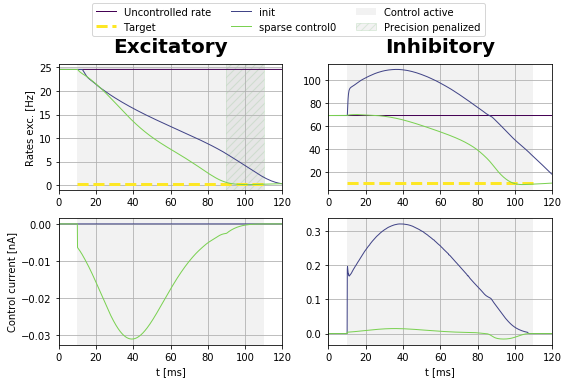

----- 2


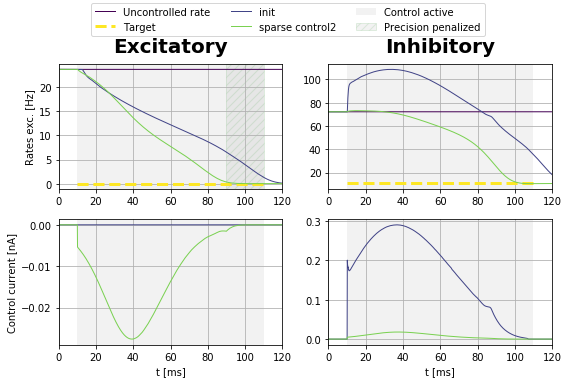

----- 4


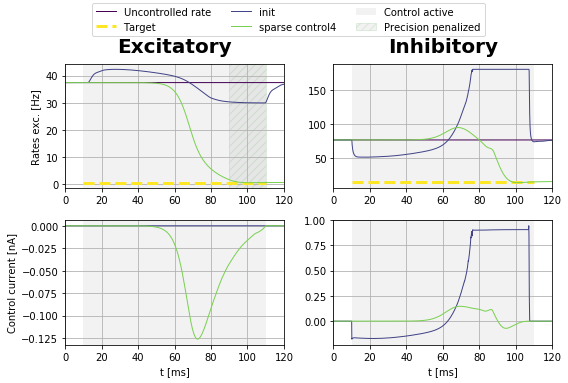

----- 6


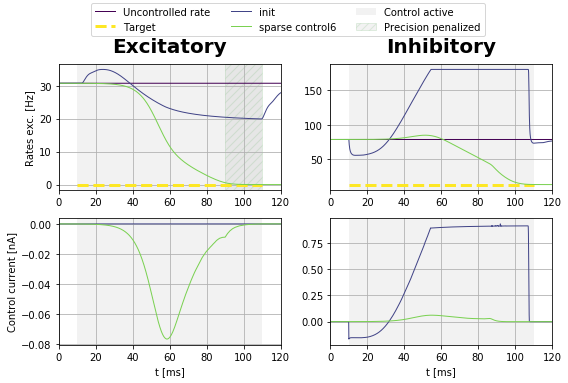

----- 8


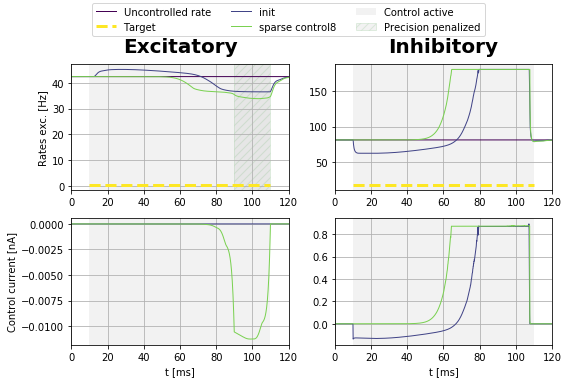

----- 10


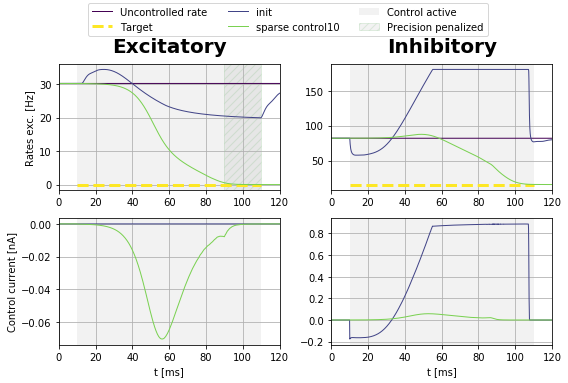

----- 12


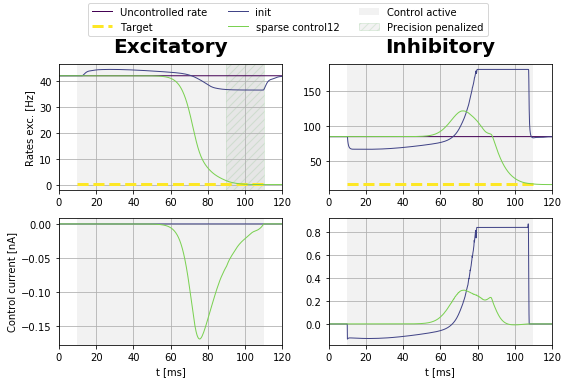

----- 14


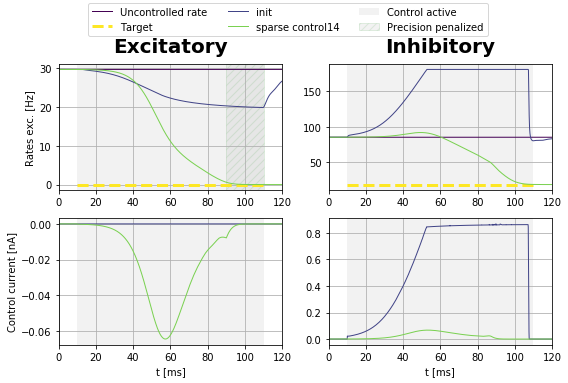

----- 16


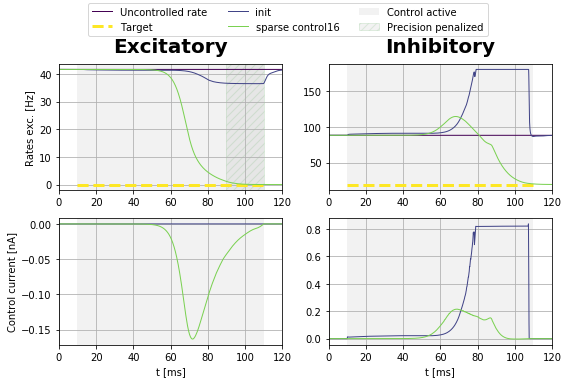

----- 18


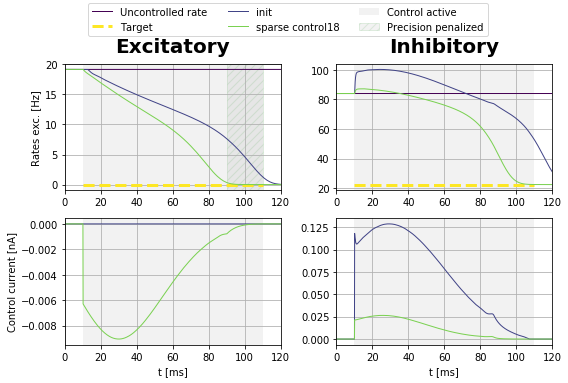

----- 20


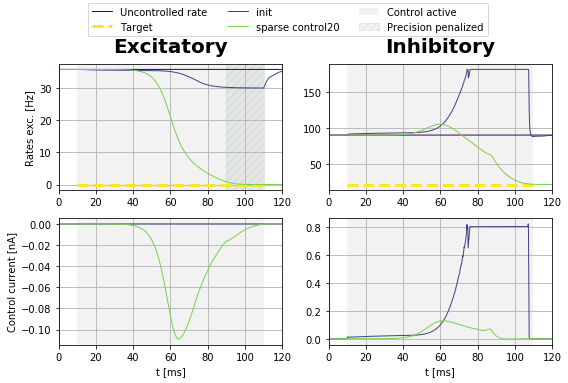

----- 22


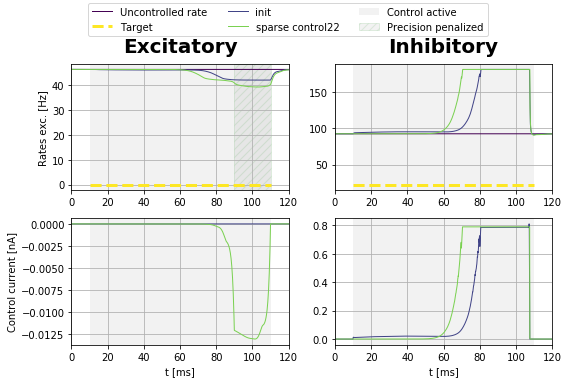

----- 24


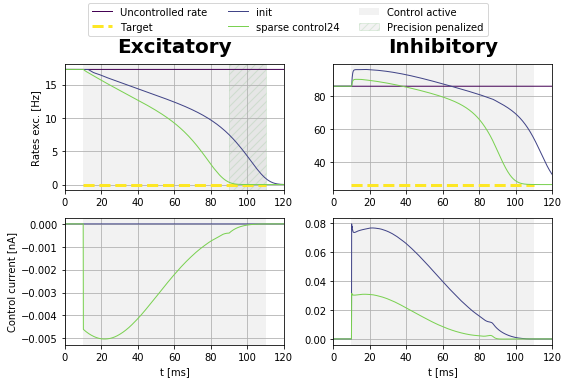

----- 26


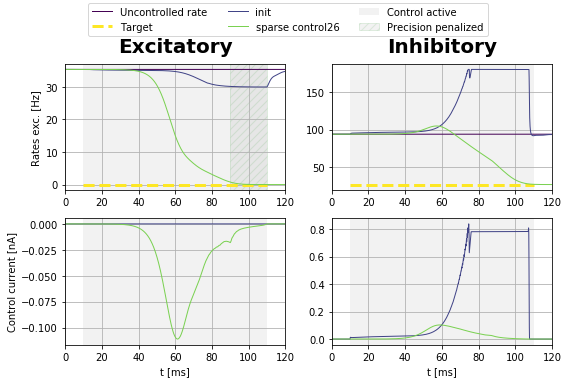

----- 28


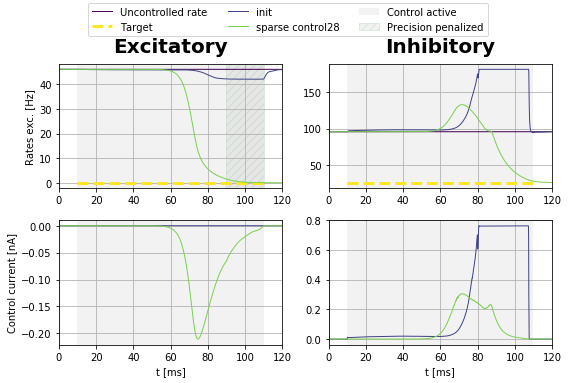

----- 30


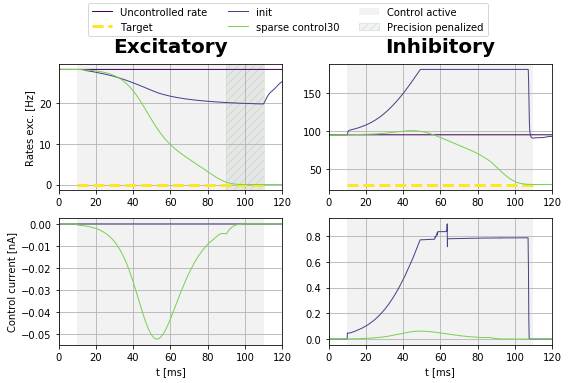

----- 32


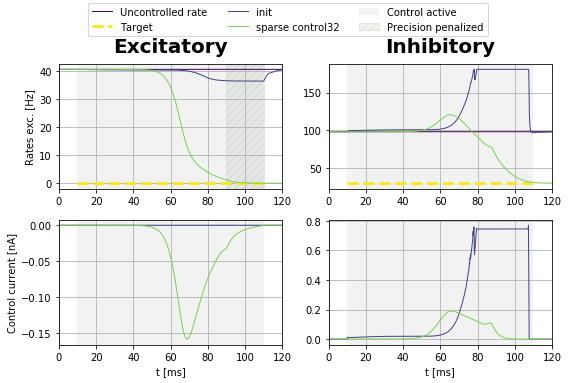

----- 34


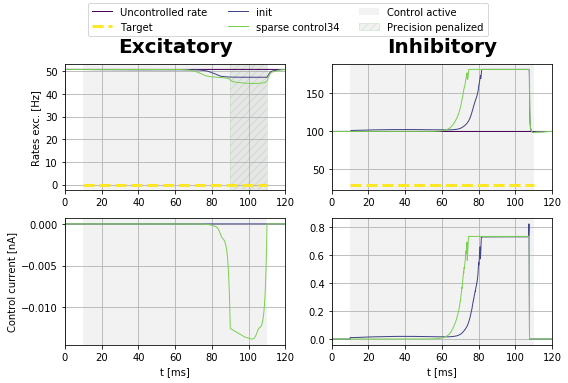

----- 36


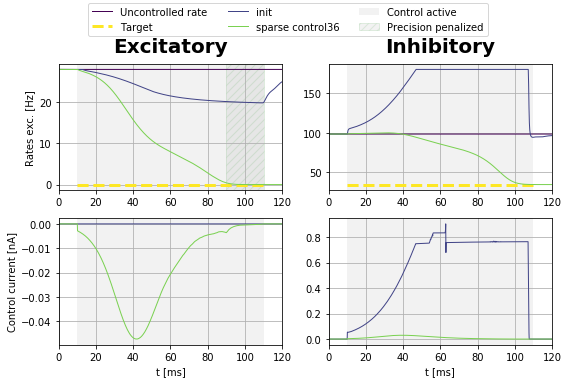

----- 38


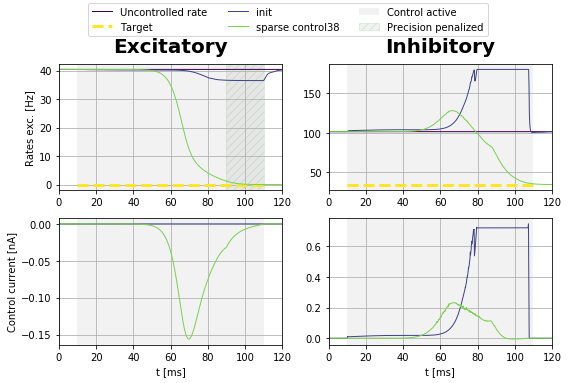

In [25]:
for i in i_range_0:
    
    print('-----', i)
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_1[i]],
        [costnode_init[i], costnode_1[i]], [weights_init[i], weights_1[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()